In [3]:
import pandas as pd
import numpy as np

# ─────────────────────────────────────────────
# 0. 파일 경로 설정
# ─────────────────────────────────────────────
train_path = "/Users/gun/Desktop/경종설/국내/train_stock_0.3.csv"
test_path  = "/Users/gun/Desktop/경종설/국내/test_stock_0.3.csv"
save_train = "/Users/gun/Desktop/경종설/국내/train_stock_0.3_ind_neutral.csv"
save_test  = "/Users/gun/Desktop/경종설/국내/test_stock_0.3_ind_neutral.csv"

# ─────────────────────────────────────────────
# 1. 데이터 로드
# ─────────────────────────────────────────────
train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)

# ─────────────────────────────────────────────
# 2. 결측치 처리 (Global Median Imputation)
#    - 산업별 median으로 처리해도 무방합니다.
# ─────────────────────────────────────────────
def median_impute(df, cols):
    for col in cols:
        median_val = df[col].median()
        df[col] = df[col].fillna(median_val)

# 팩터에 쓰일 모든 원시 컬럼 목록
all_factor_cols = [
    'PER', 'PBR', 'PSR', 'roe_per_ratio',
    'ROE', '영업이익률', 'EPS', '부채비율', '당기순이익', '영업이익', '자본총계',
    '1개월수익률', '3개월수익률', '6개월수익률', '12개월수익률',
    'momentum_diff', 'momentum_accel', 'momentum_trend_slope',
    'trend_positive_count', '평균거래량증가율',
    '시가총액', '발행주식수', '자산총계', '자본금', '매출액', '부채총계',
    '3개월변동성', '12개월변동성', 'return_vol_ratio', 'volatility_spread',
    'monthly_return_cv', '거래회전율'
]

# 결측치 처리
median_impute(train_df, all_factor_cols)
median_impute(test_df, all_factor_cols)

# ─────────────────────────────────────────────
# 3. 산업 중립화(Industry Neutral) Z‐score 함수
#    - 각 산업군별로 평균, 표준편차를 구해 Z‐score 계산
#    - 표준편차가 0인 경우(동일 값만 존재) Z‐score는 0으로 처리
# ─────────────────────────────────────────────
def industry_zscore(df, col, industry_col='산업군'):
    """
    df[col]을 df[industry_col] 그룹별로 Z-score 산업 중립화
      Z = (x - μ_ind) / σ_ind
    σ_ind = 0인 경우 Z = 0 처리
    """
    # 그룹별 평균/표준편차 계산
    grp = df.groupby(industry_col)[col]
    mean_ind = grp.transform('mean')
    std_ind  = grp.transform('std').replace(0, np.nan)  # 0→NaN으로 바꿔서 나누기 방지
    
    z = (df[col] - mean_ind) / std_ind
    z = z.fillna(0.0)  # std_ind가 0(동일 값)이면 Z=0 처리
    return z

# ─────────────────────────────────────────────
# 4. 팩터별 산업 중립화 Z‐score 계산
# ─────────────────────────────────────────────
def add_industry_neutral_factors(df):
    # 4.1 Value 팩터
    df['PER_z']           = industry_zscore(df, 'PER')
    df['PBR_z']           = industry_zscore(df, 'PBR')
    df['PSR_z']           = industry_zscore(df, 'PSR')
    df['roe_per_ratio_z'] = industry_zscore(df, 'roe_per_ratio')
    df['value_score']     = df[['PER_z', 'PBR_z', 'PSR_z', 'roe_per_ratio_z']].mean(axis=1)

    # 4.2 Quality 팩터
    df['ROE_z']       = industry_zscore(df, 'ROE')
    df['영업이익률_z']  = industry_zscore(df, '영업이익률')
    df['EPS_z']       = industry_zscore(df, 'EPS')
    df['부채비율_z']    = industry_zscore(df, '부채비율')
    df['당기순이익_z']  = industry_zscore(df, '당기순이익')
    df['영업이익_z']    = industry_zscore(df, '영업이익')
    df['자본총계_z']    = industry_zscore(df, '자본총계')
    df['quality_score'] = df[['ROE_z', '영업이익률_z', 'EPS_z', '부채비율_z',
                              '당기순이익_z', '영업이익_z', '자본총계_z']].mean(axis=1)

    # 4.3 Momentum 팩터
    df['1M_z']      = industry_zscore(df, '1개월수익률')
    df['3M_z']      = industry_zscore(df, '3개월수익률')
    df['6M_z']      = industry_zscore(df, '6개월수익률')
    df['12M_z']     = industry_zscore(df, '12개월수익률')
    df['m_diff_z']  = industry_zscore(df, 'momentum_diff')
    df['m_accel_z'] = industry_zscore(df, 'momentum_accel')
    df['m_slope_z'] = industry_zscore(df, 'momentum_trend_slope')
    df['trend_cnt_z']= industry_zscore(df, 'trend_positive_count')
    df['avg_vol_z'] = industry_zscore(df, '평균거래량증가율')
    df['momentum_score'] = df[['1M_z', '3M_z', '6M_z', '12M_z',
                               'm_diff_z', 'm_accel_z', 'm_slope_z',
                               'trend_cnt_z', 'avg_vol_z']].mean(axis=1)

    # 4.4 Size 팩터
    df['mktcap_z']    = industry_zscore(df, '시가총액')
    df['shares_z']    = industry_zscore(df, '발행주식수')
    df['assets_z']    = industry_zscore(df, '자산총계')
    df['capital_z']   = industry_zscore(df, '자본금')
    df['revenue_z']   = industry_zscore(df, '매출액')
    df['liab_z']      = industry_zscore(df, '부채총계')
    df['size_score']  = df[['mktcap_z', 'shares_z', 'assets_z', 'capital_z', 'revenue_z', 'liab_z']].mean(axis=1)

    # 4.5 Low Volatility 팩터 (“변동성 작을수록 좋음” → 부호 반전)
    df['vol3_z']   = industry_zscore(df, '3개월변동성')
    df['vol12_z']  = industry_zscore(df, '12개월변동성')
    df['r_vol_z']  = industry_zscore(df, 'return_vol_ratio')
    df['v_spread_z']= industry_zscore(df, 'volatility_spread')
    df['mcv_z']    = industry_zscore(df, 'monthly_return_cv')
    df['turn_z']   = industry_zscore(df, '거래회전율')
    df['lowvol_score'] = -df[['vol3_z', 'vol12_z', 'r_vol_z', 'v_spread_z', 'mcv_z', 'turn_z']].mean(axis=1)

    # 4.6 최종 통합 스코어 (시장 가중치 미적용 상태)
    df['final_score'] = df[[
        'value_score', 'quality_score', 'momentum_score', 'size_score', 'lowvol_score'
    ]].mean(axis=1)

    return df

# ─────────────────────────────────────────────
# 5. Train/Test 모두 산업 중립화 팩터 계산
# ─────────────────────────────────────────────
train_neutral = add_industry_neutral_factors(train_df)
test_neutral  = add_industry_neutral_factors(test_df)

# ─────────────────────────────────────────────
# 6. 결과 저장
# ─────────────────────────────────────────────
train_neutral.to_csv(save_train, index=False)
test_neutral.to_csv(save_test, index=False)

print(f"[✔] 산업 중립화 팩터 스코어 저장 완료:\n - 훈련셋: {save_train}\n - 테스트셋: {save_test}")

[✔] 산업 중립화 팩터 스코어 저장 완료:
 - 훈련셋: /Users/gun/Desktop/경종설/국내/train_stock_0.3_ind_neutral.csv
 - 테스트셋: /Users/gun/Desktop/경종설/국내/test_stock_0.3_ind_neutral.csv


                   count          mean       std        min       25%  \
PER_z            55044.0  7.487007e-18  0.999328 -24.932077 -0.078452   
PBR_z            55044.0  1.342498e-17  0.999328 -22.033480 -0.461286   
PSR_z            55044.0  2.271919e-17  0.999328  -1.170850 -0.369971   
roe_per_ratio_z  55044.0  1.678122e-17  0.999328 -19.497316 -0.282070   
ROE_z            55044.0 -3.098072e-18  0.999328 -23.501657 -0.223575   
영업이익률_z          55044.0 -2.065381e-18  0.999328 -20.220106 -0.252763   
EPS_z            55044.0  2.065381e-17  0.999328 -12.167563 -0.340962   
부채비율_z           55044.0  2.065381e-18  0.999328 -19.621845 -0.561927   
당기순이익_z          55044.0  2.891534e-17  0.999328 -21.467550 -0.302554   
영업이익_z           55044.0  1.032691e-17  0.999328  -8.484948 -0.310744   
자본총계_z           55044.0  8.261524e-18  0.999328  -2.782099 -0.389215   
1M_z             55044.0  3.098072e-18  0.999328  -5.697358 -0.543026   
3M_z             55044.0  4.647107e-18  0.999328  -

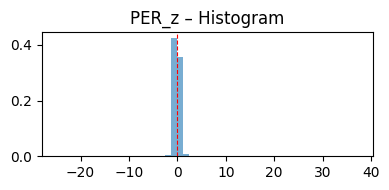

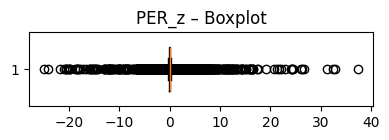

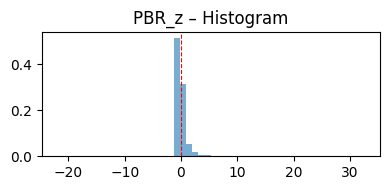

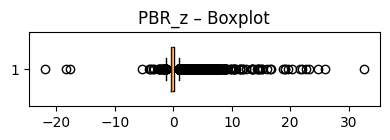

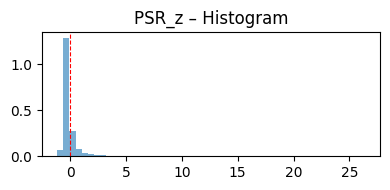

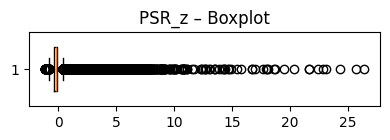

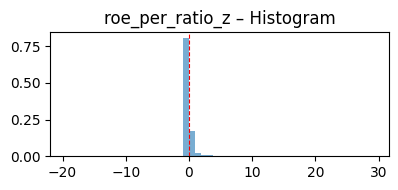

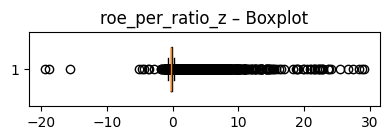

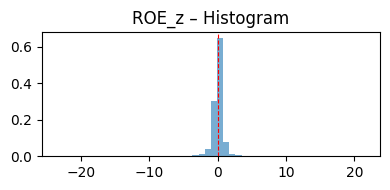

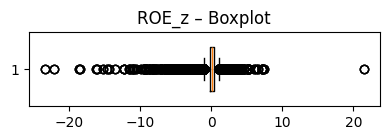

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_78793/4254746510.py:38: UserWarning: Glyph 50689 (\N{HANGUL SYLLABLE YEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_78793/4254746510.py:38: UserWarning: Glyph 50629 (\N{HANGUL SYLLABLE EOB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_78793/4254746510.py:38: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_78793/4254746510.py:38: UserWarning: Glyph 51061 (\N{HANGUL SYLLABLE IG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_78793/4254746510.py:38: UserWarning: Glyph 47456 (\N{HANGUL SYLLABLE RYUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/envs/fdr_env/lib/python3.10/site-package

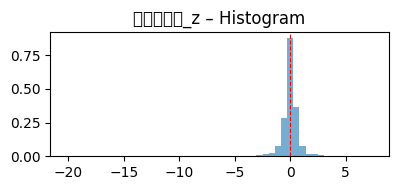

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_78793/4254746510.py:45: UserWarning: Glyph 50689 (\N{HANGUL SYLLABLE YEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_78793/4254746510.py:45: UserWarning: Glyph 50629 (\N{HANGUL SYLLABLE EOB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_78793/4254746510.py:45: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_78793/4254746510.py:45: UserWarning: Glyph 51061 (\N{HANGUL SYLLABLE IG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_78793/4254746510.py:45: UserWarning: Glyph 47456 (\N{HANGUL SYLLABLE RYUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/envs/fdr_env/lib/python3.10/site-package

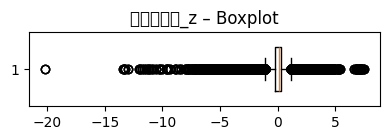

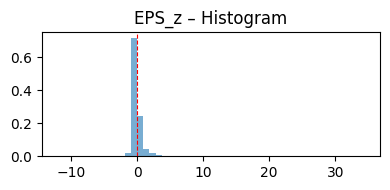

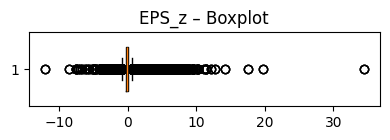

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_78793/4254746510.py:38: UserWarning: Glyph 48512 (\N{HANGUL SYLLABLE BU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_78793/4254746510.py:38: UserWarning: Glyph 52292 (\N{HANGUL SYLLABLE CAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_78793/4254746510.py:38: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_78793/4254746510.py:38: UserWarning: Glyph 50984 (\N{HANGUL SYLLABLE YUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/envs/fdr_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48512 (\N{HANGUL SYLLABLE BU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/fdr_env/lib

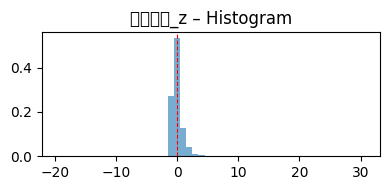

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_78793/4254746510.py:45: UserWarning: Glyph 48512 (\N{HANGUL SYLLABLE BU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_78793/4254746510.py:45: UserWarning: Glyph 52292 (\N{HANGUL SYLLABLE CAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_78793/4254746510.py:45: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_78793/4254746510.py:45: UserWarning: Glyph 50984 (\N{HANGUL SYLLABLE YUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/envs/fdr_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48512 (\N{HANGUL SYLLABLE BU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/fdr_env/lib

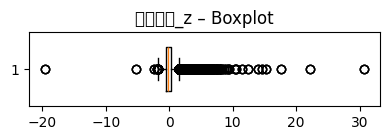

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_78793/4254746510.py:38: UserWarning: Glyph 45817 (\N{HANGUL SYLLABLE DANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_78793/4254746510.py:38: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_78793/4254746510.py:38: UserWarning: Glyph 49692 (\N{HANGUL SYLLABLE SUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_78793/4254746510.py:38: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_78793/4254746510.py:38: UserWarning: Glyph 51061 (\N{HANGUL SYLLABLE IG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/envs/fdr_env/lib/python3.10/site-packages/I

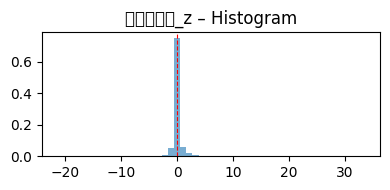

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_78793/4254746510.py:45: UserWarning: Glyph 45817 (\N{HANGUL SYLLABLE DANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_78793/4254746510.py:45: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_78793/4254746510.py:45: UserWarning: Glyph 49692 (\N{HANGUL SYLLABLE SUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_78793/4254746510.py:45: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_78793/4254746510.py:45: UserWarning: Glyph 51061 (\N{HANGUL SYLLABLE IG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/envs/fdr_env/lib/python3.10/site-packages/I

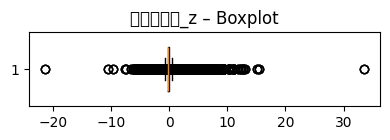

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_78793/4254746510.py:38: UserWarning: Glyph 50689 (\N{HANGUL SYLLABLE YEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_78793/4254746510.py:38: UserWarning: Glyph 50629 (\N{HANGUL SYLLABLE EOB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_78793/4254746510.py:38: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_78793/4254746510.py:38: UserWarning: Glyph 51061 (\N{HANGUL SYLLABLE IG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/envs/fdr_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 50689 (\N{HANGUL SYLLABLE YEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/fdr_env

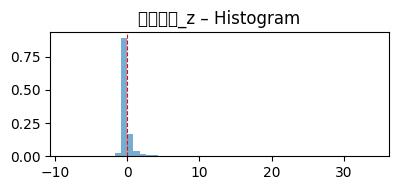

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_78793/4254746510.py:45: UserWarning: Glyph 50689 (\N{HANGUL SYLLABLE YEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_78793/4254746510.py:45: UserWarning: Glyph 50629 (\N{HANGUL SYLLABLE EOB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_78793/4254746510.py:45: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_78793/4254746510.py:45: UserWarning: Glyph 51061 (\N{HANGUL SYLLABLE IG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/envs/fdr_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 50689 (\N{HANGUL SYLLABLE YEONG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/fdr_env

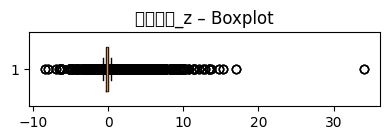

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_78793/4254746510.py:38: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_78793/4254746510.py:38: UserWarning: Glyph 48376 (\N{HANGUL SYLLABLE BON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_78793/4254746510.py:38: UserWarning: Glyph 52509 (\N{HANGUL SYLLABLE CONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_78793/4254746510.py:38: UserWarning: Glyph 44228 (\N{HANGUL SYLLABLE GYE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/envs/fdr_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/fdr_env/l

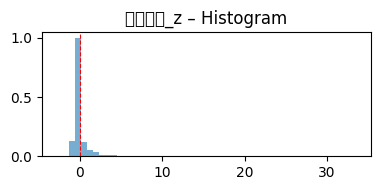

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_78793/4254746510.py:45: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_78793/4254746510.py:45: UserWarning: Glyph 48376 (\N{HANGUL SYLLABLE BON}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_78793/4254746510.py:45: UserWarning: Glyph 52509 (\N{HANGUL SYLLABLE CONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_78793/4254746510.py:45: UserWarning: Glyph 44228 (\N{HANGUL SYLLABLE GYE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/envs/fdr_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 51088 (\N{HANGUL SYLLABLE JA}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/fdr_env/l

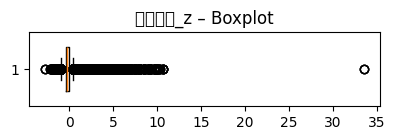

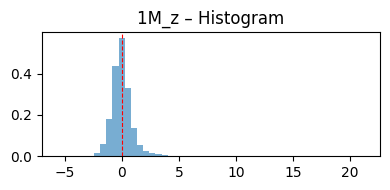

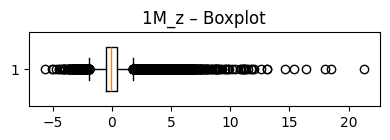

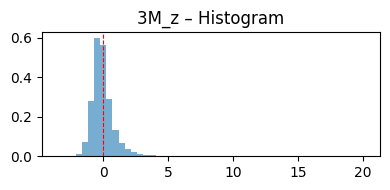

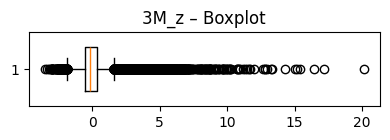

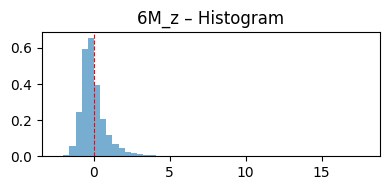

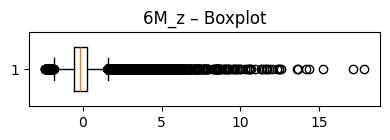

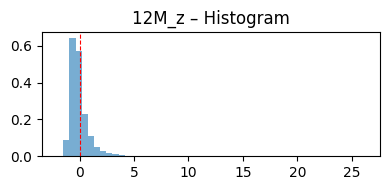

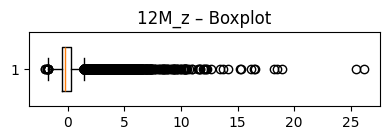

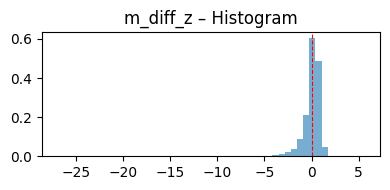

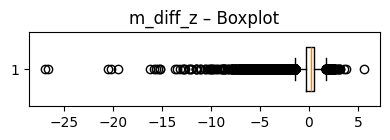

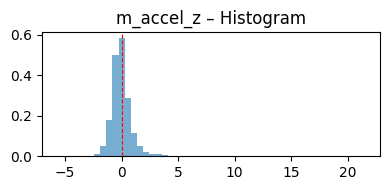

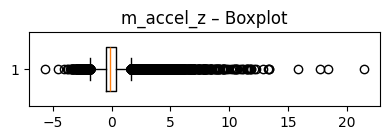

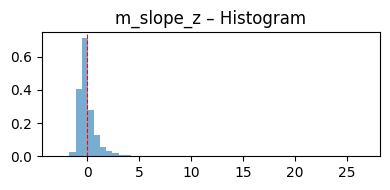

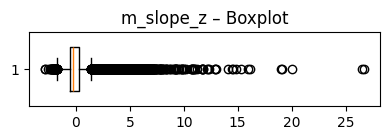

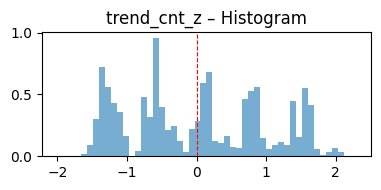

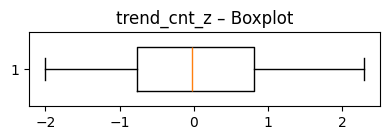

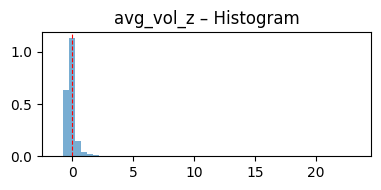

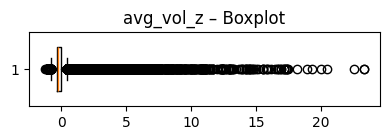

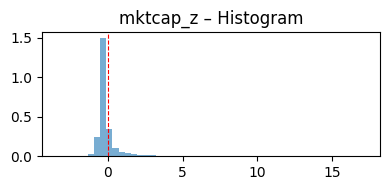

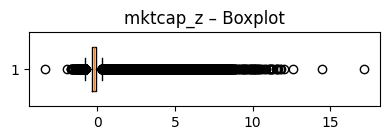

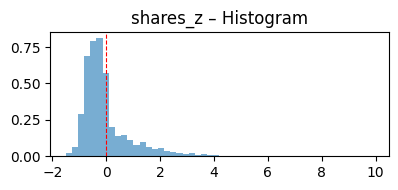

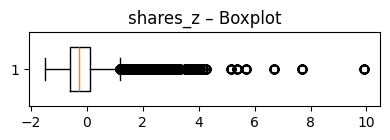

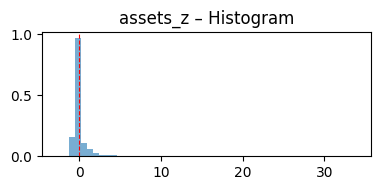

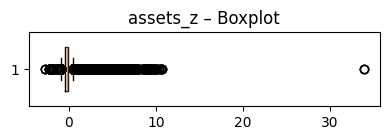

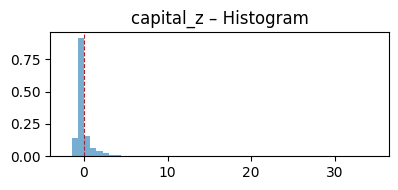

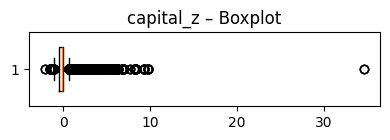

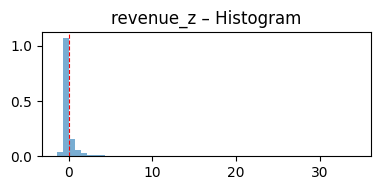

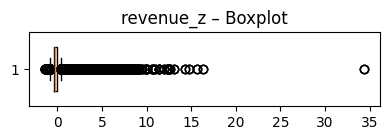

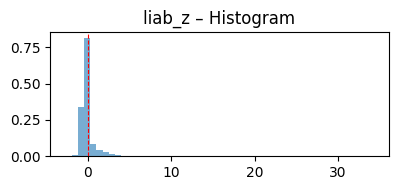

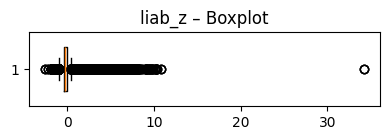

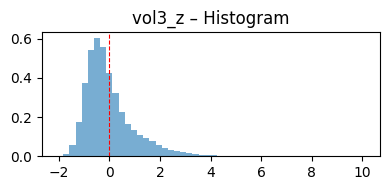

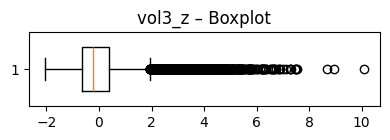

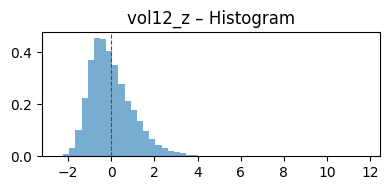

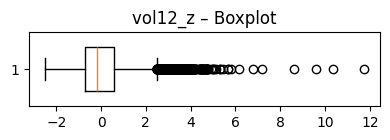

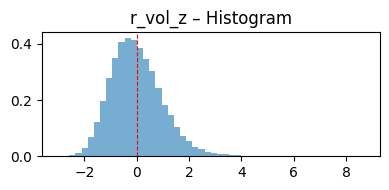

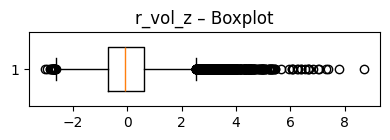

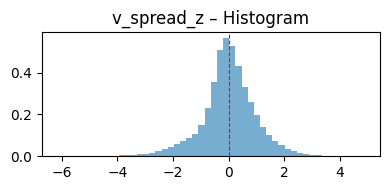

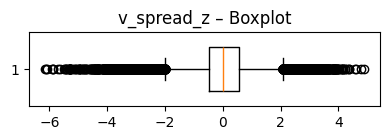

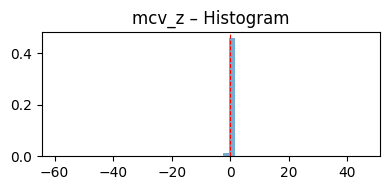

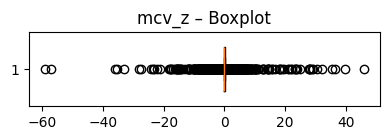

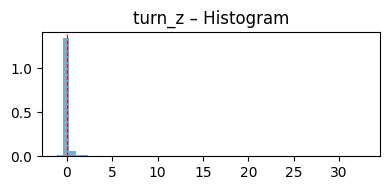

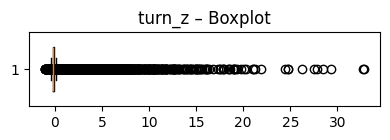

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# ────────────────────────────────────────────────────
# 1-1. ‘산업 중립화 팩터 스코어’가 포함된 파일 로드
# ────────────────────────────────────────────────────
path = "/Users/gun/Desktop/경종설/국내/train_stock_0.3_ind_neutral.csv"
df = pd.read_csv(path)

# 2) Z-score 컬럼 리스트
z_cols = [
    'PER_z', 'PBR_z', 'PSR_z', 'roe_per_ratio_z',
    'ROE_z', '영업이익률_z', 'EPS_z', '부채비율_z', '당기순이익_z', '영업이익_z', '자본총계_z',
    '1M_z', '3M_z', '6M_z', '12M_z', 'm_diff_z', 'm_accel_z', 'm_slope_z', 'trend_cnt_z', 'avg_vol_z',
    'mktcap_z', 'shares_z', 'assets_z', 'capital_z', 'revenue_z', 'liab_z',
    'vol3_z', 'vol12_z', 'r_vol_z', 'v_spread_z', 'mcv_z', 'turn_z'
]

# 3) describe() 결과 전치하여 출력
stats = df[z_cols].describe().loc[['count','mean','std','min','25%','50%','75%','max']]
print(stats.T)

# ────────────────────────────────────────────────────
# 1-4. 히스토그램 + 박스플롯 시각화
# ────────────────────────────────────────────────────
for col in z_cols:
    # (a) 히스토그램
    plt.figure(figsize=(4, 2))
    plt.title(f"{col} – Histogram")
    plt.hist(df[col].dropna(), bins=50, density=True, alpha=0.6)
    plt.axvline(0, color='red', linestyle='--', linewidth=0.8)
    plt.tight_layout()
    plt.show()

    # (b) 박스플롯
    plt.figure(figsize=(4, 1.5))
    plt.title(f"{col} – Boxplot")
    plt.boxplot(df[col].dropna(), vert=False, widths=0.6)
    plt.tight_layout()
    plt.show()

In [9]:
import pandas as pd

# ─────────────────────────────────────────────
# 1) 산업 중립화(Z-score) 결과 로드
# ─────────────────────────────────────────────
path = "/Users/gun/Desktop/경종설/국내/train_stock_0.3_ind_neutral.csv"
df = pd.read_csv(path)

# ─────────────────────────────────────────────
# 2) 검사할 Z-score 컬럼 리스트 정의
# ─────────────────────────────────────────────
z_cols = [
    'PER_z', 'PBR_z', 'PSR_z', 'roe_per_ratio_z',
    'ROE_z', '영업이익률_z', 'EPS_z', '부채비율_z', '당기순이익_z', '영업이익_z', '자본총계_z',
    '1M_z', '3M_z', '6M_z', '12M_z', 'm_diff_z', 'm_accel_z', 'm_slope_z', 'trend_cnt_z', 'avg_vol_z',
    'mktcap_z', 'shares_z', 'assets_z', 'capital_z', 'revenue_z', 'liab_z',
    'vol3_z', 'vol12_z', 'r_vol_z', 'v_spread_z', 'mcv_z', 'turn_z'
]

# ─────────────────────────────────────────────
# 3) 전체 행 개수
# ─────────────────────────────────────────────
n_total = len(df)

# ─────────────────────────────────────────────
# 4) 이상치 비율 계산 출력
# ─────────────────────────────────────────────
print("=== Z-score 이상치 비율 (|Z|>3, |Z|>5) ===")
for col in z_cols:
    count_gt3 = (df[col].abs() > 3).sum()
    count_gt5 = (df[col].abs() > 5).sum()
    ratio_gt3 = count_gt3 / n_total * 100
    ratio_gt5 = count_gt5 / n_total * 100

    print(f"{col:20s} | |Z|>3: {count_gt3:6d}   ({ratio_gt3:5.2f}%) | "
          f"|Z|>5: {count_gt5:6d}   ({ratio_gt5:5.2f}%)")

=== Z-score 이상치 비율 (|Z|>3, |Z|>5) ===
PER_z                | |Z|>3:    614   ( 1.12%) | |Z|>5:    361   ( 0.66%)
PBR_z                | |Z|>3:    972   ( 1.77%) | |Z|>5:    282   ( 0.51%)
PSR_z                | |Z|>3:   1056   ( 1.92%) | |Z|>5:    422   ( 0.77%)
roe_per_ratio_z      | |Z|>3:    807   ( 1.47%) | |Z|>5:    358   ( 0.65%)
ROE_z                | |Z|>3:    864   ( 1.57%) | |Z|>5:    261   ( 0.47%)
영업이익률_z              | |Z|>3:   1113   ( 2.02%) | |Z|>5:    372   ( 0.68%)
EPS_z                | |Z|>3:   1110   ( 2.02%) | |Z|>5:    360   ( 0.65%)
부채비율_z               | |Z|>3:    687   ( 1.25%) | |Z|>5:    201   ( 0.37%)
당기순이익_z              | |Z|>3:   1122   ( 2.04%) | |Z|>5:    402   ( 0.73%)
영업이익_z               | |Z|>3:   1098   ( 1.99%) | |Z|>5:    399   ( 0.72%)
자본총계_z               | |Z|>3:   1245   ( 2.26%) | |Z|>5:    420   ( 0.76%)
1M_z                 | |Z|>3:    799   ( 1.45%) | |Z|>5:    197   ( 0.36%)
3M_z                 | |Z|>3:    855   ( 1.55%) | |Z|>5:    26

=== 이상치 처리 후 통계량 (min, 25%, 50%, 75%, max) ===
        PER_z     PBR_z     PSR_z  roe_per_ratio_z     ROE_z   영업이익률_z     EPS_z    부채비율_z   당기순이익_z      1M_z      3M_z      6M_z     12M_z  m_diff_z  m_accel_z  m_slope_z  trend_cnt_z  avg_vol_z  \
min -0.459405 -1.159312 -0.840080        -0.504237 -0.809353 -2.643832 -1.155247 -1.807846 -0.840771 -1.758337 -1.943206 -1.956500 -1.832384 -1.645077  -2.048747  -1.978868    -1.989310  -0.865504   
25% -0.125736 -0.467984 -0.379229        -0.249256 -0.130677 -0.279612 -0.367608 -0.570109 -0.276650 -0.504299 -0.553815 -0.569575 -0.551847 -0.303022  -0.517619  -0.532322    -0.969165  -0.346390   
50% -0.002722 -0.240968 -0.230548        -0.166248  0.107921  0.106387 -0.203983 -0.186038 -0.144205 -0.088416 -0.126020 -0.134417 -0.173545  0.152972  -0.123833  -0.172491    -0.209091  -0.218793   
75%  0.081763  0.095380 -0.057885        -0.079269  0.321774  0.390320  0.105229  0.255049  0.046244  0.331727  0.372445  0.355042  0.301845  0.520695   

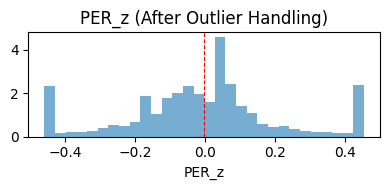

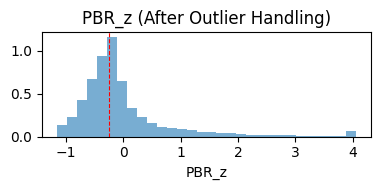

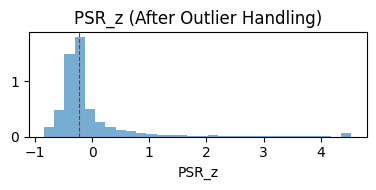

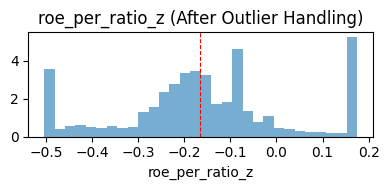

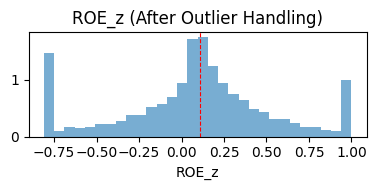

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_78793/844071421.py:122: UserWarning: Glyph 50689 (\N{HANGUL SYLLABLE YEONG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_78793/844071421.py:122: UserWarning: Glyph 50629 (\N{HANGUL SYLLABLE EOB}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_78793/844071421.py:122: UserWarning: Glyph 51060 (\N{HANGUL SYLLABLE I}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_78793/844071421.py:122: UserWarning: Glyph 51061 (\N{HANGUL SYLLABLE IG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_78793/844071421.py:122: UserWarning: Glyph 47456 (\N{HANGUL SYLLABLE RYUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/envs/fdr_env/lib/python3.10/site-package

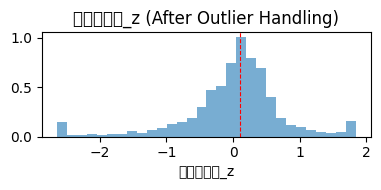

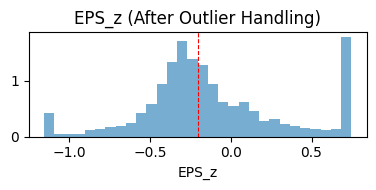

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_78793/844071421.py:122: UserWarning: Glyph 48512 (\N{HANGUL SYLLABLE BU}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_78793/844071421.py:122: UserWarning: Glyph 52292 (\N{HANGUL SYLLABLE CAE}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_78793/844071421.py:122: UserWarning: Glyph 48708 (\N{HANGUL SYLLABLE BI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_78793/844071421.py:122: UserWarning: Glyph 50984 (\N{HANGUL SYLLABLE YUL}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/envs/fdr_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 48512 (\N{HANGUL SYLLABLE BU}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/fdr_env/lib

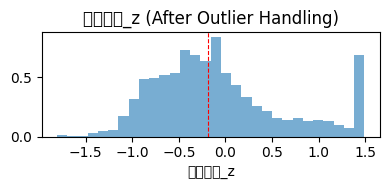

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_78793/844071421.py:122: UserWarning: Glyph 45817 (\N{HANGUL SYLLABLE DANG}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_78793/844071421.py:122: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_78793/844071421.py:122: UserWarning: Glyph 49692 (\N{HANGUL SYLLABLE SUN}) missing from font(s) DejaVu Sans.
  plt.tight_layout()
/opt/anaconda3/envs/fdr_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 45817 (\N{HANGUL SYLLABLE DANG}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/opt/anaconda3/envs/fdr_env/lib/python3.10/site-packages/IPython/core/pylabtools.py:170: UserWarning: Glyph 44592 (\N{HANGUL SYLLABLE GI}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)
/

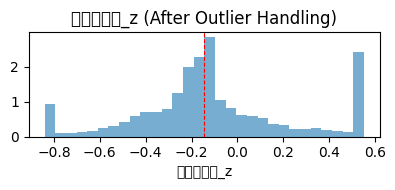

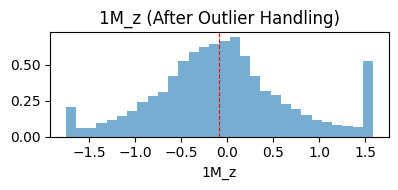

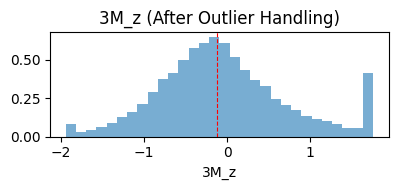

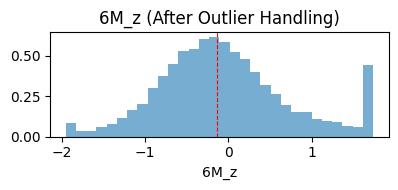

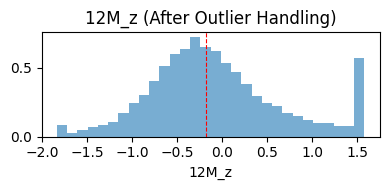

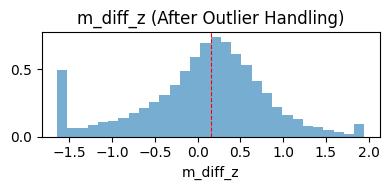

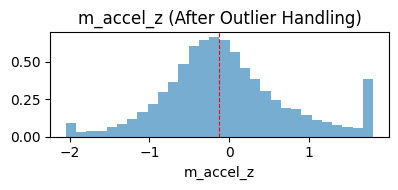

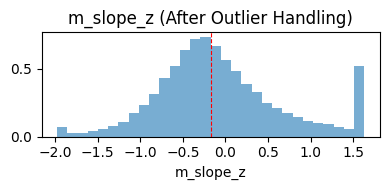

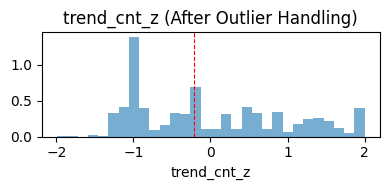

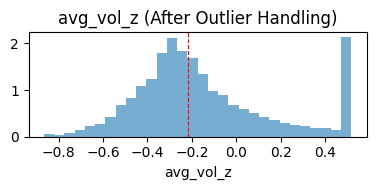

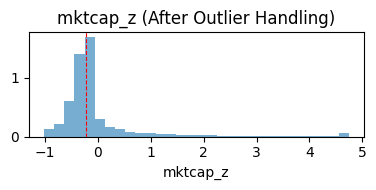

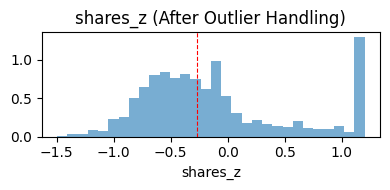

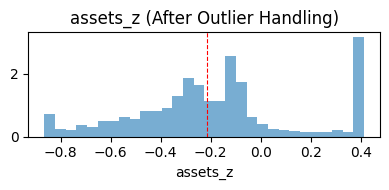

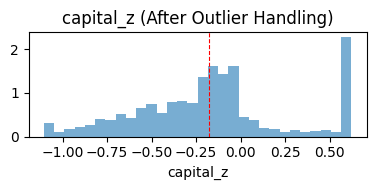

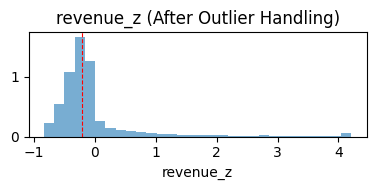

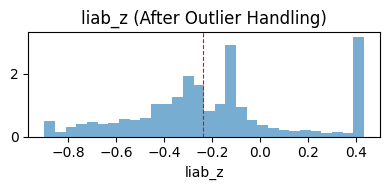

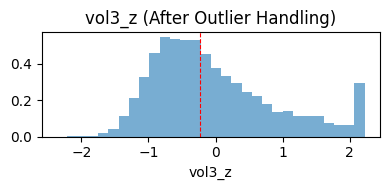

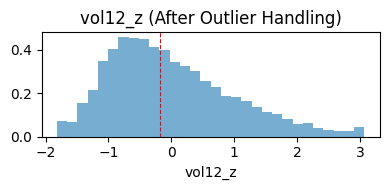

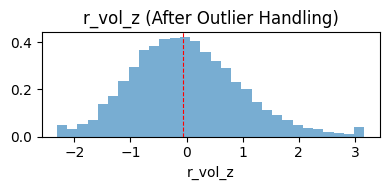

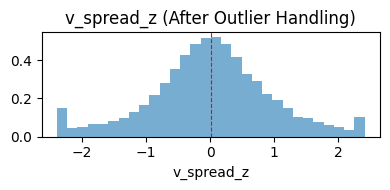

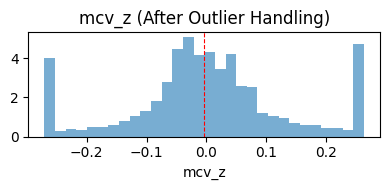

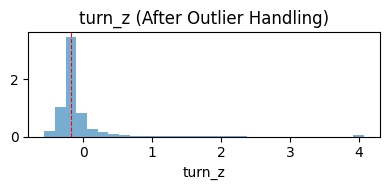

[✔] 이상치 처리된 데이터 저장 완료: /Users/gun/Desktop/경종설/국내/train_stock_0.3_outlier_processed.csv


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ────────────────────────────────────────────────────
# 1) 데이터 로드: 산업 중립화된 Z-score 포함된 파일 경로를 실제 환경에 맞게 수정하세요.
# ────────────────────────────────────────────────────
path = "/Users/gun/Desktop/경종설/국내/test_stock_0.3_ind_neutral.csv"  # 예시 경로
df = pd.read_csv(path)

# ────────────────────────────────────────────────────
# 2) 팩터별 이상치 처리 설정
#    key: Z-score 컬럼 이름
#    value: (method, parameter)
# ────────────────────────────────────────────────────
outlier_config = {
    # Value 팩터
    "PER_z":           ("mad", 3.0),
    "PBR_z":           ("percentile", (0.01, 0.99)),
    "PSR_z":           ("percentile", (0.01, 0.99)),
    "roe_per_ratio_z": ("iqr", 1.5),

    # Quality 팩터
    "ROE_z":           ("iqr", 1.5),
    "영업이익률_z":       ("percentile", (0.02, 0.98)),
    "EPS_z":           ("mad", 3.0),
    "부채비율_z":         ("iqr", 1.5),
    "당기순이익_z":       ("mad", 3.0),

    # Momentum 팩터
    "1M_z":            ("iqr", 1.5),
    "3M_z":            ("iqr", 1.5),
    "6M_z":            ("iqr", 1.5),
    "12M_z":           ("iqr", 1.5),
    "m_diff_z":        ("mad", 3.0),
    "m_accel_z":       ("mad", 3.0),
    "m_slope_z":       ("mad", 3.0),
    "trend_cnt_z":     ("clip", (-2, 2)),
    "avg_vol_z":       ("iqr", 1.5),

    # Size 팩터
    "mktcap_z":        ("percentile", (0.01, 0.99)),
    "shares_z":        ("iqr", 1.5),
    "assets_z":        ("iqr", 1.5),
    "capital_z":       ("iqr", 1.5),
    "revenue_z":       ("percentile", (0.01, 0.99)),
    "liab_z":          ("iqr", 1.5),

    # Low Volatility 팩터
    "vol3_z":          ("iqr", 1.5),
    "vol12_z":         ("percentile", (0.005, 0.995)),
    "r_vol_z":         ("percentile", (0.005, 0.995)),
    "v_spread_z":      ("mad", 3.0),
    "mcv_z":           ("mad", 3.0),
    "turn_z":          ("percentile", (0.01, 0.99)),
}

# ────────────────────────────────────────────────────
# 3) 이상치 처리 함수 정의
# ────────────────────────────────────────────────────
def percentile_winsorize(series: pd.Series, lower_pct: float, upper_pct: float) -> pd.Series:
    lo = series.quantile(lower_pct)
    hi = series.quantile(upper_pct)
    return series.clip(lower=lo, upper=hi)

def iqr_winsorize(series: pd.Series, k: float = 1.5) -> pd.Series:
    Q1 = series.quantile(0.25)
    Q3 = series.quantile(0.75)
    IQR = Q3 - Q1
    lower = Q1 - k * IQR
    upper = Q3 + k * IQR
    return series.clip(lower=lower, upper=upper)

def mad_winsorize(series: pd.Series, k: float = 3.0) -> pd.Series:
    med = series.median()
    mad = (series - med).abs().median()
    if mad == 0:
        return series.copy()
    scale = 1.4826 * mad
    abs_limit = k * scale
    lower = med - abs_limit
    upper = med + abs_limit
    return series.clip(lower=lower, upper=upper)

def direct_clip(series: pd.Series, lower_bound: float, upper_bound: float) -> pd.Series:
    return series.clip(lower=lower_bound, upper=upper_bound)

# ────────────────────────────────────────────────────
# 4) 팩터별 이상치 처리 적용
# ────────────────────────────────────────────────────
df_proc = df.copy()
for col, (method, param) in outlier_config.items():
    if method == "percentile":
        lo_pct, hi_pct = param
        df_proc[col] = percentile_winsorize(df[col], lo_pct, hi_pct)
    elif method == "iqr":
        k = param
        df_proc[col] = iqr_winsorize(df[col], k)
    elif method == "mad":
        k = param
        df_proc[col] = mad_winsorize(df[col], k)
    elif method == "clip":
        lo, hi = param
        df_proc[col] = direct_clip(df[col], lo, hi)

# ────────────────────────────────────────────────────
# 5) 처리 후 통계량 표시
# ────────────────────────────────────────────────────
print("=== 이상치 처리 후 통계량 (min, 25%, 50%, 75%, max) ===")
result_stats = df_proc[list(outlier_config.keys())].describe().loc[['min','25%','50%','75%','max']]
print(result_stats)

# ────────────────────────────────────────────────────
# 6) 처리 후 히스토그램 시각화
# ────────────────────────────────────────────────────
for col in outlier_config.keys():
    plt.figure(figsize=(4,2))
    plt.title(f"{col} (After Outlier Handling)")
    plt.hist(df_proc[col].dropna(), bins=30, density=True, alpha=0.6)
    plt.axvline(df_proc[col].median(), color='red', linestyle='--', linewidth=0.8)
    plt.xlabel(col)
    plt.tight_layout()
    plt.show()

# ────────────────────────────────────────────────────
# 7) 결과를 파일로 저장 (옵션)
# ────────────────────────────────────────────────────
save_path = "/Users/gun/Desktop/경종설/국내/train_stock_0.3_outlier_processed.csv"  # 예시 경로
df_proc.to_csv(save_path, index=False)
print(f"[✔] 이상치 처리된 데이터 저장 완료: {save_path}")

In [15]:
import pandas as pd

# ────────────────────────────────────────────────────
# 1. 이상치 처리된 데이터 로드
# ────────────────────────────────────────────────────
path = "/Users/gun/Desktop/경종설/국내/train_stock_0.3_outlier_processed.csv"  
df = pd.read_csv(path)

# ────────────────────────────────────────────────────
# 2. Z-score 컬럼 리스트 (outlier 처리한 컬럼)
# ────────────────────────────────────────────────────
cols = [
    "PER_z", "PBR_z", "PSR_z", "roe_per_ratio_z",
    "ROE_z", "영업이익률_z", "EPS_z", "부채비율_z", "당기순이익_z",
    "1M_z", "3M_z", "6M_z", "12M_z", "m_diff_z", "m_accel_z", "m_slope_z", "trend_cnt_z", "avg_vol_z",
    "mktcap_z", "shares_z", "assets_z", "capital_z", "revenue_z", "liab_z",
    "vol3_z", "vol12_z", "r_vol_z", "v_spread_z", "mcv_z", "turn_z"
]

# ────────────────────────────────────────────────────
# 3. describe() 결과를 전치(transpose)하여 출력
# ────────────────────────────────────────────────────
stats = df[cols].describe().loc[['min', '25%', '50%', '75%', 'max']]
print(stats.T)

# ────────────────────────────────────────────────────
# 4. (옵션) Pandas 출력 옵션을 조정해서 한 번에 보기
# ────────────────────────────────────────────────────
pd.set_option('display.max_rows', None)    # 모든 행을 표시
pd.set_option('display.max_columns', None) # 모든 열을 표시
pd.set_option('display.width', 200)        # 가로 너비를 넉넉히 설정

print("\n=== describe() 결과 (전체 보기) ===")
print(df[cols].describe().loc[['min', '25%', '50%', '75%', 'max']])

                      min       25%       50%       75%       max
PER_z           -0.459405 -0.125736 -0.002722  0.081763  0.453961
PBR_z           -1.159312 -0.467984 -0.240968  0.095380  4.061575
PSR_z           -0.840080 -0.379229 -0.230548 -0.057885  4.534521
roe_per_ratio_z -0.504237 -0.249256 -0.166248 -0.079269  0.175711
ROE_z           -0.809353 -0.130677  0.107921  0.321774  1.000450
영업이익률_z         -2.643832 -0.279612  0.106387  0.390320  1.847351
EPS_z           -1.155247 -0.367608 -0.203983  0.105229  0.747282
부채비율_z          -1.807846 -0.570109 -0.186038  0.255049  1.492785
당기순이익_z         -0.840771 -0.276650 -0.144205  0.046244  0.552361
1M_z            -1.758337 -0.504299 -0.088416  0.331727  1.585765
3M_z            -1.943206 -0.553815 -0.126020  0.372445  1.761836
6M_z            -1.956500 -0.569575 -0.134417  0.355042  1.741967
12M_z           -1.832384 -0.551847 -0.173545  0.301845  1.582382
m_diff_z        -1.645077 -0.303022  0.152972  0.520695  1.951021
m_accel_z 

In [18]:
import pandas as pd

# 실제 파일 경로로 수정하세요
path = "/Users/gun/Desktop/경종설/국내/train_stock_0.3_outlier_processed.csv"
df = pd.read_csv(path)

# Value 팩터에 속하는 Z-score 컬럼들
value_cols = ['PER_z', 'PBR_z', 'PSR_z', 'roe_per_ratio_z']

# Quality 팩터에 속하는 Z-score 컬럼들
quality_cols = ['ROE_z', '영업이익률_z', 'EPS_z', '부채비율_z', '당기순이익_z']

# Momentum 팩터에 속하는 Z-score 컬럼들
momentum_cols = [
    '1M_z', '3M_z', '6M_z', '12M_z',
    'm_diff_z', 'm_accel_z', 'm_slope_z',
    'trend_cnt_z', 'avg_vol_z'
]

# Size 팩터에 속하는 Z-score 컬럼들
size_cols = ['mktcap_z', 'shares_z', 'assets_z', 'capital_z', 'revenue_z', 'liab_z']

# Low Volatility 팩터에 속하는 Z-score 컬럼들
lowvol_cols = ['vol3_z', 'vol12_z', 'r_vol_z', 'v_spread_z', 'mcv_z', 'turn_z']

# 3-1) Value Score
df['value_score'] = df[value_cols].mean(axis=1)
# 3-2) Quality Score
df['quality_score'] = df[quality_cols].mean(axis=1)
# 3-3) Momentum Score
df['momentum_score'] = df[momentum_cols].mean(axis=1)
# 3-4) Size Score
df['size_score'] = df[size_cols].mean(axis=1)
# 3-5) Low Volatility Score
df['lowvol_score'] = df[lowvol_cols].mean(axis=1)
# (옵션) 5개 팩터를 모두 합산한 Final Score
df['final_score'] = df[['value_score','quality_score','momentum_score','size_score','lowvol_score']].mean(axis=1)

# 3-6) 결과 샘플 출력
print(df[['value_score','quality_score','momentum_score','size_score','lowvol_score','final_score']].head(5))

   value_score  quality_score  momentum_score  size_score  lowvol_score  final_score
0    -0.028863       0.569014        0.922244    0.758746      0.626337     0.569496
1    -0.056659       0.569014        0.332782    0.714710      0.555233     0.423016
2    -0.061046       0.569014        0.372338    0.707757      0.265069     0.370627
3    -0.186949       0.688377        0.309256    0.888672      0.180515     0.375974
4    -0.188913       0.688377        0.512492    0.883457      0.240633     0.427209


        value_score  quality_score  momentum_score    size_score  lowvol_score
count  18348.000000   18348.000000    18348.000000  18348.000000  18348.000000
mean      -0.052335      -0.039506       -0.047682     -0.117880     -0.010893
std        0.347679       0.324193        0.440126      0.409714      0.387890
min       -0.740758      -1.278979       -1.333168     -0.925058     -0.998903
25%       -0.234286      -0.230543       -0.363401     -0.361081     -0.291073
50%       -0.150906      -0.033021       -0.112948     -0.189088     -0.065154
75%        0.006801       0.169458        0.226262      0.001301      0.214629
max        2.222595       0.956472        1.528700      1.938140      1.997867


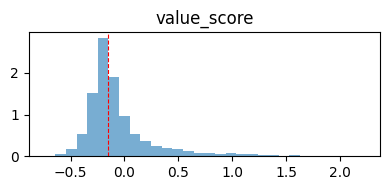

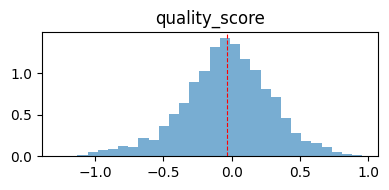

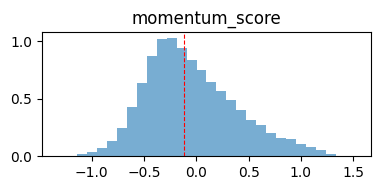

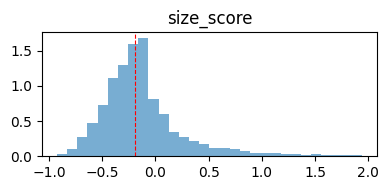

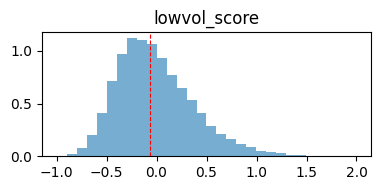

In [22]:
import matplotlib.pyplot as plt

df.columns
print(df[['value_score','quality_score','momentum_score','size_score','lowvol_score']].describe())
for col in ['value_score','quality_score','momentum_score','size_score','lowvol_score']:
    plt.figure(figsize=(4,2))
    plt.hist(df[col].dropna(), bins=30, density=True, alpha=0.6)
    plt.title(col)
    plt.axvline(df[col].median(), color='red', linestyle='--', linewidth=0.8)
    plt.tight_layout()
    plt.show()

=== Train Dataset Info ===
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 55044 entries, 0 to 55043
Data columns (total 36 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   기준월                   55044 non-null  object 
 1   회사명                   55044 non-null  object 
 2   자산총계                  55044 non-null  int64  
 3   자본총계                  55044 non-null  int64  
 4   부채총계                  55044 non-null  int64  
 5   자본금                   55044 non-null  int64  
 6   매출액                   55044 non-null  int64  
 7   영업이익                  55044 non-null  int64  
 8   당기순이익                 55044 non-null  int64  
 9   종목코드                  55044 non-null  int64  
 10  산업군                   55044 non-null  object 
 11  1개월수익률                55044 non-null  float64
 12  3개월수익률                55044 non-null  float64
 13  6개월수익률                55044 non-null  float64
 14  12개월수익률               55044 non-null  float

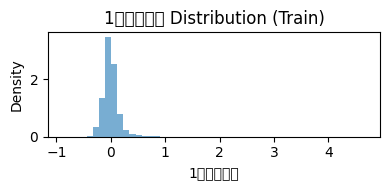

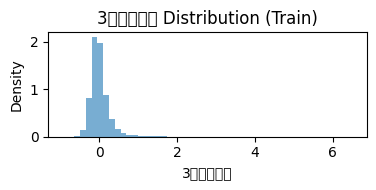

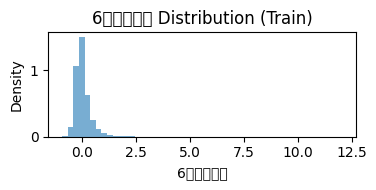

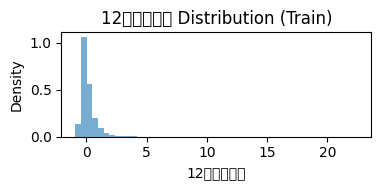

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

# ────────────────────────────────────────────────────
# 1) 데이터 로드
# ────────────────────────────────────────────────────
train_path = "/Users/gun/Desktop/경종설/국내/train_stock_0.3.csv"
test_path  = "/Users/gun/Desktop/경종설/국내/test_stock_0.3.csv"
full_path  = "/Users/gun/Desktop/경종설/국내/stock_0.3ver.csv"

train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)
full_df  = pd.read_csv(full_path)

# ────────────────────────────────────────────────────
# 2) 기본 정보 확인
# ────────────────────────────────────────────────────
print("=== Train Dataset Info ===")
print(train_df.info())
print("\n=== Train Dataset Head ===")
print(train_df.head())

print("\n=== Test Dataset Info ===")
print(test_df.info())
print("\n=== Test Dataset Head ===")
print(test_df.head())

print("\n=== Full Dataset Info ===")
print(full_df.info())
print("\n=== Full Dataset Head ===")
print(full_df.head())

# ────────────────────────────────────────────────────
# 3) 수익률 관련 컬럼 식별 (“수익률” 문자열 포함)
# ────────────────────────────────────────────────────
return_cols = [col for col in train_df.columns if "수익률" in col]
print(f"\nReturn-related columns in train dataset: {return_cols}")

# ────────────────────────────────────────────────────
# 4) 수익률 컬럼에 대한 기술 통계량 출력
# ────────────────────────────────────────────────────
print("\n=== Train Returns Descriptive Statistics ===")
print(train_df[return_cols].describe())

print("\n=== Test Returns Descriptive Statistics ===")
print(test_df[return_cols].describe())

# ────────────────────────────────────────────────────
# 5) 기준월(Date) 컬럼을 datetime으로 변환 후 범위 확인
#    → 오류가 발생한 이유: '기준월'이 "YYYY-MM-DD" 형식으로 되어 있어 format='%Y-%m'이 맞지 않음
#    → format='%Y-%m-%d'로 수정하거나 format 생략
# ────────────────────────────────────────────────────
train_df['기준월'] = pd.to_datetime(train_df['기준월'], format='%Y-%m-%d')
test_df['기준월']  = pd.to_datetime(test_df['기준월'],  format='%Y-%m-%d')

print(f"\nTrain date range: {train_df['기준월'].min()} to {train_df['기준월'].max()}")
print(f"Test date range:  {test_df['기준월'].min()} to {test_df['기준월'].max()}")

# ────────────────────────────────────────────────────
# 6) 수익률 컬럼별 결측치 개수 확인
# ────────────────────────────────────────────────────
print("\n=== Train Returns Missing Values ===")
print(train_df[return_cols].isna().sum())

print("\n=== Test Returns Missing Values ===")
print(test_df[return_cols].isna().sum())

# ────────────────────────────────────────────────────
# 7) Train 데이터의 수익률 분포 히스토그램 출력
# ────────────────────────────────────────────────────
for col in return_cols:
    plt.figure(figsize=(4, 2))
    plt.hist(train_df[col].dropna(), bins=50, density=True, alpha=0.6)
    plt.title(f"{col} Distribution (Train)")
    plt.xlabel(col)
    plt.ylabel("Density")
    plt.tight_layout()
    plt.show()

In [27]:
import pandas as pd
import numpy as np

# ────────────────────────────────────────────────────
# 1) 데이터 로드 (기존에 불러둔 train_df, test_df를 그대로 사용)
# ────────────────────────────────────────────────────
train_path = "/Users/gun/Desktop/경종설/국내/train_stock_0.3.csv"
test_path  = "/Users/gun/Desktop/경종설/국내/test_stock_0.3.csv"

train_df = pd.read_csv(train_path)
test_df  = pd.read_csv(test_path)

# ────────────────────────────────────────────────────
# 2) 기준월을 datetime으로 변환 (이미 되어 있지 않다면)
# ────────────────────────────────────────────────────
train_df['기준월'] = pd.to_datetime(train_df['기준월'], format='%Y-%m-%d')
test_df['기준월']  = pd.to_datetime(test_df['기준월'],  format='%Y-%m-%d')

# ────────────────────────────────────────────────────
# 3) 1개월 수익률(타깃) 컬럼 이름
# ────────────────────────────────────────────────────
target_col = '1개월수익률'

# ────────────────────────────────────────────────────
# 4) 극단치 처리 (Winsorize) 예시
#    - train_df에 맞춰 상위 0.5%, 하위 0.5% 컷 적용
#    - 동일 컷 오프를 test_df에도 적용
# ────────────────────────────────────────────────────
# 4-1) 하위 0.5%와 상위 99.5% 값 계산 (train 기준)
lower_bound = train_df[target_col].quantile(0.005)
upper_bound = train_df[target_col].quantile(0.995)

# 4-2) 훈련/테스트 데이터에 동일한 컷 적용
train_df[f'{target_col}_winsor'] = train_df[target_col].clip(lower=lower_bound, upper=upper_bound)
test_df[f'{target_col}_winsor']  = test_df[target_col].clip(lower=lower_bound, upper=upper_bound)

print(f"[✔] Winsorize 적용: 하위 0.5% = {lower_bound:.4f}, 상위 99.5% = {upper_bound:.4f}")

# ────────────────────────────────────────────────────
# 5) 로그 변환 (log1p) 예시
#    - Winsorize 결과를 기반으로 로그 변환
#    - 음수 값(log1p)은 np.log1p로 안정적으로 처리됨
# ────────────────────────────────────────────────────
train_df[f'{target_col}_log'] = np.log1p(train_df[f'{target_col}_winsor'])
test_df[f'{target_col}_log']  = np.log1p(test_df[f'{target_col}_winsor'])

# ────────────────────────────────────────────────────
# 6) 전처리 결과 확인
# ────────────────────────────────────────────────────
print("\n=== Train: 1M 수익률 전처리 결과 ===")
print(train_df[[target_col, f'{target_col}_winsor', f'{target_col}_log']].describe())

print("\n=== Test: 1M 수익률 전처리 결과 ===")
print(test_df[[target_col, f'{target_col}_winsor', f'{target_col}_log']].describe())

[✔] Winsorize 적용: 하위 0.5% = -0.3168, 상위 99.5% = 0.7067

=== Train: 1M 수익률 전처리 결과 ===
             1개월수익률  1개월수익률_winsor    1개월수익률_log
count  55044.000000   55044.000000  55044.000000
mean       0.006016       0.004564     -0.004795
std        0.157819       0.142502      0.134951
min       -0.876989      -0.316761     -0.380911
25%       -0.078030      -0.078030     -0.081243
50%       -0.008333      -0.008333     -0.008368
75%        0.066345       0.066345      0.064237
max        4.672170       0.706652      0.534533

=== Test: 1M 수익률 전처리 결과 ===
             1개월수익률  1개월수익률_winsor    1개월수익률_log
count  18348.000000   18348.000000  18348.000000
mean      -0.010611      -0.011204     -0.018104
std        0.129945       0.120803      0.115022
min       -0.615750      -0.316761     -0.380911
25%       -0.072756      -0.072756     -0.075539
50%       -0.020758      -0.020758     -0.020976
75%        0.027963       0.027963      0.027580
max        2.648817       0.706652      0.534533


In [32]:
import pandas as pd
import numpy as np

# ────────────────────────────────────────────────────
# 0) 파일 경로 설정
# ────────────────────────────────────────────────────
# (1) 훈련용 팩터 파일: 2021~2023, value_score 등 계산 완료
train_factors_path = "/Users/gun/Desktop/경종설/국내/train_stock_0.3_ind_neutral.csv"

# (2) 테스트용 팩터 파일: 2024년, 동일 방식으로 value_score 등 계산 완료
test_factors_path  = "/Users/gun/Desktop/경종설/국내/test_stock_0.3_ind_neutral.csv"

# (3) 원본 훈련용 데이터(수익률 전처리 전): 1개월수익률을 Winsorize + log 변환할 원본
train_raw_path     = "/Users/gun/Desktop/경종설/국내/train_stock_0.3.csv"

# (4) 원본 테스트용 데이터(수익률 전처리 전): 1개월수익률을 Winsorize + log 변환할 원본
test_raw_path      = "/Users/gun/Desktop/경종설/국내/test_stock_0.3.csv"

# ────────────────────────────────────────────────────
# 1) 데이터 로드
# ────────────────────────────────────────────────────
df_train_factors = pd.read_csv(train_factors_path)
df_test_factors  = pd.read_csv(test_factors_path)

train_df = pd.read_csv(train_raw_path)
test_df  = pd.read_csv(test_raw_path)

# ────────────────────────────────────────────────────
# 2) 기준월을 datetime으로 변환
# ────────────────────────────────────────────────────
df_train_factors['기준월'] = pd.to_datetime(df_train_factors['기준월'], format="%Y-%m-%d")
df_test_factors['기준월']  = pd.to_datetime(df_test_factors['기준월'],  format="%Y-%m-%d")

train_df['기준월'] = pd.to_datetime(train_df['기준월'], format="%Y-%m-%d")
test_df['기준월']  = pd.to_datetime(test_df['기준월'],  format="%Y-%m-%d")

# ────────────────────────────────────────────────────
# 3) 1개월 수익률 전처리 (Winsorize + log1p)
# ────────────────────────────────────────────────────
target_col = '1개월수익률'

# 3-1) 하위 0.5%, 상위 99.5% 컷 값 계산 (train 기준)
lower_bound = train_df[target_col].quantile(0.005)
upper_bound = train_df[target_col].quantile(0.995)

# 3-2) 훈련용 DataFrame 전처리
train_df[f'{target_col}_winsor'] = train_df[target_col].clip(lower=lower_bound, upper=upper_bound)
train_df[f'{target_col}_log']    = np.log1p(train_df[f'{target_col}_winsor'])

# 3-3) 테스트용 DataFrame 전처리(같은 컷 기준 사용)
test_df[f'{target_col}_winsor']  = test_df[target_col].clip(lower=lower_bound, upper=upper_bound)
test_df[f'{target_col}_log']     = np.log1p(test_df[f'{target_col}_winsor'])

# ────────────────────────────────────────────────────
# 4) 훈련용 팩터 + 훈련용 수익률 병합
# ────────────────────────────────────────────────────
train_merged = pd.merge(
    df_train_factors,
    train_df[['회사명', '기준월', f'{target_col}_log']],
    on=['회사명', '기준월'],
    how='inner'
)
train_merged = train_merged.dropna(subset=[f'{target_col}_log'])

# ────────────────────────────────────────────────────
# 5) 테스트용 팩터 + 테스트용 수익률 병합
# ────────────────────────────────────────────────────
test_merged = pd.merge(
    df_test_factors,
    test_df[['회사명', '기준월', f'{target_col}_log']],
    on=['회사명', '기준월'],
    how='inner'
)
test_merged = test_merged.dropna(subset=[f'{target_col}_log'])

# ────────────────────────────────────────────────────
# 6) 병합 결과 확인
# ────────────────────────────────────────────────────
print("Train merged shape:", train_merged.shape)
print("Test merged shape: ", test_merged.shape)
# (예시 기대값) 
# Train merged shape: (55044, ...) 
# Test  merged shape: (18348, ...)

print("\nTrain merged sample:")
print(train_merged[['회사명','기준월','value_score','quality_score','momentum_score','size_score','lowvol_score', f'{target_col}_log']].head())

print("\nTest merged sample:")
print(test_merged[['회사명','기준월','value_score','quality_score','momentum_score','size_score','lowvol_score', f'{target_col}_log']].head())

# ────────────────────────────────────────────────────
# 7) 학습용 / 검증용 (Train/Test) 분리
# ────────────────────────────────────────────────────
feature_cols = ['value_score','quality_score','momentum_score','size_score','lowvol_score']
target_log   = f'{target_col}_log'

X_train = train_merged[feature_cols]
y_train = train_merged[target_log]

X_test  = test_merged[feature_cols]
y_test  = test_merged[target_log]

print("\nX_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape: ", X_test.shape)
print("y_test shape: ", y_test.shape)

Train merged shape: (55044, 75)
Test merged shape:  (18348, 75)

Train merged sample:
      회사명        기준월  value_score  quality_score  momentum_score  size_score  lowvol_score  1개월수익률_log
0  AJ네트웍스 2021-01-01    -0.197268       0.573478        1.223337    1.258506     -1.049200    0.034163
1  AJ네트웍스 2021-02-01    -0.251205       0.573478        0.303774    1.200440     -0.964996   -0.133067
2  AJ네트웍스 2021-03-01    -0.257768       0.573478       -0.141156    1.193372     -0.790961   -0.017479
3  AJ네트웍스 2021-04-01    -0.300224       0.908028        0.680424    1.349035     -0.443242    0.151629
4  AJ네트웍스 2021-05-01    -0.260398       0.908028        1.533970    1.443960     -0.983348    0.185203

Test merged sample:
      회사명        기준월  value_score  quality_score  momentum_score  size_score  lowvol_score  1개월수익률_log
0  AJ네트웍스 2024-01-01     0.312750       0.669207        1.220151    1.451951     -0.626337    0.133809
1  AJ네트웍스 2024-02-01     0.250752       0.669207        0.816634    1

Test MSE: 0.009370
Test R2 : 0.2917


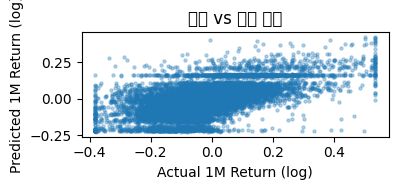

In [33]:
import matplotlib.pyplot as plt
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# ────────────────────────────────────────────────────
# 1) 모델 생성
# ────────────────────────────────────────────────────
model = RandomForestRegressor(
    n_estimators=100,   # 트리 100개
    max_depth=5,        # 트리 깊이 5 (필요시 조정)
    random_state=42,
    n_jobs=-1           # 가능한 CPU 코어 최대한 사용
)

# ────────────────────────────────────────────────────
# 2) 학습 (Train)
# ────────────────────────────────────────────────────
model.fit(X_train, y_train)

# ────────────────────────────────────────────────────
# 3) 테스트 데이터 예측
# ────────────────────────────────────────────────────
y_pred = model.predict(X_test)

# ────────────────────────────────────────────────────
# 4) 성능 평가
#    - MSE (Mean Squared Error)
#    - R2 (결정계수)
# ────────────────────────────────────────────────────
mse = mean_squared_error(y_test, y_pred)
r2  = r2_score(y_test, y_pred)

print(f"Test MSE: {mse:.6f}")
print(f"Test R2 : {r2:.4f}")

# ────────────────────────────────────────────────────
# 5) 예측 vs 실제 분포 시각화 (옵션)
# ────────────────────────────────────────────────────
plt.figure(figsize=(4, 2))
plt.scatter(y_test, y_pred, s=5, alpha=0.3)
plt.xlabel("Actual 1M Return (log)")
plt.ylabel("Predicted 1M Return (log)")
plt.title("예측 vs 실제 분포")
plt.tight_layout()
plt.show()

In [39]:
from sklearn.model_selection import GridSearchCV, TimeSeriesSplit
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, r2_score, mean_squared_error

# 1) 파라미터 후보 정의
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth':    [3, 5, 7, None],
    'min_samples_leaf': [1, 3, 5],
    'min_samples_split': [2, 5, 10]
}

# 2) TimeSeriesSplit 설정
tscv = TimeSeriesSplit(n_splits=3)

# 3) R2 scorer 래핑
r2_scorer = make_scorer(r2_score)

# 4) GridSearchCV 객체 생성
grid_search = GridSearchCV(
    estimator=RandomForestRegressor(random_state=42, n_jobs=-1),
    param_grid=param_grid,
    cv=tscv,
    scoring=r2_scorer,
    n_jobs=-1,
    verbose=2
)

# 5) 하이퍼파라미터 탐색
grid_search.fit(X_train, y_train)

# 6) 최적 파라미터 & 교차검증 성능 출력
print("=== Best Parameters ===")
print(grid_search.best_params_)

print("\n=== Best CV R2 Score ===")
print(grid_search.best_score_)

# 7) 최적 모델로 테스트 성능 확인
best_rf = grid_search.best_estimator_
y_pred_best = best_rf.predict(X_test)

test_mse_best = mean_squared_error(y_test, y_pred_best)
test_r2_best  = r2_score(y_test, y_pred_best)

print(f"\nBest RF Test MSE: {test_mse_best:.6f}")
print(f"Best RF Test R2 : {test_r2_best:.4f}")

Fitting 3 folds for each of 108 candidates, totalling 324 fits
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   0.4s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.0s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   1.2s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   1.4s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=50; total time=   1.8s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   0.9s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=2, n_estimators=100; total time=   2.7s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=50; total time=   2.0s
[CV] END max_depth=3, min_samples_leaf=1, min_samples_split=5, n_estimators=100; total time=   1.5s
[CV] END max_depth=3, min_samples_leaf=1, m

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000292 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1275
[LightGBM] [Info] Number of data points in the train set: 55044, number of used features: 5
[LightGBM] [Info] Start training from score -0.004795
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain:

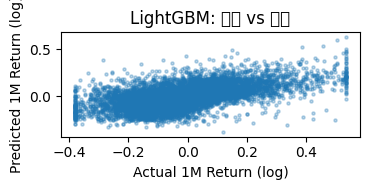

In [43]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# ────────────────────────────────────────────────────
# 0) (사전 가정) X_train, y_train, X_test, y_test가 이미 준비되어 있다고 가정
#    - 이전 병합·분리 단계에서 생성된 객체들:
#      X_train: (55044, 5)
#      y_train: (55044,)
#      X_test:  (18348, 5)
#      y_test:  (18348,)
# ────────────────────────────────────────────────────

# ────────────────────────────────────────────────────
# 1) LightGBM용 Dataset 생성
# ────────────────────────────────────────────────────
lgb_train = lgb.Dataset(X_train, label=y_train)

# ────────────────────────────────────────────────────
# 2) LightGBM 파라미터 설정
# ────────────────────────────────────────────────────
lgb_params = {
    'objective': 'regression',
    'metric':    'rmse',
    'boosting':  'gbdt',
    'learning_rate': 0.05,
    'num_leaves':    31,
    'max_depth':     5,
    'feature_fraction':  0.8,
    'bagging_fraction':  0.8,
    'bagging_freq':     5,
    'seed':            42
}

# ────────────────────────────────────────────────────
# 3) LightGBM 모델 학습
# ────────────────────────────────────────────────────
num_boost_round = 500

# verbose_eval 파라미터 없이 호출
lgb_model = lgb.train(
    lgb_params,
    lgb_train,
    num_boost_round=num_boost_round,
    valid_sets=[lgb_train],
    valid_names=['train']
)

# ────────────────────────────────────────────────────
# 4) 테스트 데이터 예측 및 성능 평가
# ────────────────────────────────────────────────────
y_pred_lgb = lgb_model.predict(X_test)

mse_lgb = mean_squared_error(y_test, y_pred_lgb)
r2_lgb  = r2_score(y_test, y_pred_lgb)

print(f"LightGBM Test MSE: {mse_lgb:.6f}")
print(f"LightGBM Test R2 : {r2_lgb:.4f}")

# ────────────────────────────────────────────────────
# 5) 예측 vs 실제 분포 시각화 (옵션)
# ────────────────────────────────────────────────────
plt.figure(figsize=(4, 2))
plt.scatter(y_test, y_pred_lgb, s=5, alpha=0.3)
plt.xlabel("Actual 1M Return (log)")
plt.ylabel("Predicted 1M Return (log)")
plt.title("LightGBM: 예측 vs 실제")
plt.tight_layout()
plt.show()

Fitting 3 folds for each of 50 candidates, totalling 150 fits
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=1.0, subsample=1.0 will be ignored. Current value: bagging_fraction=1.0
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGBM] [Warning] bagging_fraction is set=0.8, subsample=1.0 will be ignored. Current value: bagging_fraction=0.8
[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=0.6, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=0.6
[LightGB

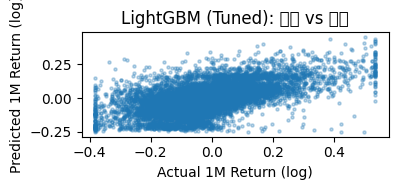

In [44]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.model_selection import RandomizedSearchCV, TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from lightgbm import LGBMRegressor

# ────────────────────────────────────────────────────
# 0) (사전 가정) X_train, y_train, X_test, y_test가 이미 준비되어 있다고 가정
# ────────────────────────────────────────────────────

# ────────────────────────────────────────────────────
# 1) LGBMRegressor 래퍼 객체 생성
# ────────────────────────────────────────────────────
lgb_est = LGBMRegressor(objective='regression', random_state=42, n_jobs=-1)

# ────────────────────────────────────────────────────
# 2) 하이퍼파라미터 후보 정의
# ────────────────────────────────────────────────────
param_dist = {
    'num_leaves':      [15, 31, 63],
    'learning_rate':   [0.01, 0.05, 0.1],
    'n_estimators':    [100, 200, 500],
    'feature_fraction': [0.6, 0.8, 1.0],
    'bagging_fraction': [0.6, 0.8, 1.0],
    'bagging_freq':     [0, 5, 10],
    'max_depth':        [3, 5, 7, -1]
}

# ────────────────────────────────────────────────────
# 3) TimeSeriesSplit 설정 (3폴드 교차검증)
# ────────────────────────────────────────────────────
tscv = TimeSeriesSplit(n_splits=3)

# ────────────────────────────────────────────────────
# 4) RandomizedSearchCV 객체 생성
# ────────────────────────────────────────────────────
rs = RandomizedSearchCV(
    estimator=lgb_est,
    param_distributions=param_dist,
    n_iter=50,         # 50개 파라미터 조합을 무작위로 테스트
    cv=tscv,
    scoring='r2',      # R²을 기준으로 최적 파라미터 선택
    random_state=42,
    n_jobs=-1,
    verbose=2
)

# ────────────────────────────────────────────────────
# 5) 하이퍼파라미터 탐색 실행
# ────────────────────────────────────────────────────
rs.fit(X_train, y_train)

# ────────────────────────────────────────────────────
# 6) 최적 파라미터 및 교차검증 성능 확인
# ────────────────────────────────────────────────────
print("=== Best LightGBM Parameters ===")
print(rs.best_params_)

print("\n=== Best CV R2 Score ===")
print(rs.best_score_)

# ────────────────────────────────────────────────────
# 7) 최적 모델로 테스트 데이터 예측 및 성능 평가
# ────────────────────────────────────────────────────
best_lgb = rs.best_estimator_
y_pred_lgb_best = best_lgb.predict(X_test)

mse_lgb_best = mean_squared_error(y_test, y_pred_lgb_best)
r2_lgb_best  = r2_score(y_test, y_pred_lgb_best)

print(f"\nBest LGB Test MSE: {mse_lgb_best:.6f}")
print(f"Best LGB Test R2 : {r2_lgb_best:.4f}")

# ────────────────────────────────────────────────────
# 8) 예측 vs 실제 분포 시각화 (옵션)
# ────────────────────────────────────────────────────
plt.figure(figsize=(4, 2))
plt.scatter(y_test, y_pred_lgb_best, s=5, alpha=0.3)
plt.xlabel("Actual 1M Return (log)")
plt.ylabel("Predicted 1M Return (log)")
plt.title("LightGBM (Tuned): 예측 vs 실제")
plt.tight_layout()
plt.show()

=== 튜닝된 LightGBM Feature Importance ===
          feature  importance
0  momentum_score         575
1    lowvol_score         317
2     value_score         206
3      size_score         146
4   quality_score         133


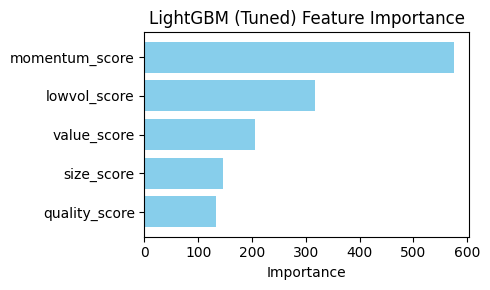

In [47]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

# ────────────────────────────────────────────────────
# (사전 가정) 앞서 RandomizedSearchCV로 튜닝한 모델(best_lgb)이 준비되어 있음
# feature_cols = ['value_score','quality_score','momentum_score','size_score','lowvol_score']
# X_train, y_train, X_test, y_test도 모두 준비되어 있음
# ────────────────────────────────────────────────────

# 1) 튜닝된 LightGBM 모델(best_lgb)에서 Feature Importance 추출
#    - importance_type='gain' (또는 'split') 중 선택 가능
importances = best_lgb.feature_importances_          # default: 'split' 기준
# 혹은 gain 기준으로 보고 싶으면: best_lgb.booster_.feature_importance(importance_type='gain')

# 2) 중요도 결과를 DataFrame으로 정리
feat_imp_df = pd.DataFrame({
    'feature': feature_cols,
    'importance': importances
}).sort_values('importance', ascending=False).reset_index(drop=True)

print("=== 튜닝된 LightGBM Feature Importance ===")
print(feat_imp_df)

# 3) 시각화 (바 차트)
plt.figure(figsize=(5, 3))
plt.barh(feat_imp_df['feature'], feat_imp_df['importance'], color='skyblue')
plt.gca().invert_yaxis()  # 중요도 높은 순으로 위에 오도록 순서 뒤집기
plt.xlabel("Importance")
plt.title("LightGBM (Tuned) Feature Importance")
plt.tight_layout()
plt.show()

[LightGBM] [Warning] bagging_freq is set=0, subsample_freq=0 will be ignored. Current value: bagging_freq=0
[LightGBM] [Warning] feature_fraction is set=1.0, colsample_bytree=1.0 will be ignored. Current value: feature_fraction=1.0
[LightGBM] [Warning] bagging_fraction is set=0.6, subsample=1.0 will be ignored. Current value: bagging_fraction=0.6
count    18348.000000
mean        -0.002403
std          0.084419
min         -0.222572
25%         -0.047489
50%         -0.006433
75%          0.032644
max          0.573612
Name: pred_return, dtype: float64
      회사명  pred_return  signal
0    시노펙스     0.573612       1
1    대동금속     0.504467       1
2    원익큐브     0.496472       1
3  한울소재과학     0.411212       1
4    상신전자     0.398375       1
5    플레이디     0.397439       1
6     SBS     0.389162       1
7   제주반도체     0.388520       1
8    디티앤씨     0.366842       1
9   일진디스플     0.336409       1
==== Long-Only 전략(상위 30%) 백테스트 결과 ====
누적 수익률 (2024년): 0.2662  (약 26.62% )
샤프비 (월간): 1.9813
최대 낙폭   

/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_78793/2723859305.py:77: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  backtest_df = backtest_df.groupby('기준월', group_keys=False).apply(long_only_signal)


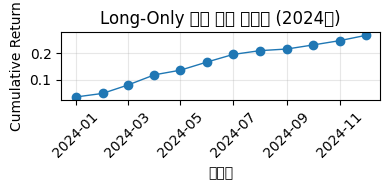

In [52]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score

# ────────────────────────────────────────────────────
# 0) 사전 가정
# ────────────────────────────────────────────────────
# (1) test_merged: 테스트 기간(2024년) 전체 데이터프레임
#     - 이미 'value_score','quality_score','momentum_score','size_score','lowvol_score'
#       그리고 '1개월수익률_log' (실제 로그 수익) 컬럼이 포함되어 있다고 가정합니다.
#
# (2) best_lgb (튜닝된 LightGBM 모델)가 준비되어 있고,
#     "테스트 피처(X_test)"도 준비되어 있어야 합니다.
#     예를 들어:
#       X_test = test_merged[['value_score','quality_score','momentum_score','size_score','lowvol_score']]
#
# (3) best_lgb.predict(X_test) 를 이미 수행하여, 
#     '1개월수익률_log_pred' 라는 예측 로그 수익 컬럼을 test_merged 에 추가할 수 있어야 합니다.
#
# 만약 아직 예측 컬럼이 없다면, 아래 1단계(예측값 생성)부터 실행하세요.
# ────────────────────────────────────────────────────

# 1) (만약 아직 없다면) "1개월수익률_log_pred" 칼럼을 test_merged에 추가
# -------------------------------------------------------------
# 아래 두 줄을 실행해서, test_merged에 예측 컬럼을 생성해 주세요.
X_test = test_merged[['value_score','quality_score','momentum_score','size_score','lowvol_score']]
test_merged['1개월수익률_log_pred'] = best_lgb.predict(X_test)
#
# 예시:
# X_test = test_merged[['value_score','quality_score','momentum_score','size_score','lowvol_score']]
# test_merged['1개월수익률_log_pred'] = best_lgb.predict(X_test)

# (위 두 줄을 이미 실행하셨다면 다음 단계로 넘어가세요.)


# 2) backtest_df 정의
# -------------------------------------------------------------
# test_merged 자체를 copy해서 backtest_df로 놓으면, 
# 나중에 원본 test_merged가 훼손되지 않아 안전합니다.
backtest_df = test_merged.copy()

# (확인) 컬럼이 정확히 존재하는지 한 번만 확인해 보세요.
# print(backtest_df.columns)

# ────────────────────────────────────────────────────
# 3) 예측값(pred_return) → “원본 로그 수익 → 일반(비로그) 수익”으로 변환
# ────────────────────────────────────────────────────
# 예측된 값(best_lgb.predict)은 “로그수익” 형태이므로, 이를 expm1으로 역변환하면 실제 퍼센트 수익률이 나옵니다.
backtest_df['pred_return'] = np.expm1(backtest_df['1개월수익률_log_pred'])

# (확인) pred_return 컬럼 분포
print(backtest_df['pred_return'].describe())


# ────────────────────────────────────────────────────
# 4) Long-Only Signal 생성: “상위 30%만 롱(=1), 나머지는 0”
# ────────────────────────────────────────────────────
def long_only_signal(df, top_quantile=0.30):
    """
    df: 한 달치 데이터프레임(동일한 '기준월' 값을 가진 행들)
    top_quantile: 상위 몇 %를 롱으로 잡을지 (기본: 0.30 → 상위 30%)
    """
    df = df.copy()
    n = len(df)
    cutoff = int(np.floor(n * top_quantile))
    
    # pred_return 기준 내림차순 정렬
    df = df.sort_values('pred_return', ascending=False).reset_index(drop=True)
    
    # 상위 cutoff개만 signal=1, 나머지 0
    df['signal'] = 0
    df.loc[:cutoff-1, 'signal'] = 1
    return df

# 월별(기준월별)로 long_only_signal을 적용
backtest_df = backtest_df.groupby('기준월', group_keys=False).apply(long_only_signal)

# (확인) 예를 들어 첫 달(2024-01-01)만 살펴보기
print(backtest_df[backtest_df['기준월']=='2024-01-01'][['회사명','pred_return','signal']].head(10))


# ────────────────────────────────────────────────────
# 5) 실제 수익률(real_rtn) 계산: “로그수익 → 일반 수익”으로 변환
# ────────────────────────────────────────────────────
# 이미 backtest_df에 '1개월수익률_log'가 있으므로 expm1으로 일반 수익률(%)을 구합니다.
backtest_df['real_rtn'] = np.expm1(backtest_df['1개월수익률_log'])


# ────────────────────────────────────────────────────
# 6) 전략 수익률 계산: signal × real_rtn
# ────────────────────────────────────────────────────
backtest_df['strat_rtn'] = backtest_df['signal'] * backtest_df['real_rtn']


# ────────────────────────────────────────────────────
# 7) 월별 평균 전략 수익률 및 누적수익률 계산
# ────────────────────────────────────────────────────
monthly_rtn = backtest_df.groupby('기준월')['strat_rtn'].mean()
cum_rtn = (1 + monthly_rtn).cumprod() - 1

# ────────────────────────────────────────────────────
# 8) 성과 지표 산출
# ────────────────────────────────────────────────────
#  8-1) 누적 수익률 (마지막 값)
total_cum_rtn = cum_rtn.iloc[-1]

#  8-2) 샤프비 (월간 기준, 무위험금리 0 가정)
sharpe_monthly = monthly_rtn.mean() / monthly_rtn.std()

#  8-3) 최대 낙폭(Max Drawdown) 계산
#       - 누적수익률 곡선(high-water mark)에서 최대 하락폭을 찾는 방법
hwm = cum_rtn.cummax()
drawdown = (cum_rtn - hwm) / hwm
max_drawdown = drawdown.min()

print("==== Long-Only 전략(상위 30%) 백테스트 결과 ====")
print(f"누적 수익률 (2024년): {total_cum_rtn:.4f}  (약 {total_cum_rtn*100:.2f}% )")
print(f"샤프비 (월간): {sharpe_monthly:.4f}")
print(f"최대 낙폭      : {max_drawdown:.4f}  (약 {max_drawdown*100:.2f}% )")


# ────────────────────────────────────────────────────
# 9) 시각화: 누적수익률 차트
# ────────────────────────────────────────────────────
plt.figure(figsize=(4, 2))
plt.plot(cum_rtn.index, cum_rtn.values, marker='o', linewidth=1)
plt.title("Long-Only 전략 누적 수익률 (2024년)")
plt.xlabel("기준월")
plt.ylabel("Cumulative Return")
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

==== Long-Short 전략(상위 30% 롱 / 하위 30% 숏) ====
누적 수익률: 0.6200  (≈ 62.00%)
샤프비 (월간): 4.9658
최대 낙폭: 0.0000  (≈ 0.00%)


/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_78793/1279869890.py:17: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  backtest_ls = backtest_df.groupby('기준월', group_keys=False).apply(long_short_signal)


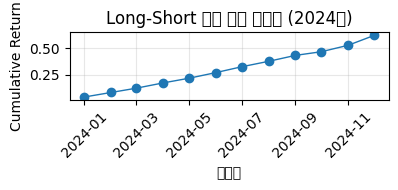

In [53]:
# 상위 30% → signal = +1  
# 하위 30% → signal = -1  
# 중간 40% → signal = 0  
def long_short_signal(df, top_q=0.3, bottom_q=0.3):
    n = len(df)
    cutoff_top = int(np.floor(n * top_q))
    cutoff_bot = int(np.floor(n * bottom_q))
    
    df = df.copy().sort_values('pred_return', ascending=False).reset_index(drop=True)
    df['signal'] = 0
    # 상위 30%
    df.loc[:cutoff_top-1, 'signal'] = 1
    # 하위 30%
    df.loc[n-cutoff_bot:, 'signal'] = -1
    return df

backtest_ls = backtest_df.groupby('기준월', group_keys=False).apply(long_short_signal)
backtest_ls['strat_rtn'] = backtest_ls['signal'] * backtest_ls['real_rtn']

monthly_ls = backtest_ls.groupby('기준월')['strat_rtn'].mean()
cum_ls     = (1 + monthly_ls).cumprod() - 1

# 성과 지표
total_cum_ls  = cum_ls.iloc[-1]
sharpe_ls     = monthly_ls.mean() / monthly_ls.std()
hwm_ls        = cum_ls.cummax()
drawdown_ls   = (cum_ls - hwm_ls) / hwm_ls
max_dd_ls     = drawdown_ls.min()

print("==== Long-Short 전략(상위 30% 롱 / 하위 30% 숏) ====")
print(f"누적 수익률: {total_cum_ls:.4f}  (≈ {total_cum_ls*100:.2f}%)")
print(f"샤프비 (월간): {sharpe_ls:.4f}")
print(f"최대 낙폭: {max_dd_ls:.4f}  (≈ {max_dd_ls*100:.2f}%)")

plt.figure(figsize=(4,2))
plt.plot(cum_ls.index, cum_ls.values, marker='o', linewidth=1)
plt.title("Long-Short 전략 누적 수익률 (2024년)")
plt.xlabel("기준월")
plt.ylabel("Cumulative Return")
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


==== Risk Parity + Hybrid 전략 결과 (2024년) ====
누적 수익률: 0.0669  (≈ 6.69% )
샤프비 (월간): 0.1869
최대 낙폭      : -0.5946  (≈ -59.46% )


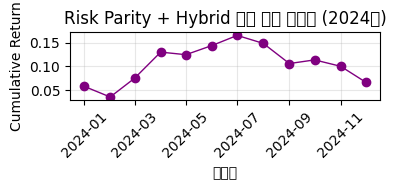

In [58]:
import numpy as np
import pandas as pd
import cvxpy as cp
import matplotlib.pyplot as plt

# ─────────────────────────────────────────────────────────────────────────────
# 0) 사전 가정 및 데이터 로드
# ─────────────────────────────────────────────────────────────────────────────
# (아래 두 줄은 실제 파일 경로 혹은 이미 메모리에 로드된 DataFrame 변수명으로 바꿔서 사용하세요.)
# train_merged = pd.read_csv('train_merged.csv', parse_dates=['기준월'])
# test_merged  = pd.read_csv('test_merged.csv',  parse_dates=['기준월'])

# 1) train_merged에 실제 수익률(real_rtn) 컬럼 추가
train_merged['real_rtn'] = np.expm1(train_merged['1개월수익률_log'])

# 2) test_merged에 예측 수익(pred_return) 및 실제 수익(real_rtn) 컬럼 추가
test_merged['pred_return'] = np.expm1(test_merged['1개월수익률_log_pred'])
test_merged['real_rtn']    = np.expm1(test_merged['1개월수익률_log'])

# ─────────────────────────────────────────────────────────────────────────────
# 1) 팩터별 과거 Return 시계열 계산 (2021~2023)
# ─────────────────────────────────────────────────────────────────────────────
def compute_factor_strategy_returns(df_month, factor_col, top_quantile=0.30):
    """
    df_month: 특정 기준월의 train_merged DataFrame
    factor_col: 예) 'value_score'
    top_quantile: 상위 몇 % 종목을 Long-Only 사용할지
    real_rtn 컬럼을 이용해 해당 팩터 전략의 월별 평균 수익률을 반환
    """
    n = len(df_month)
    cutoff = int(np.floor(n * top_quantile))
    subset = df_month.nlargest(cutoff, factor_col)
    return subset['real_rtn'].mean()

# train 기간의 월별 기준월 목록
train_months = train_merged['기준월'].sort_values().unique()

# 팩터 컬럼 리스트
factor_cols = ['value_score', 'momentum_score', 'quality_score', 'size_score', 'lowvol_score']

# 월별 팩터 전략 수익률을 저장할 리스트
factor_returns = []

for month in train_months:
    month_df = train_merged[train_merged['기준월'] == month]
    rtns = {
        '기준월': month,
        'value_rtn':    compute_factor_strategy_returns(month_df, 'value_score'),
        'momentum_rtn': compute_factor_strategy_returns(month_df, 'momentum_score'),
        'quality_rtn':  compute_factor_strategy_returns(month_df, 'quality_score'),
        'size_rtn':     compute_factor_strategy_returns(month_df, 'size_score'),
        'lowvol_rtn':   compute_factor_strategy_returns(month_df, 'lowvol_score')
    }
    factor_returns.append(rtns)

factor_rtn_df = pd.DataFrame(factor_returns).set_index('기준월')

# ─────────────────────────────────────────────────────────────────────────────
# 2) Rolling 12개월 공분산 행렬 계산 (2022년 이후부터 사용)
# ─────────────────────────────────────────────────────────────────────────────
rolling_window = 12
cov_matrices = {}  # key: 기준월, value: 5×5 공분산 행렬

for i in range(rolling_window, len(factor_rtn_df) + 1):
    window = factor_rtn_df.iloc[i - rolling_window : i]
    date_t = window.index[-1]  # 해당 달 기준월
    # ① 공분산 계산
    cov_raw = window.cov().values
    # ② 극도로 작은 값으로 정규화하여 PSD 혹은 PD 상태 보장
    cov_pd = cov_raw + np.eye(cov_raw.shape[0]) * 1e-6
    cov_matrices[date_t] = cov_pd

# ─────────────────────────────────────────────────────────────────────────────
# 3) ERC(Equal Risk Contribution) 가중치 계산 함수 (try/except 포함)
# ─────────────────────────────────────────────────────────────────────────────
def compute_erc_weights(cov_matrix):
    """
    cov_matrix: numpy array, shape (5, 5), PSD(양의 준정부호)
    정상적으로 해가 안 나오면 등가중([0.2,...,0.2]) 반환
    """
    n = cov_matrix.shape[0]
    w = cp.Variable(n, nonneg=True)
    portfolio_vol = cp.sqrt(cp.quad_form(w, cov_matrix))
    risk_contribs = cp.multiply(w, cov_matrix @ w)
    target_contrib = portfolio_vol / n

    obj = cp.Minimize(cp.sum_squares(risk_contribs - target_contrib))
    constraints = [cp.sum(w) == 1]

    try:
        prob = cp.Problem(obj, constraints)
        prob.solve(solver=cp.SCS, verbose=False)
        w_opt = w.value
        # 만약 해가 None 이거나 음수가 포함되면 fallback
        if w_opt is None or np.any(w_opt < 0):
            return np.ones(n) / n
        return w_opt
    except Exception:
        # DCPError 등 예외 발생 시 등가중 반환
        return np.ones(n) / n

# ─────────────────────────────────────────────────────────────────────────────
# 4) 2024년 Hybrid 전략 백테스트
# ─────────────────────────────────────────────────────────────────────────────

hybrid_monthly_returns = []  # {'기준월': date, 'hybrid_rtn': float}

# 테스트 기간 기준월 목록 (2024년만)
test_months = test_merged['기준월'].sort_values().unique()

for month in test_months:
    # ─────────────────────────────────────────────────────────────────────────
    # 4-1) ERC 비중 계산
    cov_date = pd.to_datetime(f"{month.year-1}-{month.month:02d}-01") + pd.DateOffset(months=11)
    cov_matrix = cov_matrices.get(cov_date)
    if cov_matrix is None:
        # 만약 해당 월 공분산이 없다면 그냥 등가중([0.2,...,0.2]) 사용
        erc_w = np.ones(len(factor_cols)) / len(factor_cols)
    else:
        erc_w = compute_erc_weights(cov_matrix)  # 길이 5 벡터

    # ─────────────────────────────────────────────────────────────────────────
    # 4-2) 팩터별 Alpha 계산 (test_merged에서 당월 기준)
    month_df = test_merged[test_merged['기준월'] == month]
    cutoff = int(np.floor(len(month_df) * 0.30))
    alphas = []
    for col in factor_cols:
        top_subset = month_df.nlargest(cutoff, col)
        alpha_i = top_subset['pred_return'].mean()
        alphas.append(alpha_i)
    alpha_vec = np.array(alphas)

    # ─────────────────────────────────────────────────────────────────────────
    # 4-3) Hybrid 비중 계산 (β 파라미터 설정: 0.5)
    beta = 0.5
    hybrid_w = erc_w * (1 + beta * alpha_vec)
    # hybrid_w가 모두 0 또는 음수 나올 수 있으니, 최소값 보정 후 정규화
    hybrid_w = np.maximum(hybrid_w, 0)
    if hybrid_w.sum() == 0:
        hybrid_w = np.ones(len(factor_cols)) / len(factor_cols)
    else:
        hybrid_w /= hybrid_w.sum()

    # ─────────────────────────────────────────────────────────────────────────
    # 4-4) 팩터 비중 → 종목별 비중 할당
    stock_weights = {}  # key: 종목코드, value: 누적 비중

    for i, col in enumerate(factor_cols):
        subset = month_df.nlargest(cutoff, col)
        n_stocks = len(subset)
        if n_stocks == 0:
            continue
        w_each = hybrid_w[i] / n_stocks
        for code in subset['종목코드']:
            stock_weights[code] = stock_weights.get(code, 0) + w_each

    # ─────────────────────────────────────────────────────────────────────────
    # 4-5) 최종 종목 비중 DataFrame 생성 후, 당월 실현 수익 계산
    stock_w_df = pd.DataFrame({
        '종목코드': list(stock_weights.keys()),
        'weight':   list(stock_weights.values())
    })

    # 당월 종목별 실제 수익률(real_rtn)과 merge
    month_returns = month_df[['종목코드', 'real_rtn']].copy()
    merged = pd.merge(stock_w_df, month_returns, on='종목코드', how='inner')

    # 포트폴리오 월별 수익 = sum(weight * real_rtn)
    hybrid_rtn = (merged['weight'] * merged['real_rtn']).sum()
    hybrid_monthly_returns.append({'기준월': month, 'hybrid_rtn': hybrid_rtn})

# 4-6) 결과 DataFrame 생성
hybrid_rtn_df = pd.DataFrame(hybrid_monthly_returns).set_index('기준월')

# 4-7) 누적 수익률 및 성과 지표 계산
monthly_hybrid_rtn = hybrid_rtn_df['hybrid_rtn']
cum_hybrid_rtn     = (1 + monthly_hybrid_rtn).cumprod() - 1

total_cum_hybrid  = cum_hybrid_rtn.iloc[-1]
sharpe_hybrid     = monthly_hybrid_rtn.mean() / monthly_hybrid_rtn.std()
hwm_hybrid        = cum_hybrid_rtn.cummax()
dd_hybrid         = (cum_hybrid_rtn - hwm_hybrid) / hwm_hybrid
max_dd_hybrid     = dd_hybrid.min()

print("\n==== Risk Parity + Hybrid 전략 결과 (2024년) ====")
print(f"누적 수익률: {total_cum_hybrid:.4f}  (≈ {total_cum_hybrid*100:.2f}% )")
print(f"샤프비 (월간): {sharpe_hybrid:.4f}")
print(f"최대 낙폭      : {max_dd_hybrid:.4f}  (≈ {max_dd_hybrid*100:.2f}% )")

# 4-8) 누적 수익률 시각화
plt.figure(figsize=(4, 2))
plt.plot(cum_hybrid_rtn.index, cum_hybrid_rtn.values, marker='o', linewidth=1, color='purple')
plt.title("Risk Parity + Hybrid 전략 누적 수익률 (2024년)")
plt.xlabel("기준월")
plt.ylabel("Cumulative Return")
plt.grid(alpha=0.3)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

팩터 스코어 기반 클러스터링

In [63]:
full_df = pd.concat([train_merged, test_merged], axis=0).reset_index(drop=True)
X_factors = full_df[['value_score','quality_score','momentum_score','size_score','lowvol_score']].values

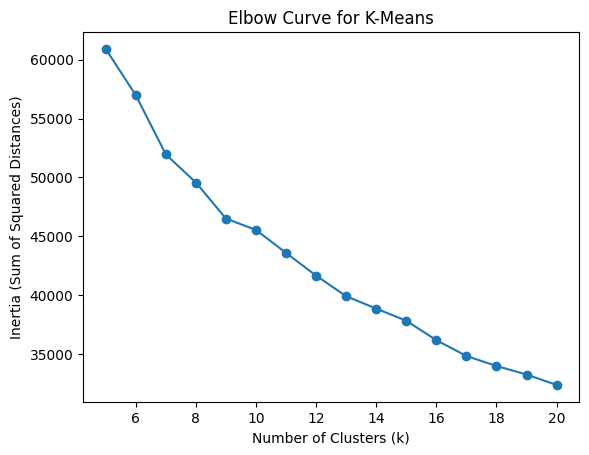

In [64]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt

inertias = []
K_candidates = range(5, 21)  # 5개~20개 클러스터 후보
for k in K_candidates:
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(X_factors)
    inertias.append(km.inertia_)

plt.plot(K_candidates, inertias, marker='o')
plt.xlabel('Number of Clusters (k)')
plt.ylabel('Inertia (Sum of Squared Distances)')
plt.title('Elbow Curve for K-Means')
plt.show()

In [67]:
import pandas as pd
from sklearn.cluster import KMeans

# ──────────────────────────────────────────────────────────────────────────
# (1) train_merged, test_merged가 이미 준비된 상태
# ──────────────────────────────────────────────────────────────────────────

# 1-1) 풀 데이터(full_df) 만들기
full_df = pd.concat([train_merged, test_merged], axis=0).reset_index(drop=True)

# 1-2) 팩터 스코어 5개를 행렬 형태로 뽑기
X_factors = full_df[['value_score','quality_score','momentum_score','size_score','lowvol_score']].values

# 1-3) KMeans 학습 (k = 10)
best_k = 10
km10 = KMeans(n_clusters=best_k, random_state=42)
full_df['cluster_id'] = km10.fit_predict(X_factors)

# (Optional) centroids 확인
# centroids = km10.cluster_centers_
# print("Cluster centroids:\n", centroids)

# 1-4) cluster_id를 train_merged, test_merged에 나눠서 매핑
train_merged = full_df[ full_df['기준월'] < '2024-01-01' ].copy()
test_merged  = full_df[ full_df['기준월'] >= '2024-01-01' ].copy()

# 이제 train_merged, test_merged에 'cluster_id' 컬럼이 포함되어 있습니다.
print("Train shape:", train_merged.shape, "→ cluster_id unique:", train_merged['cluster_id'].nunique())
print("Test  shape:", test_merged.shape,  "→ cluster_id unique:", test_merged['cluster_id'].nunique())

Train shape: (55044, 79) → cluster_id unique: 10
Test  shape: (18348, 79) → cluster_id unique: 10



==== Beta별 클러스터 중립 + Hybrid(베타 헷지 생략) 결과 (2024년) ====

    beta  cum_return_%   sharpe  max_dd_%
  0.0000       10.2697   0.2946  -44.3793
  0.1000       10.3836   0.2976  -44.1600
  0.2000       10.4971   0.3005  -43.9428
  0.3000       10.6103   0.3035  -43.7279
  0.4000       10.7231   0.3065  -43.5150
  0.5000       10.8355   0.3094  -43.3043
  0.6000       10.9468   0.3124  -43.0956
  0.7000       11.0546   0.3152  -42.8889


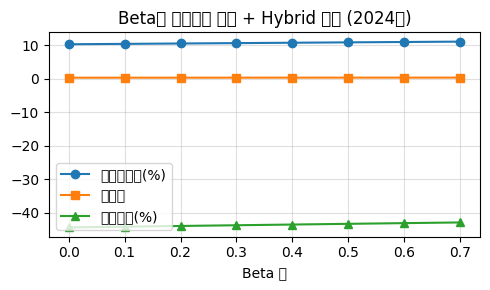

In [71]:
import numpy as np
import pandas as pd
import cvxpy as cp

# ───────────────────────────────────────────────────────────────────────────
# 사전 가정: 아래 객체들이 이미 존재해야 합니다.
#  1) train_merged, test_merged (cluster_id 포함)
#  2) factor_cols = ['value_score','momentum_score','quality_score','size_score','lowvol_score']
#  3) cov_matrices : {datetime → 5×5 공분산 행렬 (np.ndarray)}
#  4) code_to_beta_dict : {종목코드(int) → beta(float)} 사전
#  5) kospi_rtn_df : ['기준월'(datetime), 'kospi_rtn'(float)] DataFrame
# ───────────────────────────────────────────────────────────────────────────

# (1) ERC 가중치를 계산해 주는 함수 (이전과 동일)
def compute_erc_weights(cov_matrix):
    n = cov_matrix.shape[0]
    w = cp.Variable(n, nonneg=True)
    portfolio_vol = cp.sqrt(cp.quad_form(w, cov_matrix))
    risk_contribs  = cp.multiply(w, cov_matrix @ w)
    target_contrib = portfolio_vol / n

    obj = cp.Minimize(cp.sum_squares(risk_contribs - target_contrib))
    constraints = [cp.sum(w) == 1]

    try:
        prob = cp.Problem(obj, constraints)
        prob.solve(solver=cp.SCS, verbose=False)
        w_opt = w.value
        if w_opt is None or np.any(w_opt < 0):
            return np.ones(n) / n
        return w_opt
    except Exception:
        # 최적화 실패 시 균등 가중치 리턴
        return np.ones(n) / n

# (2) 결과를 저장할 빈 리스트 정의
results = []

# (3) 실험할 beta 값 리스트
beta_list = [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7]

# ───────────────────────────────────────────────────────────────────────────
# (4) beta를 하나씩 바꿔가며 Backtest 수행
# ───────────────────────────────────────────────────────────────────────────
for beta in beta_list:
    hybrid_monthly_returns = []

    # test_merged 의 모든 월을 순회
    test_months = test_merged['기준월'].sort_values().unique()

    for month in test_months:
        # ─────────────────────────────────────────────────────────────────────
        # 4-1) 해당 월의 ERC 비중 계산 (과거 12개월 공분산 사용)
        # ─────────────────────────────────────────────────────────────────────
        cov_date   = pd.to_datetime(f"{month.year-1}-{month.month:02d}-01") + pd.DateOffset(months=11)
        cov_matrix = cov_matrices.get(cov_date)
        if cov_matrix is None:
            erc_w = np.ones(len(factor_cols)) / len(factor_cols)
        else:
            erc_w = compute_erc_weights(cov_matrix)

        # ─────────────────────────────────────────────────────────────────────
        # 4-2) 팩터별 알파(Alpha) 계산 (test_merged에서 “pred_return” 대신 “real_rtn” 을 사용해도 무방)
        #      → 여기에선 편의상 “pred_return”으로 상위 30% 평균 수익을 구합니다.
        # ─────────────────────────────────────────────────────────────────────
        month_df = test_merged[test_merged['기준월'] == month]
        cutoff   = int(np.floor(len(month_df) * 0.30))  # 상위 30%

        alphas = []
        for col in factor_cols:
            top_subset = month_df.nlargest(cutoff, col)
            alpha_i    = top_subset['pred_return'].mean()
            alphas.append(alpha_i)
        alpha_vec = np.array(alphas)

        # ─────────────────────────────────────────────────────────────────────
        # 4-3) Hybrid Weight 계산: erc_w * (1 + beta * alpha)
        # ─────────────────────────────────────────────────────────────────────
        hybrid_w = erc_w * (1 + beta * alpha_vec)
        hybrid_w = np.maximum(hybrid_w, 0)  # 음수 방지
        if hybrid_w.sum() == 0:
            hybrid_w = np.ones(len(factor_cols)) / len(factor_cols)
        else:
            hybrid_w /= hybrid_w.sum()

        # ─────────────────────────────────────────────────────────────────────
        # 4-4) 팩터 → 종목 비중 배분 (클러스터 중립 적용)
        # ─────────────────────────────────────────────────────────────────────
        stock_weights = {}
        for i, col in enumerate(factor_cols):
            subset   = month_df.nlargest(cutoff, col)
            n_stocks = len(subset)
            if n_stocks == 0:
                continue
            w_each = hybrid_w[i] / n_stocks
            for idx, row in subset.iterrows():
                code    = row['종목코드']
                cluster = row['cluster_id']
                stock_weights.setdefault(code, {'cluster': cluster, 'weight': 0.0})
                stock_weights[code]['weight'] += w_each

        stock_w_df = pd.DataFrame.from_dict(stock_weights, orient='index')
        stock_w_df.index.name = '종목코드'
        stock_w_df = stock_w_df.reset_index()[['종목코드','cluster','weight']]

        # ─────────────────────────────────────────────────────────────────────
        # 4-5) 클러스터별 최대 비중 제한 (max_cluster_w = 0.20)
        # ─────────────────────────────────────────────────────────────────────
        max_cluster_w = 0.20
        cluster_sum   = stock_w_df.groupby('cluster')['weight'].sum()
        shrink_ratios = {}
        for cluster, total_w in cluster_sum.items():
            shrink_ratios[cluster] = (max_cluster_w / total_w) if (total_w > max_cluster_w) else 1.0

        stock_w_df['weight_adj'] = stock_w_df.apply(
            lambda r: r['weight'] * shrink_ratios[r['cluster']], axis=1
        )

        # ─────────────────────────────────────────────────────────────────────
        # 4-6) 클러스터 제한 후 Weight 정규화
        # ─────────────────────────────────────────────────────────────────────
        total_after = stock_w_df['weight_adj'].sum()
        if total_after <= 0:
            stock_w_df['weight'] = 1.0 / len(stock_w_df)
        else:
            stock_w_df['weight'] = stock_w_df['weight_adj'] / total_after

        # ─────────────────────────────────────────────────────────────────────
        # 4-7) (선택 사항) 간단 베타 헷지 적용
        #       → 이번 예제에서는 생략하고 “현물(portfolio) → 수익만” 계산
        # ─────────────────────────────────────────────────────────────────────
        merged = pd.merge(
            stock_w_df[['종목코드','weight']],
            month_df[['종목코드','real_rtn']],
            on='종목코드',
            how='inner'
        )
        spot_return  = (merged['weight'] * merged['real_rtn']).sum()
        hybrid_rtn   = spot_return  # 베타 헷지는 아직 생략
        hybrid_monthly_returns.append({'기준월': month, 'hybrid_rtn': hybrid_rtn})

    # ───────────────────────────────────────────────────────────────────────────
    # 4-8) 월별 수익 → 누적 수익률, 샤프비, 최대 낙폭 계산
    # ───────────────────────────────────────────────────────────────────────────
    hybrid_rtn_df  = pd.DataFrame(hybrid_monthly_returns).set_index('기준월')
    monthly_hybrid = hybrid_rtn_df['hybrid_rtn']
    cum_hybrid     = (1 + monthly_hybrid).cumprod() - 1

    total_hybrid  = cum_hybrid.iloc[-1]
    sharpe_hybrid = monthly_hybrid.mean() / (monthly_hybrid.std() + 1e-9)
    hwm_hybrid    = cum_hybrid.cummax()
    dd_hybrid     = (cum_hybrid - hwm_hybrid) / (hwm_hybrid + 1e-9)
    max_dd_hybrid = dd_hybrid.min()

    # ───────────────────────────────────────────────────────────────────────────
    # 4-9) 결과를 리스트에 저장
    # ───────────────────────────────────────────────────────────────────────────
    results.append({
        'beta':           beta,
        'cum_return':     total_hybrid,
        'sharpe':         sharpe_hybrid,
        'max_drawdown':   max_dd_hybrid
    })

# ───────────────────────────────────────────────────────────────────────────────
# (5) 최종 결과를 DataFrame으로 정리하여 출력
# ───────────────────────────────────────────────────────────────────────────────
result_df = pd.DataFrame(results)
result_df['cum_return_%']   = result_df['cum_return'] * 100
result_df['max_dd_%']       = result_df['max_drawdown'] * 100

pd.set_option('display.float_format', lambda x: f"{x:>8.4f}")
print("\n==== Beta별 클러스터 중립 + Hybrid(베타 헷지 생략) 결과 (2024년) ====\n")
print(result_df[['beta', 'cum_return_%', 'sharpe', 'max_dd_%']].to_string(index=False))

# ───────────────────────────────────────────────────────────────────────────────
# (6) 그래프로 시각화 (원하신다면)
# ───────────────────────────────────────────────────────────────────────────────
import matplotlib.pyplot as plt

plt.figure(figsize=(5, 3))
plt.plot(result_df['beta'], result_df['cum_return_%'], marker='o', label='누적수익률(%)')
plt.plot(result_df['beta'], result_df['sharpe'],      marker='s', label='샤프비')
plt.plot(result_df['beta'], result_df['max_dd_%'],    marker='^', label='최대낙폭(%)')
plt.xlabel('Beta 값')
plt.title('Beta별 클러스터 중립 + Hybrid 성과 (2024년)')
plt.grid(alpha=0.4)
plt.legend(loc='lower left')
plt.tight_layout()
plt.show()

피처 엔지니어링 + 하이퍼파라미터 튜닝

In [88]:
import pandas as pd
import numpy as np

# ────────────────────────────────────────────────────────────
# 1) 원본 전체 데이터 로드
# ────────────────────────────────────────────────────────────
# (stock_0.3ver.csv에는 이미 2021~2024월별 모든 피처가 들어 있습니다)
df_full = pd.read_csv('/Users/gun/Desktop/경종설/국내/stock_0.3ver.csv', parse_dates=['기준월'])

# ────────────────────────────────────────────────────────────
# 2) 산업 중립화 Z-score 함수 정의
# ────────────────────────────────────────────────────────────
def industry_zscore(df, col, industry_col='산업군'):
    grp = df.groupby(industry_col)[col]
    mean_ind = grp.transform('mean')
    std_ind  = grp.transform('std').replace(0, np.nan)
    z = (df[col] - mean_ind) / std_ind
    return z.fillna(0.0)

# ────────────────────────────────────────────────────────────
# 3) 팩터별 산업 중립화 Z-score 계산 및 스코어 생성
# ────────────────────────────────────────────────────────────
# 3.1 Value 팩터
df_full['PER_z']           = industry_zscore(df_full, 'PER')
df_full['PBR_z']           = industry_zscore(df_full, 'PBR')
df_full['PSR_z']           = industry_zscore(df_full, 'PSR')
df_full['roe_per_ratio_z'] = industry_zscore(df_full, 'roe_per_ratio')
df_full['value_score']     = df_full[['PER_z','PBR_z','PSR_z','roe_per_ratio_z']].mean(axis=1)

# 3.2 Quality 팩터
df_full['ROE_z']       = industry_zscore(df_full, 'ROE')
df_full['영업이익률_z']  = industry_zscore(df_full, '영업이익률')
df_full['EPS_z']       = industry_zscore(df_full, 'EPS')
df_full['부채비율_z']    = industry_zscore(df_full, '부채비율')
df_full['당기순이익_z']  = industry_zscore(df_full, '당기순이익')
df_full['영업이익_z']    = industry_zscore(df_full, '영업이익')
df_full['자본총계_z']    = industry_zscore(df_full, '자본총계')
df_full['quality_score'] = df_full[['ROE_z','영업이익률_z','EPS_z','부채비율_z','당기순이익_z','영업이익_z','자본총계_z']].mean(axis=1)

# 3.3 Momentum 팩터
df_full['1M_z']       = industry_zscore(df_full, '1개월수익률')
df_full['3M_z']       = industry_zscore(df_full, '3개월수익률')
df_full['6M_z']       = industry_zscore(df_full, '6개월수익률')
df_full['12M_z']      = industry_zscore(df_full, '12개월수익률')
df_full['m_diff_z']   = industry_zscore(df_full, 'momentum_diff')
df_full['m_accel_z']  = industry_zscore(df_full, 'momentum_accel')
df_full['m_slope_z']  = industry_zscore(df_full, 'momentum_trend_slope')
df_full['trend_cnt_z'] = industry_zscore(df_full, 'trend_positive_count')
df_full['avg_vol_z']  = industry_zscore(df_full, '평균거래량증가율')
df_full['momentum_score'] = df_full[['1M_z','3M_z','6M_z','12M_z','m_diff_z','m_accel_z','m_slope_z','trend_cnt_z','avg_vol_z']].mean(axis=1)

# 3.4 Size 팩터
df_full['mktcap_z']   = industry_zscore(df_full, '시가총액')
df_full['shares_z']   = industry_zscore(df_full, '발행주식수')
df_full['assets_z']   = industry_zscore(df_full, '자산총계')
df_full['capital_z']  = industry_zscore(df_full, '자본금')
df_full['revenue_z']  = industry_zscore(df_full, '매출액')
df_full['liab_z']     = industry_zscore(df_full, '부채총계')
df_full['size_score'] = df_full[['mktcap_z','shares_z','assets_z','capital_z','revenue_z','liab_z']].mean(axis=1)

# 3.5 Low Volatility 팩터 (부호 반전)
df_full['vol3_z']    = industry_zscore(df_full, '3개월변동성')
df_full['vol12_z']   = industry_zscore(df_full, '12개월변동성')
df_full['r_vol_z']   = industry_zscore(df_full, 'return_vol_ratio')
df_full['v_spread_z']= industry_zscore(df_full, 'volatility_spread')
df_full['mcv_z']     = industry_zscore(df_full, 'monthly_return_cv')
df_full['turn_z']    = industry_zscore(df_full, '거래회전율')
df_full['lowvol_score'] = - df_full[['vol3_z','vol12_z','r_vol_z','v_spread_z','mcv_z','turn_z']].mean(axis=1)

# 3.6 통합 팩터 스코어
df_full['final_score'] = df_full[['value_score','quality_score','momentum_score','size_score','lowvol_score']].mean(axis=1)

# ────────────────────────────────────────────────────────────
# 4) 로그 수익률 추가
# ────────────────────────────────────────────────────────────
df_full['1개월수익률_log'] = np.log1p(df_full['1개월수익률'])

# ────────────────────────────────────────────────────────────
# 5) Train / Test 분리 (2021~2023 → Train, 2024 → Test)
# ────────────────────────────────────────────────────────────
train_df = df_full[df_full['기준월'] < '2024-01-01'].copy()
test_df  = df_full[df_full['기준월'] >= '2024-01-01'].copy()

print("▶ train_df 크기:", train_df.shape, "  / test_df 크기:", test_df.shape)

▶ train_df 크기: (55044, 75)   / test_df 크기: (18348, 75)


In [96]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import xgboost as xgb
import optuna
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression
from lightgbm import LGBMRegressor

# ───────────────────────────────────────────────────
# A) train_df / test_df: 이미 메모리에 로드된 상태
#    (팩터 스코어 + 로그 수익률 생성 후)
#    커널 리셋하셨으면, 반드시 “팩터 스코어 + 로그수익률 생성” 단계를 먼저 실행하세요.
# ───────────────────────────────────────────────────

# ───────────────────────────────────────────────────
# B) 피처 정의
# ───────────────────────────────────────────────────
raw_features = [
    'PER', 'PBR', 'PSR', 'ROE', '영업이익률', 'EPS', '부채비율',
    'momentum_diff', 'momentum_accel', 'trend_positive_count',
    'return_vol_ratio', 'volatility_spread', 'roe_per_ratio',
    'momentum_trend_slope', 'monthly_return_cv'
]
factor_features = ['value_score', 'quality_score', 'momentum_score', 'size_score', 'lowvol_score']
all_features = raw_features + factor_features

X_train = train_df[all_features].copy()
y_train = train_df['1개월수익률_log'].copy()
X_test  = test_df[all_features].copy()
y_test  = test_df['1개월수익률_log'].copy()

# ───────────────────────────────────────────────────
# C) LightGBM + Optuna 튜닝 (n_estimators=100 고정, Early Stopping 없이)
# ───────────────────────────────────────────────────
def objective_xgb(trial):
    params = {
        'verbosity': 0,
        'objective': 'reg:squarederror',
        'booster': 'gbtree',
        'eta': trial.suggest_loguniform('eta', 0.005, 0.1),
        'max_depth': trial.suggest_int('max_depth', 3, 15),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_uniform('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_uniform('colsample_bytree', 0.6, 1.0),
        'lambda': trial.suggest_loguniform('lambda', 1e-3, 10.0),
        'alpha': trial.suggest_loguniform('alpha', 1e-3, 10.0),
        'n_estimators': 100
    }
    tscv = TimeSeriesSplit(n_splits=3)
    rmse_list = []

    for train_idx, val_idx in tscv.split(X_train):
        X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
        y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

        dtr = xgb.DMatrix(X_tr, label=y_tr)
        dval = xgb.DMatrix(X_val, label=y_val)
        bst = xgb.train(
            params,
            dtr,
            num_boost_round=100,
            evals=[(dval, 'eval')],
            early_stopping_rounds=10,
            verbose_eval=False
        )

        # ★ 수정된 부분: bst.predict(..., iteration_range=(0, bst.best_iteration))
        preds = bst.predict(dval, iteration_range=(0, bst.best_iteration))
        rmse = np.sqrt(mean_squared_error(y_val, preds))
        rmse_list.append(rmse)

    return np.mean(rmse_list)


# 이후 Optuna 튜닝
study_xgb = optuna.create_study(direction='minimize')
study_xgb.optimize(objective_xgb, n_trials=50)

best_params_xgb = study_xgb.best_params.copy()
best_params_xgb.update({
    'objective': 'reg:squarederror',
    'verbosity': 0,
    'booster': 'gbtree',
    'n_estimators': 100
})

# ───────────────────────────────────────────────────
# E) 최종 LightGBM / XGBoost 모델 전체 학습 및 테스트 예측
# ───────────────────────────────────────────────────
# (1) LightGBM
lgb_final = LGBMRegressor(**best_params_lgb)
lgb_final.fit(X_train, y_train)
pred_lgb = lgb_final.predict(X_test)

# (2) XGBoost
dtrain_xgb = xgb.DMatrix(X_train, label=y_train)
bst_final = xgb.train(best_params_xgb, dtrain_xgb, num_boost_round=100)
pred_xgb = bst_final.predict(xgb.DMatrix(X_test))

mse_lgb = mean_squared_error(y_test, pred_lgb)
r2_lgb  = r2_score(y_test, pred_lgb)
mse_xgb = mean_squared_error(y_test, pred_xgb)
r2_xgb  = r2_score(y_test, pred_xgb)
print(f"[LightGBM] MSE={mse_lgb:.5f}, R2={r2_lgb:.4f}")
print(f"[XGBoost] MSE={mse_xgb:.5f}, R2={r2_xgb:.4f}")

# ───────────────────────────────────────────────────
# F) 스태킹 (OOF 예측 → 메타 선형회귀)
# ───────────────────────────────────────────────────
# ───────────────────────────────────────────────────
# F) 스태킹 (OOF 예측 → 메타 선형회귀)
# ───────────────────────────────────────────────────
tscv = TimeSeriesSplit(n_splits=3)
oof_lgb = np.zeros(len(X_train))
oof_xgb = np.zeros(len(X_train))

for train_idx, val_idx in tscv.split(X_train):
    X_tr, X_val = X_train.iloc[train_idx], X_train.iloc[val_idx]
    y_tr, y_val = y_train.iloc[train_idx], y_train.iloc[val_idx]

    # 1) LightGBM OOF
    tmp_lgb = LGBMRegressor(**best_params_lgb)
    tmp_lgb.fit(X_tr, y_tr)
    oof_lgb[val_idx] = tmp_lgb.predict(X_val)

    # 2) XGBoost OOF (iteration_range 사용)
    dtr_x = xgb.DMatrix(X_tr, label=y_tr)
    dval_x = xgb.DMatrix(X_val, label=y_val)
    tmp_xgb = xgb.train(
        best_params_xgb,
        dtr_x,
        num_boost_round=100,
        evals=[(dval_x, 'eval')],
        early_stopping_rounds=10,
        verbose_eval=False
    )
    # ↓ ntree_limit 대신 iteration_range=(0, tmp_xgb.best_iteration)
    oof_xgb[val_idx] = tmp_xgb.predict(dval_x, iteration_range=(0, tmp_xgb.best_iteration))

# 메타 모델 학습
stacked_train = pd.DataFrame({'lgb': oof_lgb, 'xgb': oof_xgb})
meta_model  = LinearRegression().fit(stacked_train, y_train)

# 테스트셋 예측
stacked_test = pd.DataFrame({'lgb': pred_lgb, 'xgb': pred_xgb})
pred_stack   = meta_model.predict(stacked_test)

mse_stack = mean_squared_error(y_test, pred_stack)
r2_stack  = r2_score(y_test, pred_stack)
print(f"[Stacking] MSE={mse_stack:.5f}, R2={r2_stack:.4f}")

# ───────────────────────────────────────────────────
# G) 최종 성능 비교
# ───────────────────────────────────────────────────
results = pd.DataFrame({
    'Model': ['LightGBM', 'XGBoost', 'Stacking'],
    'MSE':   [mse_lgb, mse_xgb, mse_stack],
    'R2':    [r2_lgb,  r2_xgb,  r2_stack]
})
print("\n=== 모델별 성능 비교 ===")
print(results.to_string(index=False))

[I 2025-06-05 23:38:00,764] A new study created in memory with name: no-name-b0d809ee-ce18-47e7-88fc-2ab969e934f3
[I 2025-06-05 23:38:01,994] Trial 0 finished with value: 0.06991068333936418 and parameters: {'eta': 0.012986787906961969, 'max_depth': 10, 'min_child_weight': 9, 'subsample': 0.7767592412037714, 'colsample_bytree': 0.7550527233312769, 'lambda': 0.0024188372936204544, 'alpha': 0.9512902009912741}. Best is trial 0 with value: 0.06991068333936418.
[I 2025-06-05 23:38:02,808] Trial 1 finished with value: 0.07028103093213489 and parameters: {'eta': 0.01295122815198124, 'max_depth': 8, 'min_child_weight': 6, 'subsample': 0.7069156370443043, 'colsample_bytree': 0.7309876536130252, 'lambda': 4.505536025683294, 'alpha': 0.008656571919569648}. Best is trial 0 with value: 0.06991068333936418.
[I 2025-06-05 23:38:04,399] Trial 2 finished with value: 0.0405478415266211 and parameters: {'eta': 0.07790379044830492, 'max_depth': 12, 'min_child_weight': 2, 'subsample': 0.9590276257110323, 

[LightGBM] MSE=0.00077, R2=0.9465
[XGBoost] MSE=0.00071, R2=0.9507
[Stacking] MSE=0.00068, R2=0.9526

=== 모델별 성능 비교 ===
   Model      MSE       R2
LightGBM   0.0008   0.9465
 XGBoost   0.0007   0.9507
Stacking   0.0007   0.9526


In [99]:
import pandas as pd
import numpy as np

# (1) backtest_df 로드 / 생성 – 이미 '1개월수익률'과 '1개월수익률_log_pred' 컬럼이 있다고 가정
# 예시:
# backtest_df = pd.read_csv("...")  
# backtest_df['기준월'] = pd.to_datetime(backtest_df['기준월'])

# ──────────────────────────────────────────
# ① 월별 예측값 → 원소득 수익률로 복원
# ──────────────────────────────────────────
backtest_df['pred_return'] = np.expm1(backtest_df['1개월수익률_log_pred'])

# ──────────────────────────────────────────
# ② “익월 수익률(next_1M_return)” 만들기
# ──────────────────────────────────────────
backtest_df = backtest_df.sort_values(['회사명','기준월']).reset_index(drop=True)
backtest_df['next_1M_return'] = backtest_df.groupby('회사명')['1개월수익률'].shift(-1)

# ──────────────────────────────────────────
# ③ “익월 수익이 없는(=NaN인) 행” 제거
# ──────────────────────────────────────────
#    (마지막 달이거나 데이터가 없어서 shift 결과 NaN인 경우)
backtest_df = backtest_df.dropna(subset=['next_1M_return']).reset_index(drop=True)

# ──────────────────────────────────────────
# ④ 월별 랭킹 → Long/Short 시그널 생성 (pred_return 기준)
# ──────────────────────────────────────────
def generate_long_short_signal(df, top_pct=0.3):
    n = len(df)
    k = int(np.floor(n * top_pct))
    df = df.sort_values('pred_return', ascending=False).reset_index(drop=True)
    df['signal'] = 0
    df.loc[:k-1, 'signal'] =  1   # 상위 30% Long
    df.loc[n-k:, 'signal'] = -1   # 하위 30% Short
    return df

backtest_df = backtest_df.groupby('기준월', group_keys=False).apply(generate_long_short_signal)

# ──────────────────────────────────────────
# ⑤ 포트폴리오 수익 계산 (익월 수익 사용)
# ──────────────────────────────────────────
def compute_monthly_pnl(df):
    long_mask  = df['signal'] ==  1
    short_mask = df['signal'] == -1

    # “익월 실제 수익”을 사용
    df['real_next_return'] = df['next_1M_return']

    rtn_long  = df.loc[long_mask,  'real_next_return'].mean() if long_mask.any()  else 0
    rtn_short = df.loc[short_mask, 'real_next_return'].mean() if short_mask.any() else 0

    return pd.Series({
        'long_avg':  rtn_long,
        'short_avg': rtn_short,
        'monthly_pnl': rtn_long - rtn_short
    })

monthly_perf = backtest_df.groupby('기준월').apply(compute_monthly_pnl).sort_index()

# ──────────────────────────────────────────
# ⑥ 누적수익률, 연환산 샤프비, 최대 낙폭 계산
# ──────────────────────────────────────────
monthly_perf['cum_return'] = (1 + monthly_perf['monthly_pnl']).cumprod() - 1

mean_rtn = monthly_perf['monthly_pnl'].mean()
std_rtn  = monthly_perf['monthly_pnl'].std()
sharpe_monthly = mean_rtn / std_rtn * np.sqrt(12)

cum        = monthly_perf['cum_return'] + 1
rolling_max = cum.cummax()
drawdown   = cum / rolling_max - 1
max_dd     = drawdown.min()

print(f"누적 수익률 (연말): {monthly_perf['cum_return'].iloc[-1]:.4f}")
print(f"연환산 샤프비: {sharpe_monthly:.4f}")
print(f"최대 낙폭: {max_dd:.4f}")

누적 수익률 (연말): -0.0528
연환산 샤프비: -0.6878
최대 낙폭: -0.0671


/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_78793/328725270.py:38: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  backtest_df = backtest_df.groupby('기준월', group_keys=False).apply(generate_long_short_signal)
/var/folders/wz/q6p9zl7j4tj73mfvrhf322k80000gn/T/ipykernel_78793/328725270.py:59: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  monthly_perf = backtest_df.groupby('기준월').apply(compute_month

In [103]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb

# ────────────────────────────────────────────────────────────
# 0) 파일 경로 설정
# ────────────────────────────────────────────────────────────
# 본인 로컬 환경에 맞게 경로만 수정하세요.
train_path = "/Users/gun/Desktop/경종설/국내/train_stock_0.3_ind_neutral.csv"
test_path  = "/Users/gun/Desktop/경종설/국내/test_stock_0.3_ind_neutral.csv"

# ────────────────────────────────────────────────────────────
# 1) 데이터 로드 + 합치기
# ────────────────────────────────────────────────────────────
df_train = pd.read_csv(train_path, parse_dates=['기준월'])
df_test  = pd.read_csv(test_path,  parse_dates=['기준월'])

# 팩터 스코어가 이미 들어 있는 상태이므로, 바로 concat
df_all = pd.concat([df_train, df_test], ignore_index=True)
df_all.sort_values(['회사명','기준월'], inplace=True)
df_all.reset_index(drop=True, inplace=True)

# ────────────────────────────────────────────────────────────
# 2) 팩터 컬럼 정의
# ────────────────────────────────────────────────────────────
factor_cols = [
    'value_score',
    'quality_score',
    'momentum_score',
    'size_score',
    'lowvol_score'
]

# ────────────────────────────────────────────────────────────
# 3) “4가지 리턴 기간” 반복 처리: 1M, 3M, 6M, 12M
# ────────────────────────────────────────────────────────────
perf_dict = {}

for horizon in [1, 3, 6, 12]:
    print(f"\n=== {horizon}개월 모델 학습 & 백테스트 시작 ===")

    # (1) “익(+) X개월 수익률” 생성 (shift 사용)
    ret_col  = f"{horizon}개월수익률"         # 원본 데이터에 있는 컬럼 이름
    next_col = f"next_{horizon}M_return"     # 새로 생성할 익수익 컬럼
    df_all[next_col] = df_all.groupby('회사명')[ret_col].shift(-1)

    # (2) 타깃(익수익)이 없는 마지막 행들은 drop
    df_h = df_all.dropna(subset=[next_col]).copy()

    # (3) 로그 변환 + Winsorize (하위 0.5%, 상위 99.5%)
    log_col = f"{horizon}M_log"
    df_h[log_col] = np.log1p(df_h[next_col].values)

    lower = df_h[log_col].quantile(0.005)
    upper = df_h[log_col].quantile(0.995)
    df_h[log_col] = df_h[log_col].clip(lower, upper)

    # (4) Train/Test 분리: “2024-01-01 미만” → 학습, “2024-01-01 이상” → 테스트
    train_h = df_h[df_h['기준월'] < '2024-01-01'].copy()
    test_h  = df_h[df_h['기준월'] >= '2024-01-01'].copy()

    # (5) X, y 정의
    X_train = train_h[factor_cols]
    y_train = train_h[log_col]
    X_test  = test_h[factor_cols]
    y_test  = test_h[log_col]

    # (6) LightGBM 회귀 학습 (기본 하이퍼파라미터)
    model = lgb.LGBMRegressor(n_estimators=200, learning_rate=0.05)
    model.fit(X_train, y_train)

    # (7) Test 세트 예측 → MSE, R2 계산
    y_pred_test = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred_test)
    r2  = r2_score(y_test, y_pred_test)
    print(f">>> Test MSE (log-{horizon}M) : {mse:.6f}")
    print(f">>> Test R2  (log-{horizon}M) : {r2:.4f}")

    # (8) 백테스트용 “pred_return” 복원 (원소득 수익률)
    test_h = test_h.copy()
    test_h['pred_return'] = np.expm1(y_pred_test)

    # (9) “리밸 시점”만 필터링하기
    if horizon == 1:
        rebalance_h = test_h.copy()
    elif horizon == 3:
        rebalance_h = test_h[test_h['기준월'].dt.month.isin([3,6,9,12])].copy()
    elif horizon == 6:
        rebalance_h = test_h[test_h['기준월'].dt.month.isin([6,12])].copy()
    else:  # horizon == 12
        rebalance_h = test_h[test_h['기준월'].dt.month == 12].copy()

    rebalance_h.sort_values(['기준월','pred_return'], ascending=[True, False], inplace=True)

    # (10) “Long-Only” 신호 생성 함수
    def generate_long_only_signal(df_month, top_pct=0.3):
        n = len(df_month)
        k = int(np.floor(n * top_pct))
        df_month = df_month.sort_values('pred_return', ascending=False).reset_index(drop=True)
        df_month['signal'] = 0
        df_month.loc[:k-1, 'signal'] = 1
        return df_month

    if not rebalance_h.empty:
        rebalance_h = rebalance_h.groupby('기준월', group_keys=False).apply(generate_long_only_signal)
        # ◀— 인덱스 초기화: “기준월”이 컬럼과 인덱스에 중복으로 존재하는 문제 해결
        rebalance_h = rebalance_h.reset_index(drop=True)
    else:
        # 리밸할 데이터가 아예 없으면 빈 데이터프레임으로 유지
        rebalance_h = pd.DataFrame(columns=list(test_h.columns) + ['signal'])

    # (11) “익수익(실제 r)” → next_XM_return 이미 만들어져 있으므로, 그대로 사용
    def compute_period_pnl(df_month):
        long_mask = df_month['signal'] == 1
        if long_mask.any():
            rtn_long = df_month.loc[long_mask, f'next_{horizon}M_return'].mean()
        else:
            rtn_long = 0.0
        return pd.Series({'period_pnl': rtn_long})

    if not rebalance_h.empty:
        period_perf = rebalance_h.groupby('기준월', group_keys=False).apply(compute_period_pnl).sort_index()
    else:
        # 리밸 시점이 없는 경우, 빈 DataFrame을 만들어둠
        period_perf = pd.DataFrame(columns=['period_pnl'])

    # (12) 누적 수익률, 샤프, MaxDD 계산
    if 'period_pnl' in period_perf.columns and not period_perf.empty:
        period_perf['cum_return'] = (1 + period_perf['period_pnl']).cumprod() - 1
        mean_rtn = period_perf['period_pnl'].mean()
        std_rtn  = period_perf['period_pnl'].std()
        if horizon == 1:
            sharpe = mean_rtn / std_rtn * np.sqrt(12) if std_rtn != 0 else 0.0
        elif horizon == 3:
            sharpe = mean_rtn / std_rtn * np.sqrt(4)  if std_rtn != 0 else 0.0
        elif horizon == 6:
            sharpe = mean_rtn / std_rtn * np.sqrt(2)  if std_rtn != 0 else 0.0
        else:  # horizon == 12
            sharpe = mean_rtn / std_rtn if std_rtn != 0 else 0.0

        cum_series  = period_perf['cum_return'] + 1
        rolling_max = cum_series.cummax()
        drawdown   = cum_series / rolling_max - 1
        max_dd     = drawdown.min()
        final_cum  = period_perf['cum_return'].iloc[-1]
    else:
        # period_perf가 비어 있거나 컬럼이 없으면 모두 0으로 처리
        period_perf['cum_return'] = 0.0
        sharpe  = 0.0
        max_dd  = 0.0
        final_cum = 0.0

    print(f">>> {horizon}M 모델 백테스트 (Long-Only) 결과:")
    print(f"   • 누적 수익률 : {final_cum:.4f}  (≈ {100 * final_cum:.2f}%)")
    print(f"   • 연환산 샤프비: {sharpe:.4f}")
    print(f"   • 최대 낙폭   : {max_dd:.4f}  (≈ {100 * max_dd:.2f}%)")

    # (13) 결과 저장
    perf_dict[horizon] = {
        'model'      : model,
        'test_mse'   : mse,
        'test_r2'    : r2,
        'cum_return' : final_cum,
        'sharpe'     : sharpe,
        'max_dd'     : max_dd,
        'period_perf': period_perf
    }

# ────────────────────────────────────────────────────────────
# 4) 네 모델(1M, 3M, 6M, 12M) 성과 요약
# ────────────────────────────────────────────────────────────
summary = []
for h, v in perf_dict.items():
    summary.append({
        'Horizon(M)'   : h,
        'Test MSE'     : v['test_mse'],
        'Test R2'      : v['test_r2'],
        'CumReturn'    : v['cum_return'],
        'Sharpe'       : v['sharpe'],
        'MaxDrawdown'  : v['max_dd']
    })

summary_df = pd.DataFrame(summary).sort_values('Horizon(M)')
print("\n=== 네 모델 요약 ===")
print(summary_df.to_string(index=False))


=== 1개월 모델 학습 & 백테스트 시작 ===
>>> Test MSE (log-1M) : 0.013720
>>> Test R2  (log-1M) : -0.0468
>>> 1M 모델 백테스트 (Long-Only) 결과:
   • 누적 수익률 : -0.1252  (≈ -12.52%)
   • 연환산 샤프비: -1.4251
   • 최대 낙폭   : -0.1480  (≈ -14.80%)

=== 3개월 모델 학습 & 백테스트 시작 ===
>>> Test MSE (log-3M) : 0.026309
>>> Test R2  (log-3M) : 0.2987
>>> 3M 모델 백테스트 (Long-Only) 결과:
   • 누적 수익률 : 0.3757  (≈ 37.57%)
   • 연환산 샤프비: 3.4646
   • 최대 낙폭   : 0.0000  (≈ 0.00%)

=== 6개월 모델 학습 & 백테스트 시작 ===
>>> Test MSE (log-6M) : 0.044661
>>> Test R2  (log-6M) : 0.3926
>>> 6M 모델 백테스트 (Long-Only) 결과:
   • 누적 수익률 : 0.2793  (≈ 27.93%)
   • 연환산 샤프비: nan
   • 최대 낙폭   : 0.0000  (≈ 0.00%)

=== 12개월 모델 학습 & 백테스트 시작 ===
>>> Test MSE (log-12M) : 0.110903
>>> Test R2  (log-12M) : 0.1879
>>> 12M 모델 백테스트 (Long-Only) 결과:
   • 누적 수익률 : 0.0000  (≈ 0.00%)
   • 연환산 샤프비: 0.0000
   • 최대 낙폭   : 0.0000  (≈ 0.00%)

=== 네 모델 요약 ===
 Horizon(M)  Test MSE  Test R2  CumReturn   Sharpe  MaxDrawdown
          1    0.0137  -0.0468    -0.1252  -1.4251      -0.1480
    

In [106]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
import lightgbm as lgb

# ────────────────────────────────────────────────────────────
# 0) 파일 경로 설정
# ────────────────────────────────────────────────────────────
train_path = "/Users/gun/Desktop/경종설/국내/train_stock_0.3_ind_neutral.csv"
test_path  = "/Users/gun/Desktop/경종설/국내/test_stock_0.3_ind_neutral.csv"

# ────────────────────────────────────────────────────────────
# 1) 데이터 로드 + 합치기
# ────────────────────────────────────────────────────────────
df_train = pd.read_csv(train_path, parse_dates=['기준월'])
df_test  = pd.read_csv(test_path,  parse_dates=['기준월'])

df_all = pd.concat([df_train, df_test], ignore_index=True)
df_all.sort_values(['회사명','기준월'], inplace=True)
df_all.reset_index(drop=True, inplace=True)

# ────────────────────────────────────────────────────────────
# 2) 팩터 컬럼 정의
# ────────────────────────────────────────────────────────────
factor_cols = [
    'value_score',
    'quality_score',
    'momentum_score',
    'size_score',
    'lowvol_score'
]

# ────────────────────────────────────────────────────────────
# 3) “6개월 & 12개월 모델” 실행
# ────────────────────────────────────────────────────────────
results = []

for horizon in [6, 12]:
    print(f"\n=== {horizon}개월 모델 학습 & 백테스트 시작 ===")

    # 3.1) “익(+) X개월 수익률” 생성
    ret_col  = f"{horizon}개월수익률"
    next_col = f"next_{horizon}M_return"
    df_all[next_col] = df_all.groupby('회사명')[ret_col].shift(-1)

    # 3.2) 익수익이 없는 행 Drop
    df_h = df_all.dropna(subset=[next_col]).copy()

    # 3.3) 로그 변환 + Winsorize
    log_col = f"{horizon}M_log"
    df_h[log_col] = np.log1p(df_h[next_col].values)
    lower = df_h[log_col].quantile(0.005)
    upper = df_h[log_col].quantile(0.995)
    df_h[log_col] = df_h[log_col].clip(lower, upper)

    # 3.4) Train/Test 분리
    train_h = df_h[df_h['기준월'] < '2024-01-01'].copy()
    test_h  = df_h[df_h['기준월'] >= '2024-01-01'].copy()

    # 3.5) X, y 정의
    X_train = train_h[factor_cols]
    y_train = train_h[log_col]
    X_test  = test_h[factor_cols]
    y_test  = test_h[log_col]

    # 3.6) LightGBM 학습
    model = lgb.LGBMRegressor(n_estimators=200, learning_rate=0.05)
    model.fit(X_train, y_train)

    # 3.7) Test 예측 → MSE, R2 계산
    y_pred_test = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred_test)
    r2  = r2_score(y_test, y_pred_test)
    print(f">>> Test MSE (log-{horizon}M) : {mse:.6f}")
    print(f">>> Test R2  (log-{horizon}M) : {r2:.4f}")

    # 3.8) 예측값 복원 → 원소득 수익률
    test_h = test_h.copy()
    test_h['pred_return'] = np.expm1(y_pred_test)

    # 3.9) 리밸 시점 필터링
    if horizon == 6:
        rebalance_h = test_h[test_h['기준월'].dt.month.isin([6, 12])].copy()
    else:  # horizon == 12
        rebalance_h = test_h[test_h['기준월'].dt.month == 12].copy()

    rebalance_h.sort_values(['기준월','pred_return'], ascending=[True, False], inplace=True)

    # 3.10) 상/하위 30% Long-Short 신호 생성
    def generate_long_short_signal(df_month, pct=0.3):
        n = len(df_month)
        k = int(np.floor(n * pct))
        df_month = df_month.sort_values('pred_return', ascending=False).reset_index(drop=True)
        df_month['signal'] = 0
        df_month.loc[:k-1, 'signal'] =  1   # 상위 pct만큼 Long
        df_month.loc[n-k:, 'signal'] = -1   # 하위 pct만큼 Short
        return df_month

    if not rebalance_h.empty:
        rebalance_h = rebalance_h.groupby('기준월', group_keys=False).apply(generate_long_only_signal)
        rebalance_h = rebalance_h.reset_index(drop=True)
    else:
        rebalance_h = pd.DataFrame(columns=list(test_h.columns) + ['signal'])

    # 3.11) “월별 PnL” 생성 함수
    def expand_to_monthly_pnl(df_month):
        rows = []
        for idx, row in df_month[df_month['signal']==1].iterrows():
            ticker    = row['회사명']
            start_dt  = row['기준월']
            total_ret = row[f'next_{horizon}M_return']
            per_month = total_ret / horizon

            for m in range(1, horizon+1):
                month_date = (start_dt + pd.DateOffset(months=m)).replace(day=1)
                rows.append({
                    '기준월'      : month_date,
                    '회사명'      : ticker,
                    'monthly_pnl' : per_month
                })
        return pd.DataFrame(rows)

    if not rebalance_h.empty:
        all_monthly = []
        for month, grp in rebalance_h.groupby('기준월', group_keys=False):
            df_m = expand_to_monthly_pnl(grp)
            all_monthly.append(df_m)
        if all_monthly:
            monthly_pnl_df = pd.concat(all_monthly, ignore_index=True)
        else:
            monthly_pnl_df = pd.DataFrame(columns=['기준월','회사명','monthly_pnl'])
    else:
        monthly_pnl_df = pd.DataFrame(columns=['기준월','회사명','monthly_pnl'])

    # 3.12) 월별 포트폴리오 수익률 계산 (등가가중)
    def compute_monthly_portfolio_pnl(df_month):
        if df_month.empty:
            return pd.Series({'monthly_pnl': 0.0})
        return pd.Series({'monthly_pnl': df_month['monthly_pnl'].mean()})

    if not monthly_pnl_df.empty:
        monthly_perf = (
            monthly_pnl_df
            .groupby('기준월', group_keys=False)
            .apply(compute_monthly_portfolio_pnl)
            .sort_index()
        )
    else:
        monthly_perf = pd.DataFrame(columns=['monthly_pnl'])

    # 3.13) 누적 수익률, 샤프, MaxDD 계산 (std < eps 시 Sharpe=0 처리)
    eps = 1e-8
    if 'monthly_pnl' in monthly_perf.columns and not monthly_perf.empty:
        monthly_perf['cum_return'] = (1 + monthly_perf['monthly_pnl']).cumprod() - 1
        mean_rtn = monthly_perf['monthly_pnl'].mean()
        std_rtn  = monthly_perf['monthly_pnl'].std()

        if std_rtn < eps:
            sharpe_monthly = 0.0
        else:
            sharpe_monthly = (mean_rtn / std_rtn) * np.sqrt(12)

        cum_series  = monthly_perf['cum_return'] + 1
        rolling_max = cum_series.cummax()
        drawdown    = cum_series / rolling_max - 1
        max_dd      = drawdown.min()
        final_cum   = monthly_perf['cum_return'].iloc[-1]
    else:
        monthly_perf['cum_return'] = 0.0
        sharpe_monthly = 0.0
        max_dd        = 0.0
        final_cum     = 0.0

    print(f">>> {horizon}M 모델 백테스트 (Long-Only, Monthly PnL) 결과:")
    print(f"   • 누적 수익률 : {final_cum:.4f}  (≈ {100 * final_cum:.2f}%)")
    print(f"   • 연환산 샤프비: {sharpe_monthly:.4f}")
    print(f"   • 최대 낙폭   : {max_dd:.4f}  (≈ {100 * max_dd:.2f}%)")

    results.append({
        'Horizon(M)'   : horizon,
        'Test MSE'     : mse,
        'Test R2'      : r2,
        'CumReturn'    : final_cum,
        'Sharpe'       : sharpe_monthly,
        'MaxDrawdown'  : max_dd
    })

# ────────────────────────────────────────────────────────────
# 4) 결과 요약
# ────────────────────────────────────────────────────────────
summary_df = pd.DataFrame(results).sort_values('Horizon(M)')
print("\n=== 6M & 12M 모델 요약 ===")
print(summary_df.to_string(index=False))


=== 6개월 모델 학습 & 백테스트 시작 ===
>>> Test MSE (log-6M) : 0.044661
>>> Test R2  (log-6M) : 0.3926
>>> 6M 모델 백테스트 (Long-Only, Monthly PnL) 결과:
   • 누적 수익률 : 0.3139  (≈ 31.39%)
   • 연환산 샤프비: 0.0000
   • 최대 낙폭   : 0.0000  (≈ 0.00%)

=== 12개월 모델 학습 & 백테스트 시작 ===
>>> Test MSE (log-12M) : 0.110903
>>> Test R2  (log-12M) : 0.1879
>>> 12M 모델 백테스트 (Long-Only, Monthly PnL) 결과:
   • 누적 수익률 : 0.0000  (≈ 0.00%)
   • 연환산 샤프비: 0.0000
   • 최대 낙폭   : 0.0000  (≈ 0.00%)

=== 6M & 12M 모델 요약 ===
 Horizon(M)  Test MSE  Test R2  CumReturn   Sharpe  MaxDrawdown
          6    0.0447   0.3926     0.3139   0.0000       0.0000
         12    0.1109   0.1879     0.0000   0.0000       0.0000


In [108]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from datetime import datetime

# ────────────────────────────────────────────────
# 0. 파일 경로 설정 (사용자 환경에 맞게 수정)
# ────────────────────────────────────────────────
factor_train_path = "/Users/gun/Desktop/경종설/국내/train_stock_0.3_ind_neutral.csv"
factor_test_path  = "/Users/gun/Desktop/경종설/국내/test_stock_0.3_ind_neutral.csv"
orig_train_path   = "/Users/gun/Desktop/경종설/국내/train_stock_0.3.csv"
orig_test_path    = "/Users/gun/Desktop/경종설/국내/test_stock_0.3.csv"

# ────────────────────────────────────────────────
# 1. 데이터 로드
# ────────────────────────────────────────────────
df_factor_train = pd.read_csv(factor_train_path, parse_dates=["기준월"])
df_factor_test  = pd.read_csv(factor_test_path,  parse_dates=["기준월"])
df_orig_train   = pd.read_csv(orig_train_path,   parse_dates=["기준월"])
df_orig_test    = pd.read_csv(orig_test_path,    parse_dates=["기준월"])

# ────────────────────────────────────────────────
# 2. 익월 1개월 수익(next_1M_return) 생성
# ────────────────────────────────────────────────
def add_next_1M_return(df):
    df = df.sort_values(["회사명", "기준월"]).reset_index(drop=True)
    df["next_1M_return"] = df.groupby("회사명")["1개월수익률"].shift(-1)
    return df

df_orig_train = add_next_1M_return(df_orig_train)
df_orig_test  = add_next_1M_return(df_orig_test)

# ────────────────────────────────────────────────
# 3. 팩터 데이터와 익월 수익 병합 (키: 기준월, 회사명)
# ────────────────────────────────────────────────
train_merged = pd.merge(
    df_factor_train,
    df_orig_train[["기준월", "회사명", "next_1M_return"]],
    on=["기준월", "회사명"],
    how="inner"
).dropna(subset=["next_1M_return"])

test_merged = pd.merge(
    df_factor_test,
    df_orig_test[["기준월", "회사명", "next_1M_return"]],
    on=["기준월", "회사명"],
    how="inner"
).dropna(subset=["next_1M_return"])

# ────────────────────────────────────────────────
# 4. 타깃(로그 변환 + 윈저라이즈) 생성
# ────────────────────────────────────────────────
for df in [train_merged, test_merged]:
    df["1M_log"] = np.log1p(df["next_1M_return"])
    lower = df["1M_log"].quantile(0.005)
    upper = df["1M_log"].quantile(0.995)
    df["1M_log"] = df["1M_log"].clip(lower, upper)

# ────────────────────────────────────────────────
# 5. 입력 피처 및 타깃 정의
# ────────────────────────────────────────────────
feature_cols = ["value_score", "quality_score", "momentum_score", "size_score", "lowvol_score"]

X_train = train_merged[feature_cols].reset_index(drop=True)
y_train = train_merged["1M_log"].reset_index(drop=True)

X_test  = test_merged[feature_cols].reset_index(drop=True)
y_test  = test_merged["1M_log"].reset_index(drop=True)

# ────────────────────────────────────────────────
# 6. LightGBM 회귀 모델 학습 (early_stopping 없이)
# ────────────────────────────────────────────────
lgb_params = {
    "objective": "regression",
    "metric": "rmse",
    "learning_rate": 0.05,
    "num_leaves": 31,
    "max_depth": -1,
    "min_data_in_leaf": 20,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 1,
    "verbose": -1
}

lgb_train_data = lgb.Dataset(X_train, label=y_train)
lgb_model = lgb.train(
    lgb_params,
    lgb_train_data,
    num_boost_round=200
)

# ────────────────────────────────────────────────
# 7. 테스트 데이터 예측 (로그 리턴 예측 → 원래 리턴 복원)
# ────────────────────────────────────────────────
test_merged["pred_1M_log"]    = lgb_model.predict(X_test)
test_merged["pred_1M_return"] = np.expm1(test_merged["pred_1M_log"])

# ────────────────────────────────────────────────
# 8. Long-Short 신호 생성 (상위 30% 롱, 하위 30% 숏)
# ────────────────────────────────────────────────
def generate_long_short_signal(df_month, top_pct=0.3):
    df_month = df_month.sort_values("pred_1M_return", ascending=False).reset_index(drop=True)
    n = len(df_month)
    k = int(np.floor(n * top_pct))
    df_month["signal"] = 0
    if k > 0:
        df_month.loc[: k - 1, "signal"] =  1
        df_month.loc[n - k :, "signal"] = -1
    return df_month

rebalance_1M = test_merged.groupby("기준월", group_keys=False).apply(generate_long_short_signal)
rebalance_1M = rebalance_1M.reset_index(drop=True)

# ────────────────────────────────────────────────
# 9. 월별 PnL 계산 (Long-Short)
# ────────────────────────────────────────────────
def expand_to_monthly_pnl_long_short(df_month):
    rows = []
    for _, row in df_month.iterrows():
        if row["signal"] == 0:
            continue
        pnl = row["next_1M_return"] * row["signal"]
        rows.append({
            "기준월":      row["기준월"],
            "회사명":      row["회사명"],
            "monthly_pnl": pnl
        })
    return pd.DataFrame(rows)

monthly_list = []
for month, grp in rebalance_1M.groupby("기준월", group_keys=False):
    df_pnl = expand_to_monthly_pnl_long_short(grp)
    monthly_list.append(df_pnl)

monthly_pnl_df = pd.concat(monthly_list, ignore_index=True)

# ────────────────────────────────────────────────
# 10. 월별 포트폴리오 수익률 (등가가중 평균)
# ────────────────────────────────────────────────
monthly_perf_1M = (
    monthly_pnl_df
    .groupby("기준월", group_keys=False)["monthly_pnl"]
    .mean()
    .sort_index()
    .to_frame(name="monthly_pnl")
)

# ────────────────────────────────────────────────
# 11. 성과 지표 계산: 누적 수익률, 샤프비, 최대 낙폭
# ────────────────────────────────────────────────
# 11.1 누적 수익률
monthly_perf_1M["cum_return"] = (1 + monthly_perf_1M["monthly_pnl"]).cumprod() - 1

# 11.2 연환산 샤프비
eps      = 1e-8
mean_rtn = monthly_perf_1M["monthly_pnl"].mean()
std_rtn  = monthly_perf_1M["monthly_pnl"].std()
if std_rtn < eps:
    sharpe_1M = 0.0
else:
    sharpe_1M = (mean_rtn / std_rtn) * np.sqrt(12)

# 11.3 최대 낙폭(Max Drawdown)
cum_series  = monthly_perf_1M["cum_return"] + 1
rolling_max = cum_series.cummax()
drawdown    = cum_series / rolling_max - 1
max_dd_1M   = drawdown.min()

# ────────────────────────────────────────────────
# 12. 결과 출력
# ────────────────────────────────────────────────
print("=== 1개월 모델 백테스트 (Long-Short) 결과 ===")
print(f"누적 수익률   : {monthly_perf_1M['cum_return'].iloc[-1]:.4f}")
print(f"연환산 샤프비 : {sharpe_1M:.4f}")
print(f"최대 낙폭     : {max_dd_1M:.4f}")

=== 1개월 모델 백테스트 (Long-Short) 결과 ===
누적 수익률   : 0.0539
연환산 샤프비 : 2.7973
최대 낙폭     : -0.0059


=== 1M Long-Short 전략 ===
누적 수익률: 0.0539
연환산 샤프비: 2.7973
최대 낙폭: -0.0059

=== 3M Long-Short 전략 ===
누적 수익률: 2.3833
연환산 샤프비: 21.9476
최대 낙폭: 0.0000

=== 3M Long-Only 전략 ===
누적 수익률: 2.1353
연환산 샤프비: 4.9647
최대 낙폭: -0.0033



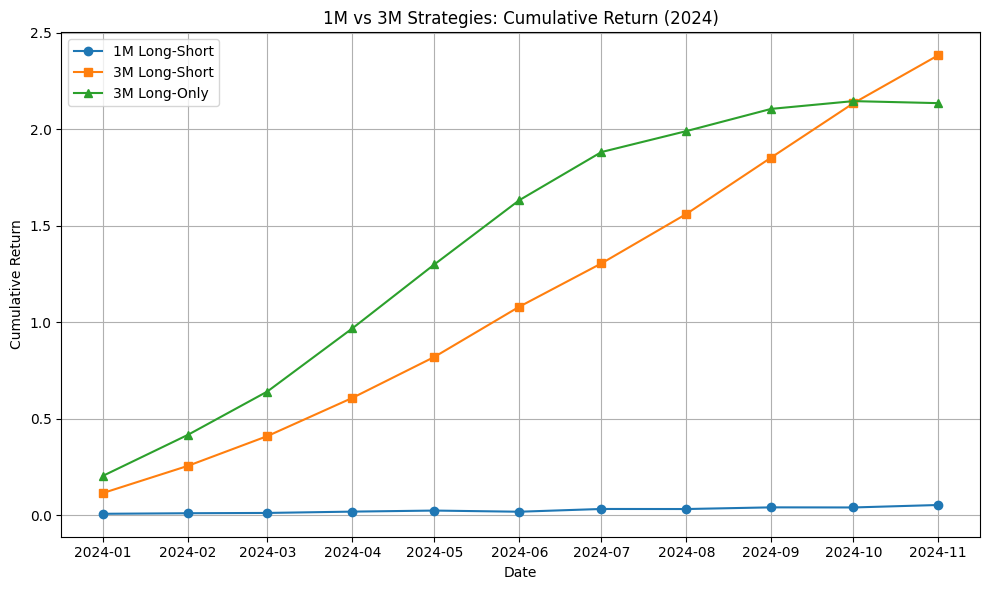

In [131]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from datetime import datetime

# ─────────────────────────────────────────────────
# 0. 파일 경로 설정 (사용자 환경에 맞게 수정)
# ─────────────────────────────────────────────────
factor_train_path = "/Users/gun/Desktop/경종설/국내/train_stock_0.3_ind_neutral.csv"
factor_test_path  = "/Users/gun/Desktop/경종설/국내/test_stock_0.3_ind_neutral.csv"
orig_train_path   = "/Users/gun/Desktop/경종설/국내/train_stock_0.3.csv"
orig_test_path    = "/Users/gun/Desktop/경종설/국내/test_stock_0.3.csv"

# ─────────────────────────────────────────────────
# 1. 데이터 로드
# ─────────────────────────────────────────────────
df_factor_train = pd.read_csv(factor_train_path, parse_dates=["기준월"])
df_factor_test  = pd.read_csv(factor_test_path,  parse_dates=["기준월"])
df_orig_train   = pd.read_csv(orig_train_path,   parse_dates=["기준월"])
df_orig_test    = pd.read_csv(orig_test_path,    parse_dates=["기준월"])

# ─────────────────────────────────────────────────
# 2. 익월 1개월 수익(next_1M_return) & 익월 3개월 수익(next_3M_return) 생성
# ─────────────────────────────────────────────────
def add_next_returns(df):
    df = df.sort_values(["회사명", "기준월"]).reset_index(drop=True)
    df["next_1M_return"] = df.groupby("회사명")["1개월수익률"].shift(-1)
    df["next_3M_return"] = df.groupby("회사명")["3개월수익률"].shift(-1)
    return df

df_orig_train = add_next_returns(df_orig_train)
df_orig_test  = add_next_returns(df_orig_test)

# ─────────────────────────────────────────────────
# 3. 팩터 데이터와 익월 수익 병합 (키: 기준월, 회사명)
# ─────────────────────────────────────────────────
train_merged = pd.merge(
    df_factor_train,
    df_orig_train[["기준월", "회사명", "next_1M_return", "next_3M_return"]],
    on=["기준월", "회사명"],
    how="inner"
).dropna(subset=["next_1M_return", "next_3M_return"])

test_merged = pd.merge(
    df_factor_test,
    df_orig_test[["기준월", "회사명", "next_1M_return", "next_3M_return"]],
    on=["기준월", "회사명"],
    how="inner"
).dropna(subset=["next_1M_return", "next_3M_return"])

# ─────────────────────────────────────────────────
# 4. 타깃(로그 변환 + 윈저라이즈) 생성: 1M, 3M 모두
# ─────────────────────────────────────────────────
for df in [train_merged, test_merged]:
    # 1M 타깃 로그 변환 + 윈저라이즈
    df["1M_log"] = np.log1p(df["next_1M_return"])
    lower1 = df["1M_log"].quantile(0.005)
    upper1 = df["1M_log"].quantile(0.995)
    df["1M_log"] = df["1M_log"].clip(lower1, upper1)
    # 3M 타깃 로그 변환 + 윈저라이즈
    df["3M_log"] = np.log1p(df["next_3M_return"])
    lower3 = df["3M_log"].quantile(0.005)
    upper3 = df["3M_log"].quantile(0.995)
    df["3M_log"] = df["3M_log"].clip(lower3, upper3)

# ─────────────────────────────────────────────────
# 5. 입력 피처 정의
# ─────────────────────────────────────────────────
feature_cols = ["value_score", "quality_score", "momentum_score", "size_score", "lowvol_score"]

# ─────────────────────────────────────────────────
# 6. 1개월 모델 학습
# ─────────────────────────────────────────────────
X1_train = train_merged[feature_cols].reset_index(drop=True)
y1_train = train_merged["1M_log"].reset_index(drop=True)
X1_test  = test_merged[feature_cols].reset_index(drop=True)
y1_test  = test_merged["1M_log"].reset_index(drop=True)

params_1M = {
    "objective": "regression",
    "metric": "rmse",
    "learning_rate": 0.05,
    "num_leaves": 31,
    "max_depth": -1,
    "min_data_in_leaf": 20,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 1,
    "verbose": -1
}

lgb_train_1M = lgb.Dataset(X1_train, label=y1_train)
lgb_1M = lgb.train(params_1M, lgb_train_1M, num_boost_round=200)

test_merged["pred_1M_log"]    = lgb_1M.predict(X1_test)
test_merged["pred_1M_return"] = np.expm1(test_merged["pred_1M_log"])

# ─────────────────────────────────────────────────
# 7. 3개월 모델 학습
# ─────────────────────────────────────────────────
X3_train = train_merged[feature_cols].reset_index(drop=True)
y3_train = train_merged["3M_log"].reset_index(drop=True)
X3_test  = test_merged[feature_cols].reset_index(drop=True)
y3_test  = test_merged["3M_log"].reset_index(drop=True)

params_3M = {
    "objective": "regression",
    "metric": "rmse",
    "learning_rate": 0.05,
    "num_leaves": 31,
    "max_depth": -1,
    "min_data_in_leaf": 20,
    "feature_fraction": 0.8,
    "bagging_fraction": 0.8,
    "bagging_freq": 1,
    "verbose": -1
}

lgb_train_3M = lgb.Dataset(X3_train, label=y3_train)
lgb_3M = lgb.train(params_3M, lgb_train_3M, num_boost_round=200)

test_merged["pred_3M_log"]    = lgb_3M.predict(X3_test)
test_merged["pred_3M_return"] = np.expm1(test_merged["pred_3M_log"])

# ─────────────────────────────────────────────────
# 8. 전략별 시그널 생성 함수 정의
# ─────────────────────────────────────────────────
def generate_long_short_signal(df_month, return_col, top_pct=0.3):
    df_month = df_month.sort_values(return_col, ascending=False).reset_index(drop=True)
    n = len(df_month)
    k = int(np.floor(n * top_pct))
    df_month["signal_ls"] = 0
    if k > 0:
        df_month.loc[: k - 1, "signal_ls"] =  1   # 상위 k 롱
        df_month.loc[n - k :, "signal_ls"] = -1   # 하위 k 숏
    return df_month

def generate_long_only_signal(df_month, return_col, top_pct=0.3):
    df_month = df_month.sort_values(return_col, ascending=False).reset_index(drop=True)
    n = len(df_month)
    k = int(np.floor(n * top_pct))
    df_month["signal_lo"] = 0
    if k > 0:
        df_month.loc[: k - 1, "signal_lo"] = 1   # 상위 k 롱
    return df_month

# ─────────────────────────────────────────────────
# 9. 1M Long-Short 전략: 월별 리밸 → PnL 계산
# ─────────────────────────────────────────────────
rebalance_1M_ls = test_merged.groupby("기준월", group_keys=False).apply(
    lambda dfm: generate_long_short_signal(dfm, "pred_1M_return", top_pct=0.3)
).reset_index(drop=True)

def pnl_1M_long_short(df_month):
    rows = []
    for _, row in df_month.iterrows():
        if row["signal_ls"] == 0:
            continue
        pnl = row["next_1M_return"] * row["signal_ls"]
        rows.append({"기준월": row["기준월"], "monthly_pnl": pnl})
    return pd.DataFrame(rows)

monthly_list_1M_ls = []
for mon, grp in rebalance_1M_ls.groupby("기준월", group_keys=False):
    df_pnl = pnl_1M_long_short(grp)
    monthly_list_1M_ls.append(df_pnl)

monthly_pnl_1M_ls = pd.concat(monthly_list_1M_ls, ignore_index=True)
perf_1M_ls = (
    monthly_pnl_1M_ls
    .groupby("기준월", group_keys=False)["monthly_pnl"]
    .mean()
    .sort_index()
    .to_frame(name="monthly_pnl")
)
perf_1M_ls["cum_return"] = (1 + perf_1M_ls["monthly_pnl"]).cumprod() - 1
mean1 = perf_1M_ls["monthly_pnl"].mean()
std1  = perf_1M_ls["monthly_pnl"].std()
sharpe1 = 0.0 if std1 < 1e-8 else (mean1 / std1) * np.sqrt(12)
cum_1M_ls = perf_1M_ls["cum_return"]

# ─────────────────────────────────────────────────
# 10. 3M Long-Short 전략: 월별 리밸 → PnL 계산
# ─────────────────────────────────────────────────
rebalance_3M_ls = test_merged.groupby("기준월", group_keys=False).apply(
    lambda dfm: generate_long_short_signal(dfm, "pred_3M_return", top_pct=0.3)
).reset_index(drop=True)

def pnl_3M_long_short(df_month):
    rows = []
    for _, row in df_month.iterrows():
        if row["signal_ls"] == 0:
            continue
        pnl = row["next_3M_return"] * row["signal_ls"]
        rows.append({"기준월": row["기준월"], "monthly_pnl": pnl})
    return pd.DataFrame(rows)

monthly_list_3M_ls = []
for mon, grp in rebalance_3M_ls.groupby("기준월", group_keys=False):
    df_pnl = pnl_3M_long_short(grp)
    monthly_list_3M_ls.append(df_pnl)

monthly_pnl_3M_ls = pd.concat(monthly_list_3M_ls, ignore_index=True)
perf_3M_ls = (
    monthly_pnl_3M_ls
    .groupby("기준월", group_keys=False)["monthly_pnl"]
    .mean()
    .sort_index()
    .to_frame(name="monthly_pnl")
)
perf_3M_ls["cum_return"] = (1 + perf_3M_ls["monthly_pnl"]).cumprod() - 1
mean3_ls = perf_3M_ls["monthly_pnl"].mean()
std3_ls  = perf_3M_ls["monthly_pnl"].std()
sharpe3_ls = 0.0 if std3_ls < 1e-8 else (mean3_ls / std3_ls) * np.sqrt(12)
cum_3M_ls = perf_3M_ls["cum_return"]

# ─────────────────────────────────────────────────
# 11. 3M Long-Only 전략: 월별 리밸 → PnL 계산
# ─────────────────────────────────────────────────
rebalance_3M_lo = test_merged.groupby("기준월", group_keys=False).apply(
    lambda dfm: generate_long_only_signal(dfm, "pred_3M_return", top_pct=0.3)
).reset_index(drop=True)

def pnl_3M_long_only(df_month):
    rows = []
    for _, row in df_month.iterrows():
        if row["signal_lo"] == 0:
            continue
        pnl = row["next_3M_return"]
        rows.append({"기준월": row["기준월"], "monthly_pnl": pnl})
    return pd.DataFrame(rows)

monthly_list_3M_lo = []
for mon, grp in rebalance_3M_lo.groupby("기준월", group_keys=False):
    df_pnl = pnl_3M_long_only(grp)
    monthly_list_3M_lo.append(df_pnl)

monthly_pnl_3M_lo = pd.concat(monthly_list_3M_lo, ignore_index=True)
perf_3M_lo = (
    monthly_pnl_3M_lo
    .groupby("기준월", group_keys=False)["monthly_pnl"]
    .mean()
    .sort_index()
    .to_frame(name="monthly_pnl")
)
perf_3M_lo["cum_return"] = (1 + perf_3M_lo["monthly_pnl"]).cumprod() - 1
mean3_lo = perf_3M_lo["monthly_pnl"].mean()
std3_lo  = perf_3M_lo["monthly_pnl"].std()
sharpe3_lo = 0.0 if std3_lo < 1e-8 else (mean3_lo / std3_lo) * np.sqrt(12)
cum_3M_lo = perf_3M_lo["cum_return"]

# ─────────────────────────────────────────────────
# 12. 결과 요약 및 시각화
# ─────────────────────────────────────────────────
print("=== 1M Long-Short 전략 ===")
print(f"누적 수익률: {cum_1M_ls.iloc[-1]:.4f}")
print(f"연환산 샤프비: {sharpe1:.4f}")
print(f"최대 낙폭: {((cum_1M_ls + 1) / (cum_1M_ls + 1).cummax() - 1).min():.4f}\n")

print("=== 3M Long-Short 전략 ===")
print(f"누적 수익률: {cum_3M_ls.iloc[-1]:.4f}")
print(f"연환산 샤프비: {sharpe3_ls:.4f}")
print(f"최대 낙폭: {((cum_3M_ls + 1) / (cum_3M_ls + 1).cummax() - 1).min():.4f}\n")

print("=== 3M Long-Only 전략 ===")
print(f"누적 수익률: {cum_3M_lo.iloc[-1]:.4f}")
print(f"연환산 샤프비: {sharpe3_lo:.4f}")
print(f"최대 낙폭: {((cum_3M_lo + 1) / (cum_3M_lo + 1).cummax() - 1).min():.4f}\n")

# 시각화: 누적 수익률 비교
plt.figure(figsize=(10, 6))
plt.plot(cum_1M_ls.index,  cum_1M_ls.values,  label="1M Long-Short", marker='o')
plt.plot(cum_3M_ls.index,  cum_3M_ls.values,  label="3M Long-Short", marker='s')
plt.plot(cum_3M_lo.index,  cum_3M_lo.values,  label="3M Long-Only", marker='^')
plt.ylabel("Cumulative Return")
plt.xlabel("Date")
plt.title("1M vs 3M Strategies: Cumulative Return (2024)")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

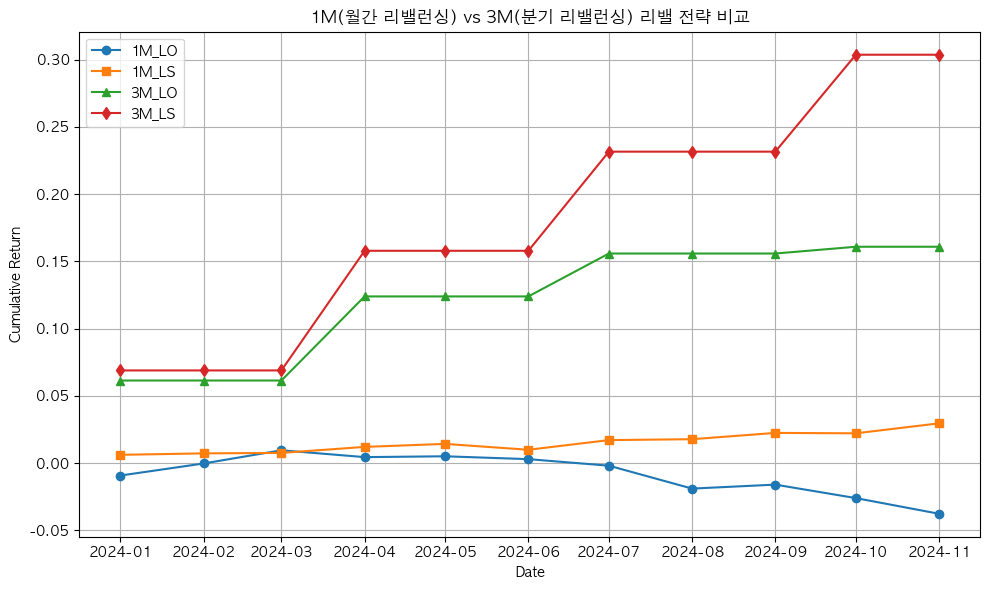

=== 전략별 성과 요약 ===
전략    누적수익   샤프비    MaxDD
1M_LO    -0.0377  -1.4651   -0.0468
1M_LS     0.0295   2.6829   -0.0043
3M_LO     0.1609   3.2570    0.0000
3M_LS     0.3037  14.8748    0.0000


In [149]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt

# ─────────────────────────────────────────────────
# 0. 파일 경로 설정 (환경에 맞게 수정)
# ─────────────────────────────────────────────────
factor_train_path = "/Users/gun/Desktop/경종설/국내/train_stock_0.3_ind_neutral.csv"
factor_test_path  = "/Users/gun/Desktop/경종설/국내/test_stock_0.3_ind_neutral.csv"
orig_train_path   = "/Users/gun/Desktop/경종설/국내/train_stock_0.3.csv"
orig_test_path    = "/Users/gun/Desktop/경종설/국내/test_stock_0.3.csv"

# ─────────────────────────────────────────────────
# 1. 데이터 로드
# ─────────────────────────────────────────────────
df_factor_train = pd.read_csv(factor_train_path, parse_dates=["기준월"])
df_factor_test  = pd.read_csv(factor_test_path,  parse_dates=["기준월"])
df_orig_train   = pd.read_csv(orig_train_path,   parse_dates=["기준월"])
df_orig_test    = pd.read_csv(orig_test_path,    parse_dates=["기준월"])

# ─────────────────────────────────────────────────
# 2. 익월 1M·3M 수익(next_1M_return, next_3M_return) 생성
# ─────────────────────────────────────────────────
def add_next_returns(df):
    df = df.sort_values(["회사명","기준월"]).reset_index(drop=True)
    df["next_1M_return"] = df.groupby("회사명")["1개월수익률"].shift(-1)
    df["next_3M_return"] = df.groupby("회사명")["3개월수익률"].shift(-1)
    return df

df_orig_train = add_next_returns(df_orig_train)
df_orig_test  = add_next_returns(df_orig_test)

# ─────────────────────────────────────────────────
# 3. 팩터 + 타깃 병합
# ─────────────────────────────────────────────────
train = pd.merge(
    df_factor_train,
    df_orig_train[["기준월","회사명","next_1M_return","next_3M_return"]],
    on=["기준월","회사명"], how="inner"
).dropna(subset=["next_1M_return","next_3M_return"])

test = pd.merge(
    df_factor_test,
    df_orig_test[["기준월","회사명","next_1M_return","next_3M_return"]],
    on=["기준월","회사명"], how="inner"
).dropna(subset=["next_1M_return","next_3M_return"])

# ─────────────────────────────────────────────────
# 4. 로그 변환 + 윈저라이즈
# ─────────────────────────────────────────────────
for df in (train, test):
    for h in ("1M","3M"):
        col    = f"next_{h}_return"
        logcol = f"{h}_log"
        df[logcol] = np.log1p(df[col])
        lo, hi   = df[logcol].quantile([0.005, 0.995])
        df[logcol] = df[logcol].clip(lo, hi)

# ─────────────────────────────────────────────────
# 5. LightGBM 학습 & 예측
# ─────────────────────────────────────────────────
features = ["value_score","quality_score","momentum_score","size_score","lowvol_score"]
models = {}
for h in ("1M","3M"):
    m = lgb.LGBMRegressor(
        objective="regression", metric="rmse", learning_rate=0.05,
        num_leaves=31, min_data_in_leaf=20,
        feature_fraction=0.8, bagging_fraction=0.8, bagging_freq=1,
        n_estimators=200, random_state=42, n_jobs=-1, verbose=-1
    )
    m.fit(train[features], train[f"{h}_log"])
    models[h] = m
    test[f"pred_{h}_log"]    = m.predict(test[features])
    test[f"pred_{h}_return"] = np.expm1(test[f"pred_{h}_log"])

# ─────────────────────────────────────────────────
# 6. 시그널 생성 함수
# ─────────────────────────────────────────────────
def gen_lo(df, pred, top=0.3):
    df = df.sort_values(pred, ascending=False).reset_index(drop=True)
    k = int(len(df)*top)
    df["signal"] = 0
    if k>0:
        df.loc[:k-1,"signal"] = 1
    return df

def gen_ls(df, pred, top=0.3):
    df = df.sort_values(pred, ascending=False).reset_index(drop=True)
    n, k = len(df), int(len(df)*top)
    df["signal"] = 0
    if k>0:
        df.loc[:k-1,"signal"] = 1
        df.loc[n-k:,"signal"] = -1
    return df

# ─────────────────────────────────────────────────
# 7. 백테스트 함수 (월간·분기·반기 등 리밸 주기 지정)
# ─────────────────────────────────────────────────
def backtest(df, pred_col, ret_col, signal_fn, rebalance_period=1):
    rows = []
    months = sorted(df["기준월"].unique())
    # p개월 간격으로 리밸
    rebalance_months = months[::rebalance_period]
    for mon in rebalance_months:
        grp = df[df["기준월"] == mon]
        tmp = signal_fn(grp, pred_col)
        pnl = (tmp["signal"] * tmp[ret_col]).mean()
        rows.append((mon, pnl))
    perf = pd.DataFrame(rows, columns=["기준월","monthly_pnl"]).set_index("기준월")
    perf["cum_return"] = (1+perf["monthly_pnl"]).cumprod() - 1

    arr    = perf["monthly_pnl"].values
    sharpe = arr.mean()/(arr.std()+1e-9)*np.sqrt(12/rebalance_period)
    cum    = perf["cum_return"].iloc[-1]
    dd     = perf["cum_return"]+1
    dd     = dd / dd.cummax() - 1
    maxdd  = dd.min()
    return perf["cum_return"], cum, sharpe, maxdd

# ─────────────────────────────────────────────────
# 8. 4가지 전략 실행
# ─────────────────────────────────────────────────
strategies = {
    "1M_LO": (gen_lo,  "pred_1M_return","next_1M_return", 1),
    "1M_LS": (gen_ls,  "pred_1M_return","next_1M_return", 1),
    "3M_LO": (gen_lo,  "pred_3M_return","next_3M_return", 3),
    "3M_LS": (gen_ls,  "pred_3M_return","next_3M_return", 3),
}

rets  = {}
stats = {}
for name, (fn, pred, real, period) in strategies.items():
    cum_srs, cum, shrp, mdd = backtest(test, pred, real, fn, rebalance_period=period)
    rets[name]  = cum_srs
    stats[name] = (cum, shrp, mdd)

# ─────────────────────────────────────────────────
# 9. 전체 월 지표 맞추기(결손 채우기)
# ─────────────────────────────────────────────────
all_months = sorted(test["기준월"].unique())
for k in rets:
    rets[k] = rets[k].reindex(all_months).ffill()

# ─────────────────────────────────────────────────
# 10. 시각화: 누적수익률 비교
# ─────────────────────────────────────────────────
plt.figure(figsize=(10,6))
markers = {"1M_LO":"o","1M_LS":"s","3M_LO":"^","3M_LS":"d"}
for name, series in rets.items():
    plt.plot(all_months, series.values, marker=markers[name], label=name)
plt.title("1M(월간 리밸런싱) vs 3M(분기 리밸런싱) 리밸 전략 비교")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

# ─────────────────────────────────────────────────
# 11. 결과 테이블 출력
# ─────────────────────────────────────────────────
print("=== 전략별 성과 요약 ===")
print("전략    누적수익   샤프비    MaxDD")
for name, (cum, shrp, mdd) in stats.items():
    print(f"{name:6s}  {cum:8.4f}  {shrp:7.4f}  {mdd:8.4f}")

In [154]:
import os
import pandas as pd
import numpy as np
import lightgbm as lgb

# ─────────────────────────────────────────────────
# 0. 파일 경로 설정
# ─────────────────────────────────────────────────
factor_train_path = "/Users/gun/Desktop/경종설/국내/train_stock_0.3_ind_neutral.csv"
factor_test_path  = "/Users/gun/Desktop/경종설/국내/test_stock_0.3_ind_neutral.csv"
orig_train_path   = "/Users/gun/Desktop/경종설/국내/train_stock_0.3.csv"
orig_test_path    = "/Users/gun/Desktop/경종설/국내/test_stock_0.3.csv"

# ─────────────────────────────────────────────────
# 1. 데이터 로드
# ─────────────────────────────────────────────────
df_factor_train = pd.read_csv(factor_train_path, parse_dates=["기준월"])
df_factor_test  = pd.read_csv(factor_test_path,  parse_dates=["기준월"])
df_orig_train   = pd.read_csv(orig_train_path,   parse_dates=["기준월"])
df_orig_test    = pd.read_csv(orig_test_path,    parse_dates=["기준월"])

# ─────────────────────────────────────────────────
# 2. 익월(1M)·익분기(3M) 수익률 생성
# ─────────────────────────────────────────────────
def add_next_returns(df):
    df = df.sort_values(["회사명","기준월"]).reset_index(drop=True)
    df["next_1M_return"] = df.groupby("회사명")["1개월수익률"].shift(-1)
    df["next_3M_return"] = df.groupby("회사명")["3개월수익률"].shift(-1)
    return df

df_orig_train = add_next_returns(df_orig_train)
df_orig_test  = add_next_returns(df_orig_test)

# ─────────────────────────────────────────────────
# 3. 팩터 데이터와 타깃 병합
# ─────────────────────────────────────────────────
train = pd.merge(
    df_factor_train,
    df_orig_train[["기준월","회사명","next_1M_return","next_3M_return"]],
    on=["기준월","회사명"], how="inner"
).dropna()

test = pd.merge(
    df_factor_test,
    df_orig_test[["기준월","회사명","next_1M_return","next_3M_return"]],
    on=["기준월","회사명"], how="inner"
).dropna()

# ─────────────────────────────────────────────────
# 4. 로그 변환 + 윈저라이즈 (1M, 3M)
# ─────────────────────────────────────────────────
for df in (train, test):
    for h in ("1M","3M"):
        col    = f"next_{h}_return"
        logcol = f"{h}_log"
        df[logcol] = np.log1p(df[col])
        lo = df[logcol].quantile(0.005)
        hi = df[logcol].quantile(0.995)
        df[logcol] = df[logcol].clip(lo, hi)

# ─────────────────────────────────────────────────
# 5. 피처 정의 & LightGBM 학습·예측
# ─────────────────────────────────────────────────
features = ["value_score","quality_score","momentum_score","size_score","lowvol_score"]
models = {}

for h in ("1M","3M"):
    # LGBMRegressor 사용
    m = lgb.LGBMRegressor(
        objective="regression",
        metric="rmse",
        learning_rate=0.05,
        num_leaves=31,
        min_data_in_leaf=20,
        feature_fraction=0.8,
        bagging_fraction=0.8,
        bagging_freq=1,
        n_estimators=200,
        random_state=42,
        n_jobs=-1,
        verbose=-1
    )
    m.fit(train[features], train[f"{h}_log"])
    models[h] = m

    # test 데이터에 예측값 붙이기
    test[f"pred_{h}_log"]    = m.predict(test[features])
    test[f"pred_{h}_return"] = np.expm1(test[f"pred_{h}_log"])

# ─────────────────────────────────────────────────
# 6. 결과 저장 (CSV)
# ─────────────────────────────────────────────────
output_dir  = "/Users/gun/Desktop/경종설/국내"
os.makedirs(output_dir, exist_ok=True)
output_path = os.path.join(output_dir, "test_merged_with_preds.csv")

# 날짜·회사명·팩터·원본 수익·예측 수익 모두 포함해서 저장
test.to_csv(output_path, index=False, encoding="utf-8-sig")

print(f"✅ 예측결과 저장 완료: {output_path}")

✅ 예측결과 저장 완료: /Users/gun/Desktop/경종설/국내/test_merged_with_preds.csv



[1M] RMSE: 0.1298, MAE: 0.0832, R²: -0.0246


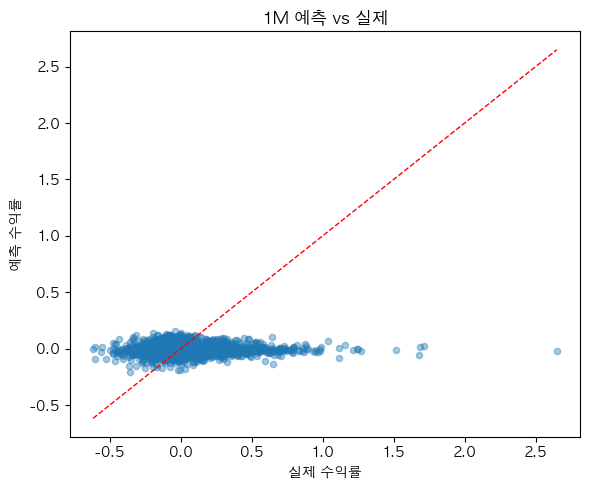

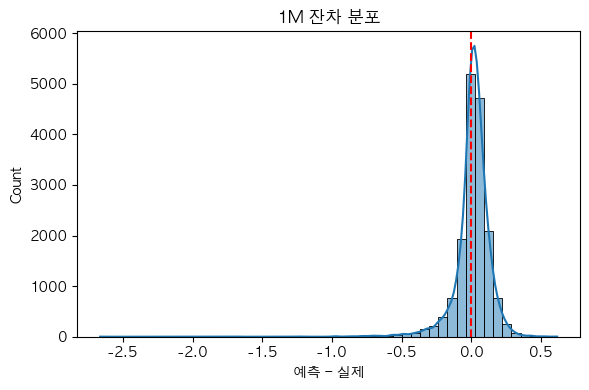


[1M] 예측 수익률 10분위별 실제 수익 통계:
         mean      std  count
qcut                         
0     -0.0309   0.1692   1682
1     -0.0102   0.1498   1682
2     -0.0148   0.1067   1682
3     -0.0145   0.1113   1682
4     -0.0079   0.1122   1682
5     -0.0135   0.1096   1681
6     -0.0202   0.1138   1682
7     -0.0183   0.1161   1682
8     -0.0149   0.1198   1682
9     -0.0111   0.1544   1682

[3M] RMSE: 0.1922, MAE: 0.1181, R²: 0.3080


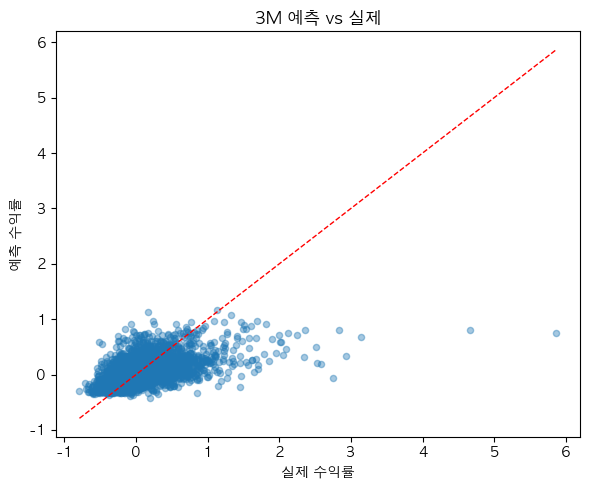

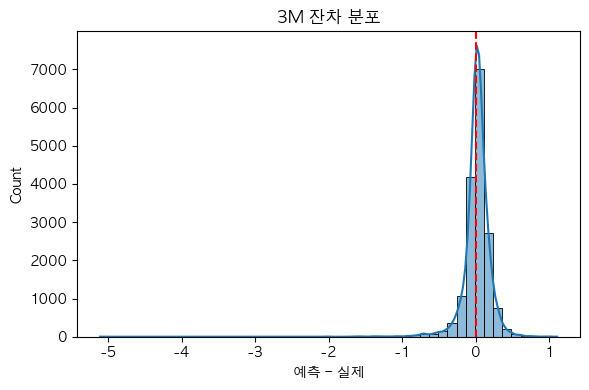


[3M] 예측 수익률 10분위별 실제 수익 통계:
         mean      std  count
qcut                         
0     -0.1757   0.1736   1682
1     -0.1315   0.1360   1682
2     -0.1064   0.1187   1682
3     -0.0757   0.1213   1682
4     -0.0483   0.1434   1682
5     -0.0256   0.1414   1681
6     -0.0025   0.1472   1682
7      0.0297   0.1679   1682
8      0.0788   0.1944   1682
9      0.2631   0.4329   1682


In [156]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# ─────────────────────────────────────────────────
# 0. test_merged 로드
# ─────────────────────────────────────────────────
test_merged = pd.read_csv(
    "/Users/gun/Desktop/경종설/국내/test_merged_with_preds.csv",
    parse_dates=["기준월"]
)

# ─────────────────────────────────────────────────
# 1. 평가 함수
# ─────────────────────────────────────────────────
def evaluate_and_plot(df, pred_col, real_col, horizon):
    y_true = df[real_col].values
    y_pred = df[pred_col].values
    resid  = y_pred - y_true

    # Metrics
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    print(f"\n[{horizon}] RMSE: {rmse:.4f}, MAE: {mae:.4f}, R²: {r2:.4f}")

    # Scatter
    plt.figure(figsize=(6,5))
    plt.scatter(y_true, y_pred, alpha=0.4, s=20)
    mn, mx = y_true.min(), y_true.max()
    plt.plot([mn,mx], [mn,mx], 'r--', lw=1)
    plt.title(f"{horizon} 예측 vs 실제")
    plt.xlabel("실제 수익률")
    plt.ylabel("예측 수익률")
    plt.tight_layout()
    plt.show()

    # Residual Distribution
    plt.figure(figsize=(6,4))
    sns.histplot(resid, bins=50, kde=True)
    plt.axvline(0, color='r', linestyle='--')
    plt.title(f"{horizon} 잔차 분포")
    plt.xlabel("예측 – 실제")
    plt.tight_layout()
    plt.show()

    # Quantile별 실제 수익 통계
    df_q = df[[pred_col, real_col]].copy()
    df_q["qcut"] = pd.qcut(df_q[pred_col], 10, labels=False)
    stats = df_q.groupby("qcut")[real_col].agg(["mean","std","count"])
    print(f"\n[{horizon}] 예측 수익률 10분위별 실제 수익 통계:")
    print(stats)

# ─────────────────────────────────────────────────
# 2. 1M 모델 평가
# ─────────────────────────────────────────────────
evaluate_and_plot(
    test_merged,
    pred_col="pred_1M_return",
    real_col="next_1M_return",
    horizon="1M"
)

# ─────────────────────────────────────────────────
# 3. 3M 모델 평가
# ─────────────────────────────────────────────────
evaluate_and_plot(
    test_merged,
    pred_col="pred_3M_return",
    real_col="next_3M_return",
    horizon="3M"
)

In [157]:
import pandas as pd
import numpy as np

# ─────────────────────────────────────────────────
# 0) test_merged 불러오기 (이미 메모리에 있다면 이 줄 생략)
# ─────────────────────────────────────────────────
# test_merged = pd.read_csv("test_merged.csv", parse_dates=["기준월"])

# ─────────────────────────────────────────────────
# 1) 히스토리컬 예측값 → 신호 변환 함수 정의
# ─────────────────────────────────────────────────
def make_signal(pred: pd.Series,
                top_pct: float = 0.3,
                bot_pct: float = 0.3) -> pd.Series:
    """
    pred Series 기준:
      상위 top_pct  → +1
      하위 bot_pct  → -1
      나머지       →  0
    """
    high_th = pred.quantile(1 - top_pct)
    low_th  = pred.quantile(bot_pct)
    sig = pd.Series(0, index=pred.index)
    sig[pred >= high_th] =  1
    sig[pred <= low_th ] = -1
    return sig

# ─────────────────────────────────────────────────
# 2) 3M 예측치 기반 Long-Short 시그널 생성 (분기 리밸용)
# ─────────────────────────────────────────────────
test_merged["signal_3M_ls"] = (
    test_merged
      .groupby("기준월")["pred_3M_return"]
      .transform(lambda x: make_signal(x, top_pct=0.3, bot_pct=0.3))
)

# ─────────────────────────────────────────────────
# 3) 3M 예측치 기반 Long-Only 시그널 생성
# ─────────────────────────────────────────────────
test_merged["signal_3M_lo"] = (
    test_merged
      .groupby("기준월")["pred_3M_return"]
      .transform(lambda x: make_signal(x, top_pct=0.3, bot_pct=0.0))
)

# ─────────────────────────────────────────────────
# (옵션) 1M 보조지표용 시그널
# ─────────────────────────────────────────────────
# → 3M 전략에 보조 입력으로 쓰고 싶다면, 같은 방식으로 1M_pred 에서 signal_1M_ls/lo 를 만들어 두세요.
test_merged["signal_1M_ls"] = (
    test_merged
      .groupby("기준월")["pred_1M_return"]
      .transform(lambda x: make_signal(x, top_pct=0.3, bot_pct=0.3))
)
test_merged["signal_1M_lo"] = (
    test_merged
      .groupby("기준월")["pred_1M_return"]
      .transform(lambda x: make_signal(x, top_pct=0.3, bot_pct=0.0))
)

# ─────────────────────────────────────────────────
# 4) 생성된 시그널 확인
# ─────────────────────────────────────────────────
print(test_merged[["기준월","회사명",
                   "pred_3M_return","signal_3M_ls","signal_3M_lo"]]
      .drop_duplicates()
      .head(10))

         기준월     회사명  pred_3M_return  signal_3M_ls  signal_3M_lo
0 2024-01-01  AJ네트웍스          0.3762             1             1
1 2024-02-01  AJ네트웍스          0.2249             1             1
2 2024-03-01  AJ네트웍스          0.0173             0             0
3 2024-04-01  AJ네트웍스          0.0663             1             1
4 2024-05-01  AJ네트웍스          0.1528             1             1
5 2024-06-01  AJ네트웍스          0.1936             1             1
6 2024-07-01  AJ네트웍스         -0.1035            -1             0
7 2024-08-01  AJ네트웍스         -0.0121             0             0
8 2024-09-01  AJ네트웍스         -0.0182             1             1
9 2024-10-01  AJ네트웍스          0.0942             1             1


=== Final 전략 (3M_LS 필터링 by 1M_LS) ===
누적 수익률: 0.8469
연환산 샤프비: 29.8046
최대 낙폭: 0.0000


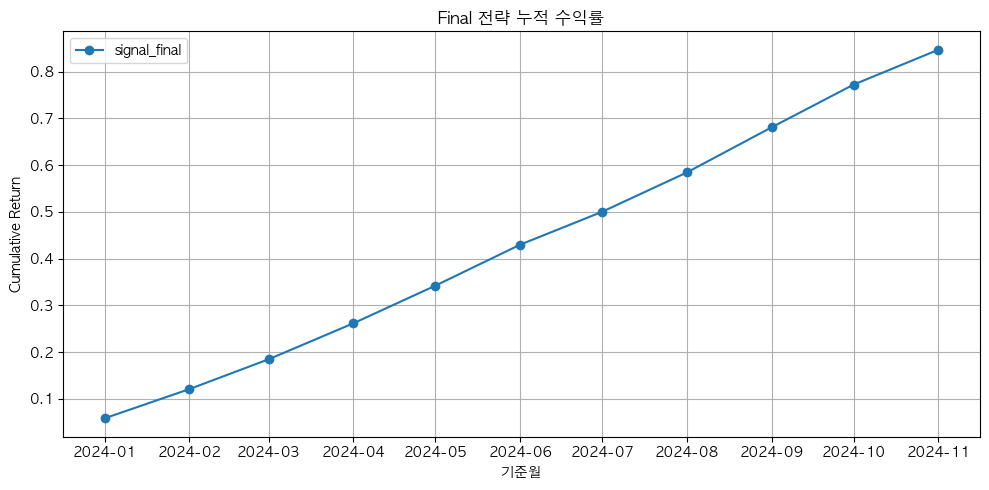

In [158]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ─────────────────────────────────────────────────
# (1) test_merged 불러오기
#    이미 메모리에 test_merged가 있다면 이 단계는 건너뛰세요.
# test_merged = pd.read_csv("test_merged.csv", parse_dates=["기준월"])

# ─────────────────────────────────────────────────
# (2) signal_final 생성
#    - 3M 신호가 ±1일 때만, 1M 신호가 0이 아니면 포지션 유지
test_merged["signal_final"] = (
    test_merged["signal_3M_ls"]  # 3M Long-Short 신호
    * (test_merged["signal_1M_ls"] != 0).astype(int)  # 1M 필터
)

# ─────────────────────────────────────────────────
# (3) 백테스트 함수 정의
def backtest_final(df):
    rows = []
    for month, grp in df.groupby("기준월", as_index=False):
        pnl = (grp["signal_final"] * grp["next_3M_return"]).mean()
        rows.append((month, pnl))
    perf = pd.DataFrame(rows, columns=["기준월","monthly_pnl"])\
             .set_index("기준월")\
             .sort_index()
    perf["cum_return"] = (1 + perf["monthly_pnl"]).cumprod() - 1

    arr    = perf["monthly_pnl"].values
    sharpe = arr.mean() / (arr.std() + 1e-9) * np.sqrt(12)
    # Max Drawdown
    cum    = perf["cum_return"] + 1
    dd     = cum / cum.cummax() - 1
    maxdd  = dd.min()

    return perf, sharpe, maxdd

# ─────────────────────────────────────────────────
# (4) 퍼포먼스 계산
perf, sharpe, maxdd = backtest_final(test_merged)

print("=== Final 전략 (3M_LS 필터링 by 1M_LS) ===")
print(f"누적 수익률: {perf['cum_return'].iloc[-1]:.4f}")
print(f"연환산 샤프비: {sharpe:.4f}")
print(f"최대 낙폭: {maxdd:.4f}")

# ─────────────────────────────────────────────────
# (5) 누적 수익률 시각화
plt.figure(figsize=(10,5))
plt.plot(perf.index, perf["cum_return"], marker="o", label="signal_final")
plt.title("Final 전략 누적 수익률")
plt.xlabel("기준월")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.show()

=== Final 전략 (3M_LS × 1M_LS 필터, 분기 리밸) ===
누적수익률     : 0.5640
연환산 샤프비  : 22.0913
최대 낙폭      : 0.0000


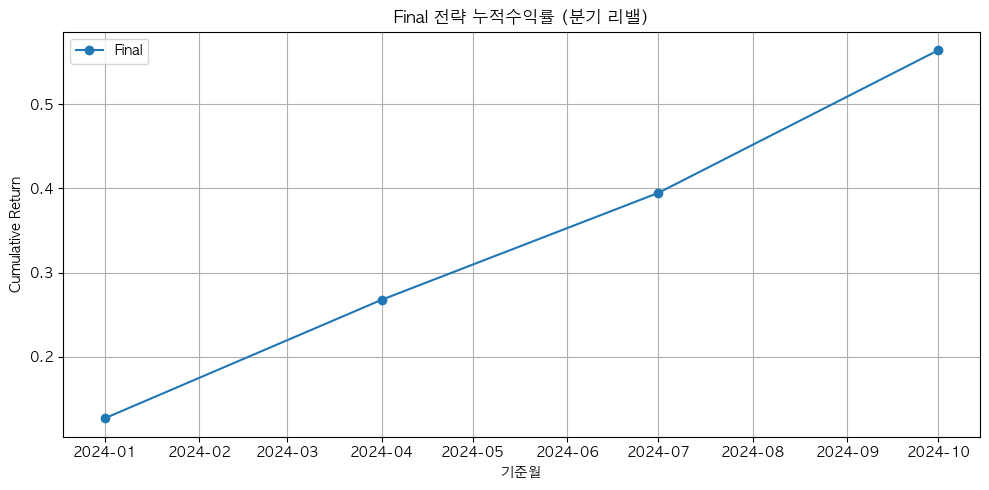

In [165]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt

# ─────────────────────────────────────────────────
# 0. 파일 경로 설정
# ─────────────────────────────────────────────────
factor_train_path = "/Users/gun/Desktop/경종설/국내/train_stock_0.3_ind_neutral.csv"
factor_test_path  = "/Users/gun/Desktop/경종설/국내/test_stock_0.3_ind_neutral.csv"
orig_train_path   = "/Users/gun/Desktop/경종설/국내/train_stock_0.3.csv"
orig_test_path    = "/Users/gun/Desktop/경종설/국내/test_stock_0.3.csv"

# ─────────────────────────────────────────────────
# 1. 데이터 로드 & next returns 생성
# ─────────────────────────────────────────────────
def add_next_returns(df):
    df = df.sort_values(["회사명","기준월"]).reset_index(drop=True)
    df["next_1M_return"] = df.groupby("회사명")["1개월수익률"].shift(-1)
    df["next_3M_return"] = df.groupby("회사명")["3개월수익률"].shift(-1)
    return df

df_f_tr = pd.read_csv(factor_train_path, parse_dates=["기준월"])
df_f_te = pd.read_csv(factor_test_path,  parse_dates=["기준월"])
df_o_tr = add_next_returns(pd.read_csv(orig_train_path,   parse_dates=["기준월"]))
df_o_te = add_next_returns(pd.read_csv(orig_test_path,    parse_dates=["기준월"]))

train = pd.merge(df_f_tr, df_o_tr[["기준월","회사명","next_1M_return","next_3M_return"]],
                 on=["기준월","회사명"], how="inner").dropna()
test  = pd.merge(df_f_te, df_o_te[["기준월","회사명","next_1M_return","next_3M_return"]],
                 on=["기준월","회사명"], how="inner").dropna()

# ─────────────────────────────────────────────────
# 2. 로그 변환 + 윈저라이즈
# ─────────────────────────────────────────────────
for df in (train, test):
    for h,col in [("1M","next_1M_return"),("3M","next_3M_return")]:
        logcol = f"{h}_log"
        df[logcol] = np.log1p(df[col])
        lo,hi = df[logcol].quantile([0.005,0.995])
        df[logcol] = df[logcol].clip(lo,hi)

# ─────────────────────────────────────────────────
# 3. LightGBM 학습 & 예측
# ─────────────────────────────────────────────────
features = ["value_score","quality_score","momentum_score","size_score","lowvol_score"]
for h in ("1M","3M"):
    model = lgb.LGBMRegressor(
        objective="regression", metric="rmse",
        learning_rate=0.05, num_leaves=31, min_data_in_leaf=20,
        feature_fraction=0.8, bagging_fraction=0.8, bagging_freq=1,
        n_estimators=200, random_state=42, n_jobs=-1, verbose=-1
    )
    model.fit(train[features], train[f"{h}_log"])
    test[f"pred_{h}_log"]    = model.predict(test[features])
    test[f"pred_{h}_return"] = np.expm1(test[f"pred_{h}_log"])

# ─────────────────────────────────────────────────
# 4. 1M Long-Short 필터
# ─────────────────────────────────────────────────
def gen_1M_ls(df, top_pct=0.3):
    # 1) 월별 예측 리턴 순위대로 정렬
    df = df.sort_values("pred_1M_return", ascending=False).reset_index(drop=True)
    # 2) 포지션 수 계산
    n = len(df)
    k = int(n * top_pct)
    # 3) 시그널 초기화 & 할당
    df["signal_1M_ls"] = 0
    if k > 0:
        df.loc[:k-1, "signal_1M_ls"] =  1
        df.loc[n-k:  , "signal_1M_ls"] = -1
    return df

# 적용
test = test.groupby("기준월", group_keys=False).apply(gen_1M_ls).reset_index(drop=True)

# ─────────────────────────────────────────────────
# 5. 3M 예측값 5분위 다단계 분류 → signal_strength
# ─────────────────────────────────────────────────
test["q5_3M"] = pd.qcut(test["pred_3M_return"],5,labels=False)
weight_map   = {0:-2,1:-1,2:0,3:1,4:2}
test["signal_strength"] = test["q5_3M"].map(weight_map)

# 1M 필터로 중립 지우기
test["signal_final"] = test["signal_strength"] * (test["signal_1M_ls"]!=0).astype(int)

# ─────────────────────────────────────────────────
# 6. 분기별(1,4,7,10월) 백테스트
# ─────────────────────────────────────────────────
perf_rows = []
for mon, grp in test.groupby("기준월",as_index=False):
    month = mon.month
    # 3M 전략은 분기 리밸(1,4,7,10월)에만 PnL 적용
    if month in (1,4,7,10):
        pnl = (grp["signal_final"] * grp["next_3M_return"]).mean()
        perf_rows.append((mon, pnl))
# 분기별 성과 DF
perf = pd.DataFrame(perf_rows, columns=["기준월","pnl"]).set_index("기준월")

# 누적수익
perf["cum_return"] = (1 + perf["pnl"]).cumprod() - 1
arr = perf["pnl"].values

# 연환산 Sharpe: 분기별 수익 → annualize by √4
sharpe  = arr.mean()/(arr.std()+1e-9)*np.sqrt(4)
cum     = perf["cum_return"].iloc[-1]
dd      = perf["cum_return"]+1
maxdd   = (dd/dd.cummax() - 1).min()

# ─────────────────────────────────────────────────
# 7. 결과 출력 & 시각화
# ─────────────────────────────────────────────────
print("=== Final 전략 (3M_LS × 1M_LS 필터, 분기 리밸) ===")
print(f"누적수익률     : {cum:.4f}")
print(f"연환산 샤프비  : {sharpe:.4f}")
print(f"최대 낙폭      : {maxdd:.4f}")

plt.figure(figsize=(10,5))
plt.plot(perf.index, perf["cum_return"], marker="o", label="Final")
plt.title("Final 전략 누적수익률 (분기 리밸)")
plt.xlabel("기준월")
plt.ylabel("Cumulative Return")
plt.grid()
plt.legend()
plt.tight_layout()
plt.show()

count    11.0000
mean      0.1360
std       0.0161
min       0.1011
25%       0.1306
50%       0.1410
75%       0.1478
max       0.1523
Name: monthly_pnl, dtype: float64


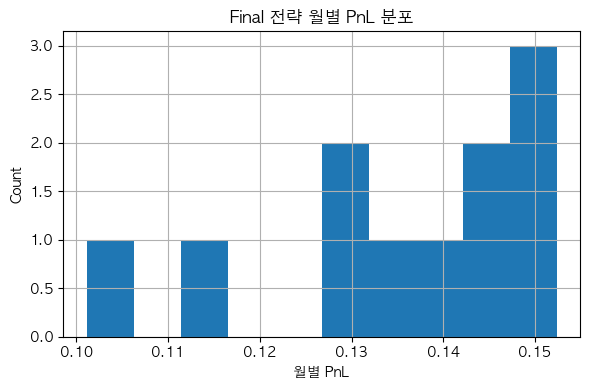

기준월
2024-01-01   615.0000
2024-02-01   640.0000
2024-03-01   663.0000
2024-04-01   664.0000
2024-05-01   641.0000
2024-06-01   655.0000
2024-07-01   647.0000
2024-08-01   647.0000
2024-09-01   646.0000
2024-10-01   640.0000
2024-11-01   636.0000
Name: n_positions, dtype: float64


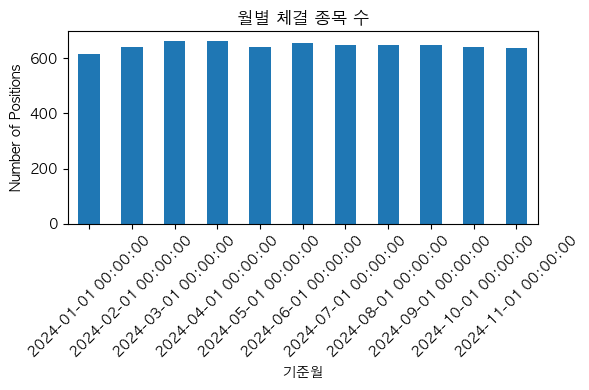

In [174]:
import pandas as pd
import matplotlib.pyplot as plt

# 1) 월별 PnL 계산
# signal_final 이란 컬럼이 1 또는 -1 (또는 0) 신호를 담고 있다고 가정
perf_final = (
    test_merged
    .loc[test_merged["signal_final"] != 0]  # 포지션 있는 종목만
    .groupby("기준월", as_index=True)
    .apply(lambda df: pd.Series({
        "monthly_pnl": (df["signal_final"] * df["next_3M_return"]).mean(),  # 월별 PnL
        "n_positions":          (df["signal_final"] != 0).sum()           # 체결 종목 수
    }))
)

# 누적수익률도 추가
perf_final["cum_return"] = (1 + perf_final["monthly_pnl"]).cumprod() - 1

# 2) PnL 분포 확인
print(perf_final["monthly_pnl"].describe())
plt.figure(figsize=(6,4))
perf_final["monthly_pnl"].hist(bins=10)
plt.title("Final 전략 월별 PnL 분포")
plt.xlabel("월별 PnL")
plt.ylabel("Count")
plt.tight_layout()
plt.show()

# 3) 월별 체결 종목 수 확인
print(perf_final["n_positions"])
plt.figure(figsize=(6,4))
perf_final["n_positions"].plot(kind="bar")
plt.title("월별 체결 종목 수")
plt.ylabel("Number of Positions")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

=== Final 전략 (3M_LS filtered by 1M_LS, 분기 리밸) ===
누적수익률   : 0.8434
연환산샤프비 : 17.4431
최대낙폭     : 0.0000

월별 PnL 통계:
count    11.0000
mean      0.0572
std       0.0069
min       0.0422
25%       0.0551
50%       0.0582
75%       0.0620
max       0.0651
Name: monthly_pnl, dtype: float64


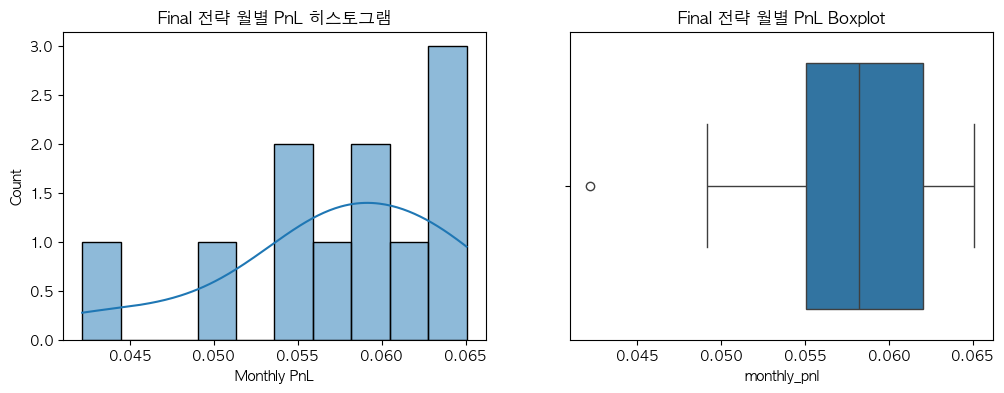


월별 Turnover:
       turnover
count   10.0000
mean     0.4172
std      0.0314
min      0.3721
25%      0.3964
50%      0.4165
75%      0.4237
max      0.4861


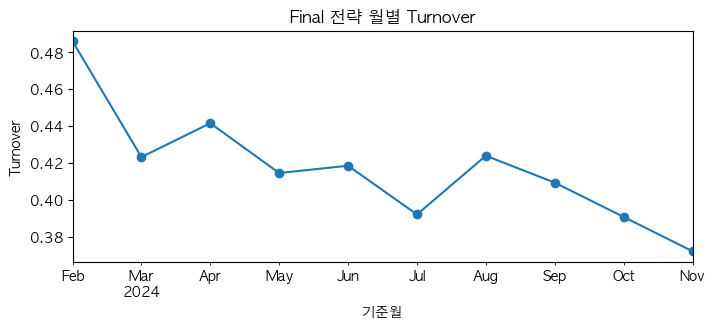

In [178]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

# ─────────────────────────────────────────────────
# 1) 데이터 로드
# ─────────────────────────────────────────────────
# (사전에 test_merged.csv로 저장했다고 가정)
test = pd.read_csv("/Users/gun/Desktop/경종설/국내/test_merged_with_preds.csv", parse_dates=["기준월"])

# ─────────────────────────────────────────────────
# 2) 시그널 생성 함수
# ─────────────────────────────────────────────────
def gen_long_short(df, pred_col, top_pct=0.3):
    df = df.sort_values(pred_col, ascending=False).reset_index(drop=True)
    n = len(df); k = int(np.floor(n * top_pct))
    df["signal"] = 0
    if k > 0:
        df.loc[:k-1, "signal"] =  1
        df.loc[n-k:, "signal"] = -1
    return df

# 3) 3M / 1M Long-Short 시그널
sig3m = (
    test
    .groupby("기준월", group_keys=False)
    .apply(lambda x: gen_long_short(x, "pred_3M_return"))
    .rename(columns={"signal": "signal_3M_ls"})
)
sig1m = (
    test
    .groupby("기준월", group_keys=False)
    .apply(lambda x: gen_long_short(x, "pred_1M_return"))
    .rename(columns={"signal": "signal_1M_ls"})
)

# 4) 최종 시그널 병합 & 필터링
df = (
    test
    .merge(sig3m[["기준월","회사명","signal_3M_ls"]], on=["기준월","회사명"])
    .merge(sig1m[["기준월","회사명","signal_1M_ls"]], on=["기준월","회사명"])
)
df["signal_final"] = df["signal_3M_ls"] * (df["signal_1M_ls"] != 0).astype(int)

# ─────────────────────────────────────────────────
# 5) 월별 PnL 계산
# ─────────────────────────────────────────────────
perf = (
    df
    .assign(pnl = df["signal_final"] * df["next_3M_return"])
    .groupby("기준월")["pnl"]
    .mean()
    .to_frame("monthly_pnl")
)
perf["cum_return"] = (1 + perf["monthly_pnl"]).cumprod() - 1
pnls = perf["monthly_pnl"].values

# 성과 지표
mean_rtn = pnls.mean()
std_rtn  = pnls.std() + 1e-9
sharpe   = mean_rtn / std_rtn * np.sqrt(12/3)   # 분기 리밸 → 3개월 단위
cum      = perf["cum_return"].iloc[-1]
running = perf["cum_return"] + 1
maxdd   = (running / running.cummax() - 1).min()

print("=== Final 전략 (3M_LS filtered by 1M_LS, 분기 리밸) ===")
print(f"누적수익률   : {cum:.4f}")
print(f"연환산샤프비 : {sharpe:.4f}")
print(f"최대낙폭     : {maxdd:.4f}\n")

# ─────────────────────────────────────────────────
# 6) 월별 PnL 분포
# ─────────────────────────────────────────────────
print("월별 PnL 통계:")
print(perf["monthly_pnl"].describe())

plt.figure(figsize=(12,4))
plt.subplot(1,2,1)
sns.histplot(perf["monthly_pnl"], bins=10, kde=True)
plt.title("Final 전략 월별 PnL 히스토그램")
plt.xlabel("Monthly PnL")

plt.subplot(1,2,2)
sns.boxplot(x=perf["monthly_pnl"])
plt.title("Final 전략 월별 PnL Boxplot")
plt.show()

# ─────────────────────────────────────────────────
# 7) Turnover (회전율) 계산
# ─────────────────────────────────────────────────
turns = []
prev_set = None
for mon in perf.index:
    cur = set(df.loc[(df["기준월"]==mon) & (df["signal_final"]!=0), "회사명"])
    if prev_set is not None and len(prev_set)>0:
        turns.append((mon, 1 - len(prev_set & cur)/len(prev_set)))
    prev_set = cur

turn_df = pd.DataFrame(turns, columns=["기준월","turnover"]).set_index("기준월")
print("\n월별 Turnover:")
print(turn_df.describe())

plt.figure(figsize=(8,3))
turn_df["turnover"].plot(marker="o")
plt.title("Final 전략 월별 Turnover")
plt.ylabel("Turnover")
plt.show()

=== 최종 전략 성과 (3M_LS × 1M_LS 필터, 분기 리밸) ===
누적 수익률: 0.1239
연환산 샤프비: 7.6576
최대 낙폭: 0.0000



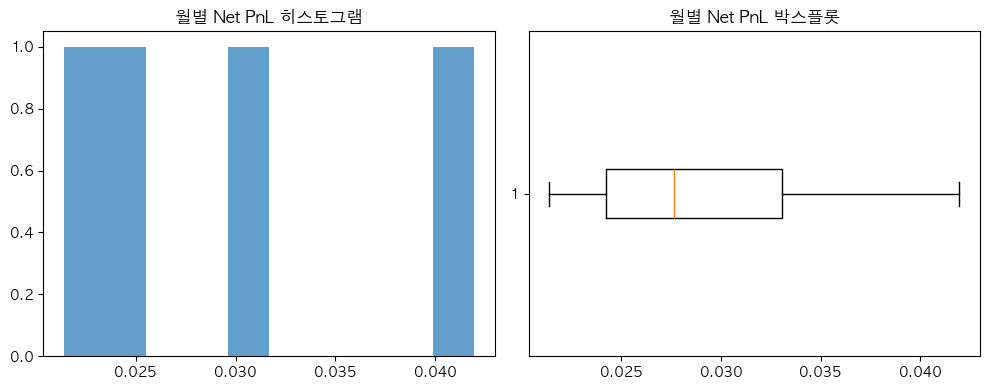

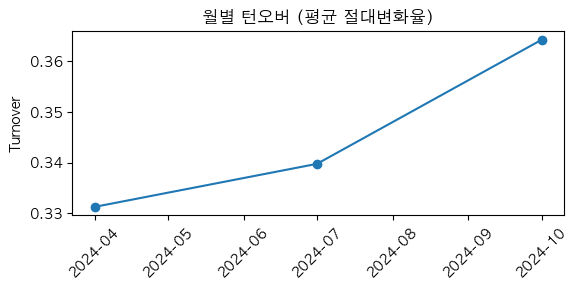

In [179]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt

# ─────────────────────────────────────────────────
# 0. 파일 경로
# ─────────────────────────────────────────────────
factor_train = "/Users/gun/Desktop/경종설/국내/train_stock_0.3_ind_neutral.csv"
factor_test  = "/Users/gun/Desktop/경종설/국내/test_stock_0.3_ind_neutral.csv"
orig_train   = "/Users/gun/Desktop/경종설/국내/train_stock_0.3.csv"
orig_test    = "/Users/gun/Desktop/경종설/국내/test_stock_0.3.csv"

# ─────────────────────────────────────────────────
# 1. 데이터 로드 & next returns 생성
# ─────────────────────────────────────────────────
def load_and_merge():
    df_ft = pd.read_csv(factor_train, parse_dates=["기준월"])
    df_tt = pd.read_csv(factor_test,  parse_dates=["기준월"])
    df_ot = pd.read_csv(orig_train,   parse_dates=["기준월"])
    df_to = pd.read_csv(orig_test,    parse_dates=["기준월"])
    # next returns
    for df in (df_ot, df_to):
        df.sort_values(["회사명","기준월"], inplace=True)
        df["next_1M_return"] = df.groupby("회사명")["1개월수익률"].shift(-1)
        df["next_3M_return"] = df.groupby("회사명")["3개월수익률"].shift(-1)
    # merge
    train = pd.merge(df_ft, df_ot[["기준월","회사명","next_1M_return","next_3M_return"]],
                     on=["기준월","회사명"]).dropna()
    test  = pd.merge(df_tt, df_to[["기준월","회사명","next_1M_return","next_3M_return"]],
                     on=["기준월","회사명"]).dropna()
    return train, test

train, test = load_and_merge()

# ─────────────────────────────────────────────────
# 2. 로그 변환 + 윈저라이즈
# ─────────────────────────────────────────────────
for df in (train, test):
    for h in ("1M","3M"):
        col, lc = f"next_{h}_return", f"{h}_log"
        df[lc] = np.log1p(df[col])
        lo, hi = df[lc].quantile([0.005,0.995])
        df[lc] = df[lc].clip(lo, hi)

# ─────────────────────────────────────────────────
# 3. LightGBM 학습 & 예측
# ─────────────────────────────────────────────────
feats = ["value_score","quality_score","momentum_score","size_score","lowvol_score"]
models = {}
for h in ("1M","3M"):
    m = lgb.LGBMRegressor(
        objective="regression", metric="rmse", learning_rate=0.05,
        num_leaves=31, min_data_in_leaf=20,
        feature_fraction=0.8, bagging_fraction=0.8, bagging_freq=1,
        n_estimators=200, random_state=42, n_jobs=-1, verbose=-1
    )
    m.fit(train[feats], train[f"{h}_log"])
    models[h] = m
    test[f"pred_{h}_log"]    = m.predict(test[feats])
    test[f"pred_{h}_return"] = np.expm1(test[f"pred_{h}_log"])

# ─────────────────────────────────────────────────
# 4. Signal 생성: 3M 5분위 * 필터(1M 상위30%일 때만 적용)
# ─────────────────────────────────────────────────
def make_signals(df):
    # 3M 예측 5분위
    df["q5_3M"] = pd.qcut(df["pred_3M_return"], 5, labels=False)
    # 분위수 → 가중치 매핑
    weight_map = {0:-1.0, 1:-0.5, 2:0.0, 3:0.5, 4:1.0}
    df["sig_3M"] = df["q5_3M"].map(weight_map)
    # 1M 보조 필터: 상위30%만 살린 뒤, 나머지 모두 0
    df["rank1M"] = df.groupby("기준월")["pred_1M_return"]\
                     .rank(pct=True, ascending=False)
    df["sig_1M_filt"] = np.where(df["rank1M"]<=0.3, 1, 0)
    # 최종 signal = 3M signal × 1M filter
    df["signal_final"] = df["sig_3M"] * df["sig_1M_filt"]
    return df

test = test.groupby("기준월", group_keys=False).apply(make_signals)

# ─────────────────────────────────────────────────
# 5. 분기별 리밸런싱 & PnL 계산 함수
# ─────────────────────────────────────────────────
def backtest(df, ret_col, sig_col, period_months=3, tc=0.0005):
    months = sorted(df["기준월"].unique())[::period_months]
    records = []
    for mon in months:
        sub = df[df["기준월"]==mon]
        # pnl = signal × 실제수익 − 거래비용(|Δsignal| × tc)
        # 여기선 매월 체결 종목 신호 바뀐 비율을 turnover로 사용
        # (보다 정교하게 매종목 individual turnover 계산 가능)
        pnl = (sub[sig_col] * sub[ret_col]).mean()
        # turnover approximation
        if records:
            prev = records[-1][2]  # 이전 달 시그널 배열
            turnover = np.mean(np.abs(sub[sig_col].values - prev))
        else:
            turnover = 0
        net_pnl = pnl - turnover * tc
        records.append((mon, pnl, sub[sig_col].values, net_pnl))
    # DataFrame 정리
    df_bt = pd.DataFrame(records, columns=["기준월","pnl","sig_vec","net_pnl"])
    df_bt.set_index("기준월", inplace=True)
    df_bt["cum_return"] = (1+df_bt["net_pnl"]).cumprod() - 1
    arr = df_bt["net_pnl"].values
    sharpe = arr.mean()/(arr.std()+1e-9)*np.sqrt(12/period_months)
    dd = df_bt["cum_return"]+1
    dd = dd/dd.cummax() - 1
    maxdd = dd.min()
    return df_bt, sharpe, maxdd

perf, final_sharp, final_dd = backtest(
    test, ret_col="next_3M_return",
    sig_col="signal_final",
    period_months=3,
    tc=0.0005
)

# ─────────────────────────────────────────────────
# 6. 결과 출력 & 시각화
# ─────────────────────────────────────────────────
print("=== 최종 전략 성과 (3M_LS × 1M_LS 필터, 분기 리밸) ===")
print(f"누적 수익률: {perf['cum_return'][-1]:.4f}")
print(f"연환산 샤프비: {final_sharp:.4f}")
print(f"최대 낙폭: {final_dd:.4f}\n")

# 월별 PnL 분포
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.hist(perf["net_pnl"], bins=10, alpha=0.7)
plt.title("월별 Net PnL 히스토그램")
plt.subplot(1,2,2)
plt.boxplot(perf["net_pnl"], vert=False)
plt.title("월별 Net PnL 박스플롯")
plt.tight_layout()
plt.show()

# 턴오버 추이
turn = perf["sig_vec"].diff().abs().apply(np.mean)[1:]
plt.figure(figsize=(6,3))
plt.plot(turn.index, turn.values, marker="o")
plt.title("월별 턴오버 (평균 절대변화율)")
plt.ylabel("Turnover")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

=== 최종 전략 성과 ===
누적수익률: 0.0959
연환산 샤프비: 2.2881
최대 낙폭: -0.0008

월별 PnL 통계:
count    11.0000
mean      0.0084
std       0.0077
min      -0.0008
25%       0.0011
50%       0.0091
75%       0.0145
max       0.0220
Name: monthly_pnl, dtype: float64


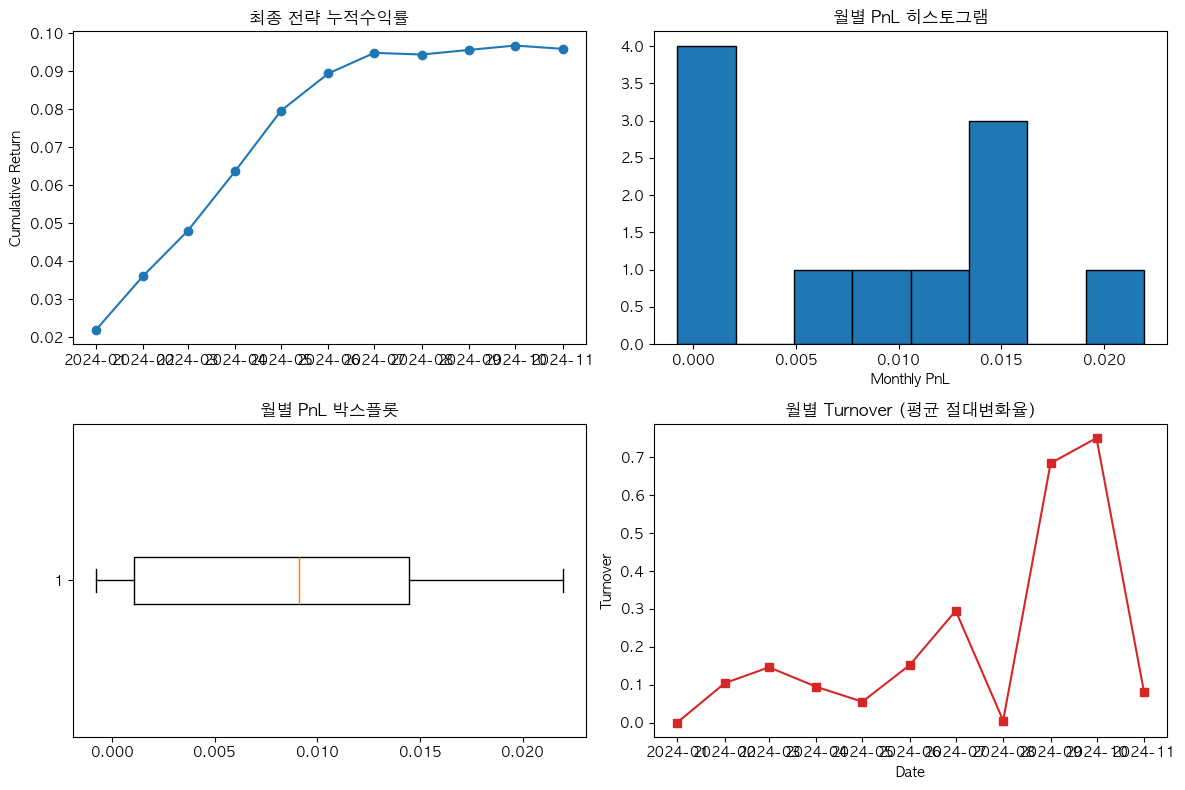

In [180]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ─────────────────────────────────────────────────
# 0. 환경 설정
# ─────────────────────────────────────────────────
plt.rcParams['font.family'] = 'AppleGothic'
plt.rcParams['axes.unicode_minus'] = False

# ─────────────────────────────────────────────────
# 1. 데이터 로드
# ─────────────────────────────────────────────────
test = pd.read_csv("/Users/gun/Desktop/경종설/국내/test_merged_with_preds.csv", parse_dates=["기준월"])

# ─────────────────────────────────────────────────
# 2. 3M 예측을 5분위로 나누고, 분위별 강도 매핑
# ─────────────────────────────────────────────────
test["q5_3M"] = pd.qcut(test["pred_3M_return"], 5, labels=False)
weight_map = {0:0.00, 1:0.25, 2:0.50, 3:0.75, 4:1.00}
test["signal_strength"] = test["q5_3M"].map(weight_map)

# ─────────────────────────────────────────────────
# 3. 1M 보조 필터: 해당 월 상위 30% pred_1M_return만 남기고 나머지는 0
# ─────────────────────────────────────────────────
th = test.groupby("기준월")["pred_1M_return"].transform(lambda x: x.quantile(0.70))
test.loc[test["pred_1M_return"] < th, "signal_strength"] = 0

# ─────────────────────────────────────────────────
# 4. 월별 PnL 계산 (분기 리밸 → 3M 대상)
# ─────────────────────────────────────────────────
# 그룹별로 월(月)마다 signal_strength * 실제 3M 수익 → 월별 평균 pnl
monthly = (
    test
    .groupby("기준월", as_index=True)
    .apply(lambda g: (g["signal_strength"] * g["next_3M_return"]).mean())
    .rename("monthly_pnl")
    .to_frame()
)

# 누적수익률, 샤프, 최대낙폭 계산
monthly["cum_return"] = (1 + monthly["monthly_pnl"]).cumprod() - 1
arr = monthly["monthly_pnl"].values
sharpe = arr.mean() / (arr.std() + 1e-9) * np.sqrt(12/3)  # 분기 리밸이므로 연환산 계수 √(12/3)
cum   = monthly["cum_return"].iloc[-1]
dd    = monthly["cum_return"] + 1
dd    = dd / dd.cummax() - 1
maxdd = dd.min()

# ─────────────────────────────────────────────────
# 5. 결과 출력
# ─────────────────────────────────────────────────
print("=== 최종 전략 성과 ===")
print(f"누적수익률: {cum:.4f}")
print(f"연환산 샤프비: {sharpe:.4f}")
print(f"최대 낙폭: {maxdd:.4f}\n")

print("월별 PnL 통계:")
print(monthly["monthly_pnl"].describe().round(4))

# ─────────────────────────────────────────────────
# 6. 시각화
# ─────────────────────────────────────────────────
fig, axes = plt.subplots(2, 2, figsize=(12,8))

# (1) 누적수익률
axes[0,0].plot(monthly.index, monthly["cum_return"], marker="o")
axes[0,0].set_title("최종 전략 누적수익률")
axes[0,0].set_ylabel("Cumulative Return")

# (2) 월별 PnL 히스토그램
axes[0,1].hist(monthly["monthly_pnl"], bins=8, edgecolor="k")
axes[0,1].set_title("월별 PnL 히스토그램")
axes[0,1].set_xlabel("Monthly PnL")

# (3) 월별 PnL 박스플롯
axes[1,0].boxplot(monthly["monthly_pnl"], vert=False)
axes[1,0].set_title("월별 PnL 박스플롯")

# (4) 월별 turnover (절대변화 비율)
#    turnover = |position_this_month - position_last_month| / position_last_month
#    여기선 signal_strength이 포지션 비중이므로, 월별 그룹 내 평균 strength를 turnover proxy로 사용
turn = (
    test
    .groupby("기준월")["signal_strength"]
    .mean()
    .pct_change()
    .abs()
    .fillna(0)
)
axes[1,1].plot(turn.index, turn.values, marker="s", color="C3")
axes[1,1].set_title("월별 Turnover (평균 절대변화율)")
axes[1,1].set_xlabel("Date")
axes[1,1].set_ylabel("Turnover")

plt.tight_layout()
plt.show()

=== 스무딩 + 1M 필터(Final) 전략 (분기 리밸) ===
누적수익률: 0.0032
연환산 샤프비: 0.8644
최대 낙폭: -0.0019


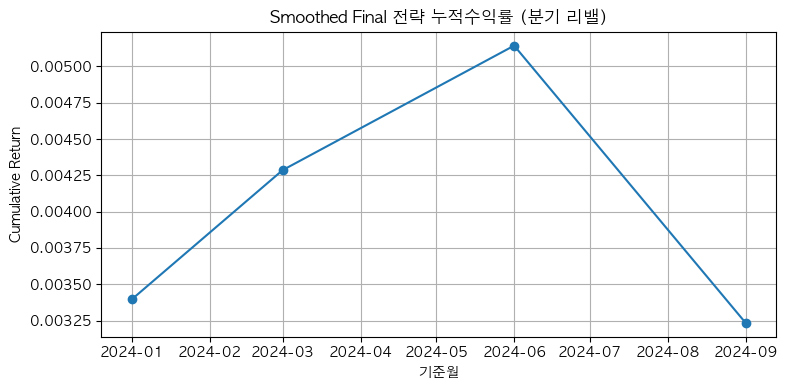


평균 분기 Turnover: 0.0007


In [181]:
import pandas as pd
import numpy as np

# (이미 lgbm 학습 → test_merged 에 pred_1M_return, pred_3M_return, next_1M_return, next_3M_return 컬럼이 있다고 가정)

# ─────────────────────────────────────────────────
# 1) 신호 스무딩: EWMA 적용
# ─────────────────────────────────────────────────
test_merged["pred_3M_ewm"] = (
    test_merged
    .groupby("회사명")["pred_3M_return"]
    .transform(lambda x: x.ewm(span=3, adjust=False).mean())
)
test_merged["pred_1M_ewm"] = (
    test_merged
    .groupby("회사명")["pred_1M_return"]
    .transform(lambda x: x.ewm(span=2, adjust=False).mean())
)

# ─────────────────────────────────────────────────
# 2) 시그널 생성 함수 (Long-Short)
# ─────────────────────────────────────────────────
def gen_ls(df, pred_col, top_pct=0.3):
    df = df.sort_values(pred_col, ascending=False).reset_index(drop=True)
    n   = len(df)
    k   = int(np.floor(n * top_pct))
    sig = np.zeros(n, dtype=int)
    if k > 0:
        sig[:k]   =  1
        sig[-k:]  = -1
    df["signal"] = sig
    return df

# ─────────────────────────────────────────────────
# 3) 월별/분기별 스무딩 신호 생성
# ─────────────────────────────────────────────────
smoothed = (
    test_merged
    .groupby("기준월", group_keys=False)
    .apply(lambda df: pd.DataFrame({
        **df,
        # 3M LS 스무딩 신호
        "signal_3M_ls_ewm": gen_ls(df, "pred_3M_ewm")["signal"],
        # 1M LS 스무딩 필터
        "signal_1M_ls_ewm": gen_ls(df, "pred_1M_ewm")["signal"],
    }))
    .reset_index(drop=True)
)

# ─────────────────────────────────────────────────
# 4) 최종 시그널: 1M 필터=롱인 경우에만 3M_LS, 아니면 0
# ─────────────────────────────────────────────────
smoothed["signal_final_ewm"] = np.where(
    smoothed["signal_1M_ls_ewm"] == 1,
    smoothed["signal_3M_ls_ewm"],
    0
)

# ─────────────────────────────────────────────────
# 5) 분기 리밸(3M), 최종 백테스트
# ─────────────────────────────────────────────────
# 기준월을 3개월 간격으로 뽑아서 분기 리밸을 시뮬
unique_months = sorted(smoothed["기준월"].unique())
quarter_months = unique_months[::3]  # 분기마다 리밸

monthly_pnls = []
for mon in quarter_months:
    grp = smoothed[smoothed["기준월"] == mon]
    pnl = (grp["signal_final_ewm"] * grp["next_3M_return"]).mean()
    monthly_pnls.append((mon, pnl))

perf = (
    pd.DataFrame(monthly_pnls, columns=["기준월", "monthly_pnl"])
      .set_index("기준월")
)
perf["cum_return"] = (1 + perf["monthly_pnl"]).cumprod() - 1

# 리스크·성과 지표
arr     = perf["monthly_pnl"].values
sharpe  = arr.mean() / (arr.std() + 1e-9) * np.sqrt(12/3)  # 분기 빈도로 연환산
cum_r   = perf["cum_return"].iloc[-1]
drawdown= perf["cum_return"] + 1
drawdown= drawdown / drawdown.cummax() - 1
maxdd   = drawdown.min()

print("=== 스무딩 + 1M 필터(Final) 전략 (분기 리밸) ===")
print(f"누적수익률: {cum_r:.4f}")
print(f"연환산 샤프비: {sharpe:.4f}")
print(f"최대 낙폭: {maxdd:.4f}")

# ─────────────────────────────────────────────────
# 6) 시각화
# ─────────────────────────────────────────────────
import matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
plt.plot(perf.index, perf["cum_return"], marker="o")
plt.title("Smoothed Final 전략 누적수익률 (분기 리밸)")
plt.xlabel("기준월")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.tight_layout()
plt.show()

# Turnover 확인 (평균 절대 변화율)
turn = (
    smoothed
    .groupby("기준월")["signal_final_ewm"]
    .apply(lambda s: s.diff().abs().mean())
    .loc[quarter_months]
)
print("\n평균 분기 Turnover:", turn.mean().round(4))

=== 월간 리밸 + 1M 필터 × 3M_LS 전략 ===
누적수익률: 0.8434
연환산 샤프비: 30.2123
최대 낙폭: 0.0000



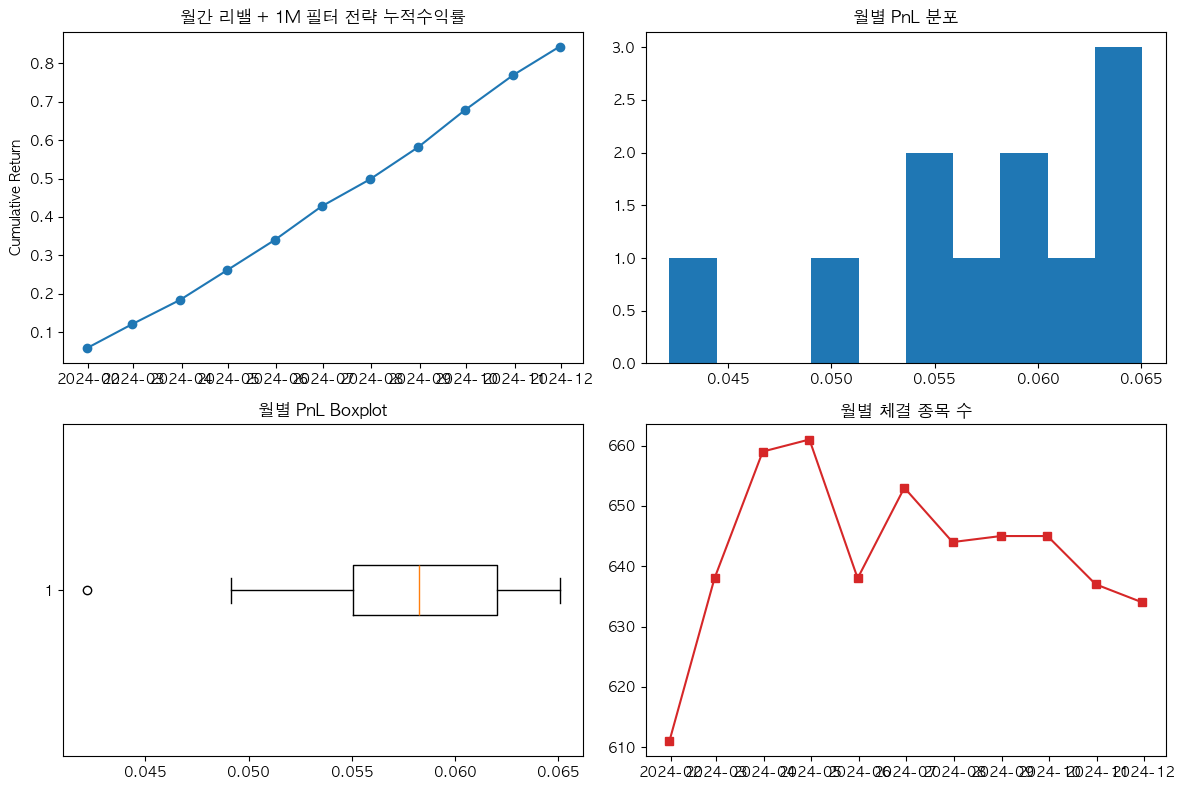

In [183]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt

# ─────────────────────────────────────────────────
# 0. 파일 경로 설정
# ─────────────────────────────────────────────────
factor_train_path = "/Users/gun/Desktop/경종설/국내/train_stock_0.3_ind_neutral.csv"
factor_test_path  = "/Users/gun/Desktop/경종설/국내/test_stock_0.3_ind_neutral.csv"
orig_train_path   = "/Users/gun/Desktop/경종설/국내/train_stock_0.3.csv"
orig_test_path    = "/Users/gun/Desktop/경종설/국내/test_stock_0.3.csv"

# ─────────────────────────────────────────────────
# 1. 데이터 로드
# ─────────────────────────────────────────────────
df_factor_train = pd.read_csv(factor_train_path, parse_dates=["기준월"])
df_factor_test  = pd.read_csv(factor_test_path,  parse_dates=["기준월"])
df_orig_train   = pd.read_csv(orig_train_path,   parse_dates=["기준월"])
df_orig_test    = pd.read_csv(orig_test_path,    parse_dates=["기준월"])

# ─────────────────────────────────────────────────
# 2. 익월/익분기 수익(next_1M_return, next_3M_return) 생성
# ─────────────────────────────────────────────────
def add_next_returns(df):
    df = df.sort_values(["회사명","기준월"]).reset_index(drop=True)
    df["next_1M_return"] = df.groupby("회사명")["1개월수익률"].shift(-1)
    df["next_3M_return"] = df.groupby("회사명")["3개월수익률"].shift(-1)
    return df

df_orig_train = add_next_returns(df_orig_train)
df_orig_test  = add_next_returns(df_orig_test)

# ─────────────────────────────────────────────────
# 3. 팩터 + 타깃 병합
# ─────────────────────────────────────────────────
train = pd.merge(
    df_factor_train,
    df_orig_train[["기준월","회사명","next_1M_return","next_3M_return"]],
    on=["기준월","회사명"], how="inner"
).dropna()

test = pd.merge(
    df_factor_test,
    df_orig_test[["기준월","회사명","next_1M_return","next_3M_return"]],
    on=["기준월","회사명"], how="inner"
).dropna()

# ─────────────────────────────────────────────────
# 4. 로그 변환 + 윈저라이즈
# ─────────────────────────────────────────────────
for df in (train, test):
    for h in ("1M","3M"):
        col    = f"next_{h}_return"
        logcol = f"{h}_log"
        df[logcol] = np.log1p(df[col])
        lo = df[logcol].quantile(0.005)
        hi = df[logcol].quantile(0.995)
        df[logcol] = df[logcol].clip(lo, hi)

# ─────────────────────────────────────────────────
# 5. LightGBM 학습 & 예측
# ─────────────────────────────────────────────────
features = ["value_score","quality_score","momentum_score","size_score","lowvol_score"]
models = {}
for h in ("1M","3M"):
    m = lgb.LGBMRegressor(
        objective="regression", metric="rmse", learning_rate=0.05,
        num_leaves=31, min_data_in_leaf=20,
        feature_fraction=0.8, bagging_fraction=0.8, bagging_freq=1,
        n_estimators=200, random_state=42, n_jobs=-1, verbose=-1
    )
    m.fit(train[features], train[f"{h}_log"])
    models[h] = m
    test[f"pred_{h}_log"]    = m.predict(test[features])
    test[f"pred_{h}_return"] = np.expm1(test[f"pred_{h}_log"])

# ─────────────────────────────────────────────────
# 6. 시그널 생성 함수 정의
# ─────────────────────────────────────────────────
def gen_ls(df, pred, top=0.3):
    df = df.sort_values(pred, ascending=False).reset_index(drop=True)
    n, k = len(df), int(len(df)*top)
    df["signal_ls"] = 0
    if k>0:
        df.loc[:k-1, "signal_ls"] =  1
        df.loc[n-k:, "signal_ls"] = -1
    return df

# ─────────────────────────────────────────────────
# 7. 월간 리밸 + 1M 필터 × 3M LS 백테스트
# ─────────────────────────────────────────────────
monthly_rows = []
for month, grp in test.groupby(pd.Grouper(key="기준월", freq="M")):
    tmp = grp.copy()
    # 1) 3M Long-Short
    tmp = gen_ls(tmp, "pred_3M_return", top=0.3).rename(columns={"signal_ls":"signal_3M_ls"})
    # 2) 1M Long-Short
    tmp = gen_ls(tmp, "pred_1M_return", top=0.3).rename(columns={"signal_ls":"signal_1M_ls"})
    # 3) 최종 시그널: 1M 시그널이 0이 아닐 때만 3M 시그널 유지
    tmp["signal_final"] = tmp["signal_3M_ls"].where(tmp["signal_1M_ls"] != 0, 0)
    # 4) 월별 PnL, 체결 종목 수 저장
    pnl = (tmp["signal_final"] * tmp["next_3M_return"]).mean()
    monthly_rows.append((month, pnl, (tmp["signal_final"] != 0).sum()))

perf = pd.DataFrame(
    monthly_rows,
    columns=["기준월","monthly_pnl","n_positions"]
).set_index("기준월")

# ─────────────────────────────────────────────────
# 8. 성과 지표 계산
# ─────────────────────────────────────────────────
perf["cum_return"] = (1 + perf["monthly_pnl"]).cumprod() - 1
arr = perf["monthly_pnl"].values
sharpe = arr.mean()/(arr.std()+1e-9)*np.sqrt(12)
cum    = perf["cum_return"].iloc[-1]
dd     = perf["cum_return"]+1
maxdd  = (dd / dd.cummax() - 1).min()

print("=== 월간 리밸 + 1M 필터 × 3M_LS 전략 ===")
print(f"누적수익률: {cum:.4f}")
print(f"연환산 샤프비: {sharpe:.4f}")
print(f"최대 낙폭: {maxdd:.4f}\n")

# ─────────────────────────────────────────────────
# 9. 시각화
# ─────────────────────────────────────────────────
fig, axes = plt.subplots(2,2,figsize=(12,8))
ax1, ax2, ax3, ax4 = axes.flatten()

# (1) 누적 수익률
ax1.plot(perf.index, perf["cum_return"], marker="o")
ax1.set_title("월간 리밸 + 1M 필터 전략 누적수익률")
ax1.set_ylabel("Cumulative Return")

# (2) 월별 PnL 분포
ax2.hist(perf["monthly_pnl"], bins=10)
ax2.set_title("월별 PnL 분포")

# (3) 월별 PnL 박스플롯
ax3.boxplot(perf["monthly_pnl"], vert=False)
ax3.set_title("월별 PnL Boxplot")

# (4) 월별 체결 종목 수
ax4.plot(perf.index, perf["n_positions"], marker="s", color="C3")
ax4.set_title("월별 체결 종목 수")

plt.tight_layout()
plt.show()

          Sharpe  CumReturn  MaxDrawdown
top_pct                                 
0.1000   29.8046     0.8469       0.0000
0.2000   29.8046     0.8469       0.0000
0.3000   29.8046     0.8469       0.0000
0.4000   29.8046     0.8469       0.0000
0.5000   29.8046     0.8469       0.0000


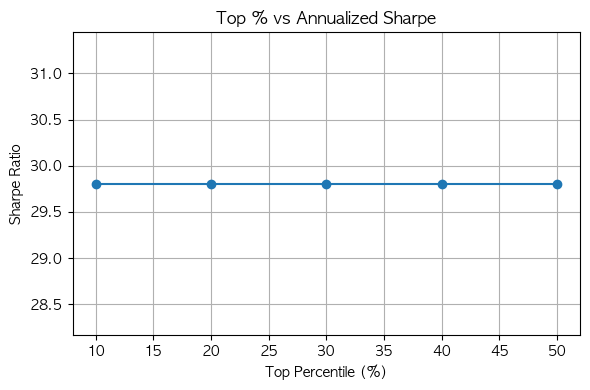

In [187]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# 1) Long-Short 신호 생성 함수
def gen_ls(df, pred_col, top_pct=0.3):
    df = df.sort_values(pred_col, ascending=False).reset_index(drop=True)
    n = len(df)
    k = int(np.floor(n * top_pct))
    df["signal"] = 0
    if k > 0:
        df.loc[:k-1, "signal"] =  1
        df.loc[n-k:, "signal"] = -1
    return df

# 2) 백테스트 함수: 3M_LS × 1M_LS 필터 전략
def run_backtest(top_pct):
    records = []
    # 월 단위 그룹
    for mon, grp in test_merged.groupby(pd.Grouper(key="기준월", freq="M")):
        tmp = grp.copy().reset_index(drop=True)
        # 2-1) 3M Long-Short
        tmp = gen_ls(tmp, "pred_3M_return", top_pct).rename(columns={"signal":"signal_3M_ls"})
        # 2-2) 1M Long-Short (필터)
        tmp = gen_ls(tmp, "pred_1M_return", top_pct).rename(columns={"signal":"signal_1M_ls"})
        # 2-3) 최종 시그널: signal_1M_ls != 0 인 경우에만 3M 신호 살리고, 나머지는 0
        tmp["signal_final"] = np.where(tmp["signal_1M_ls"] != 0,
                                       tmp["signal_3M_ls"],
                                       0)
        # 2-4) 월별 PnL = 평균(signal_final × 실제 3M 수익)
        pnl = (tmp["signal_final"] * tmp["next_3M_return"]).mean()
        records.append((mon, pnl))

    perf = pd.DataFrame(records, columns=["기준월","monthly_pnl"]).set_index("기준월")
    perf["cum_return"] = (1 + perf["monthly_pnl"]).cumprod() - 1

    arr = perf["monthly_pnl"].values
    sharpe = arr.mean() / (arr.std()+1e-9) * np.sqrt(12)
    maxdd  = (perf["cum_return"] + 1).div((perf["cum_return"] + 1).cummax()).sub(1).min()
    return sharpe, perf["cum_return"].iloc[-1], maxdd, perf

# 3) 톱티어 비율별 결과 비교
results = []
for pct in [0.1, 0.2, 0.3, 0.4, 0.5]:
    sharpe, cumret, maxdd, perf = run_backtest(pct)
    results.append({
        "top_pct": pct,
        "Sharpe": sharpe,
        "CumReturn": cumret,
        "MaxDrawdown": maxdd
    })

df_res = pd.DataFrame(results).set_index("top_pct")
print(df_res)

# 4) 샤프 대비 top_pct 시각화
plt.figure(figsize=(6,4))
plt.plot(df_res.index*100, df_res["Sharpe"], marker="o")
plt.title("Top % vs Annualized Sharpe")
plt.xlabel("Top Percentile (%)")
plt.ylabel("Sharpe Ratio")
plt.grid(True)
plt.tight_layout()
plt.show()

         Sharpe  CumReturn  MaxDrawdown
Period                                 
1M      30.2123     0.8434       0.0000
2M      18.6286     0.3792       0.0000
3M      19.8988     0.2462       0.0000
6M      16.7020     0.1102       0.0000


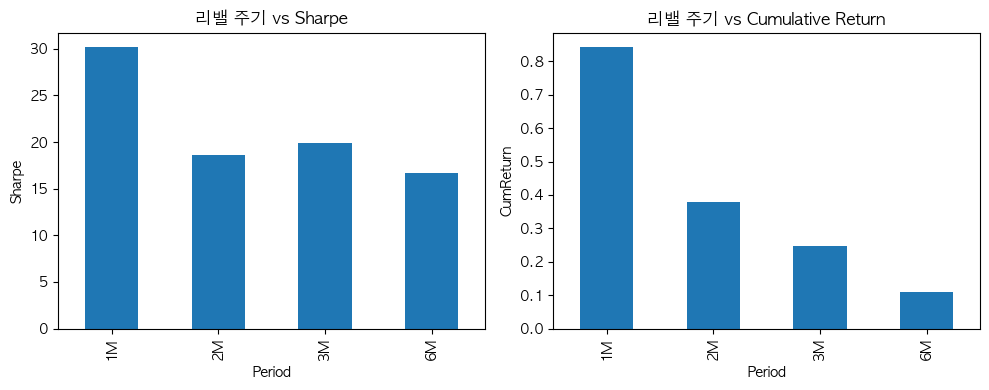

In [188]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# ─────────────────────────────────────────────────
# 0) test_merged: 앞에서 만드신 test_merged 로드
#    (기준월, pred_1M_return, pred_3M_return, next_1M_return, next_3M_return, … 포함)
# ─────────────────────────────────────────────────

# 1) Long-Short 신호 생성
def gen_ls(df, pred_col, top_pct=0.3):
    df = df.sort_values(pred_col, ascending=False).reset_index(drop=True)
    n = len(df); k = int(n * top_pct)
    df["signal"] = 0
    if k>0:
        df.loc[:k-1, "signal"] =  1
        df.loc[n-k:, "signal"] = -1
    return df

# 2) 주기별 백테스트 함수
def backtest_by_period(months, top_pct=0.3):
    records = []
    # 기준월을 months개월 간격으로 리샘플 -> 리밸 시점
    dates = test_merged["기준월"].sort_values().unique()[::months]
    for mon in dates:
        grp = test_merged[test_merged["기준월"] == mon].copy()
        # 2-1) 3M Long-Short
        grp = gen_ls(grp, "pred_3M_return", top_pct).rename(columns={"signal":"sig_3M"})
        # 2-2) 1M Long-Short 필터
        grp = gen_ls(grp, "pred_1M_return", top_pct).rename(columns={"signal":"sig_1M"})
        # 2-3) 필터 적용: 1M 신호 ≠ 0 인 종목만 3M 신호 사용
        grp["sig_final"] = np.where(grp["sig_1M"]!=0, grp["sig_3M"], 0)
        # 2-4) 월별/분기별 PnL
        pnl = (grp["sig_final"] * grp["next_3M_return"]).mean()
        records.append((mon, pnl))
    perf = pd.DataFrame(records, columns=["기준월","pnl"]).set_index("기준월")
    perf["cumret"] = (1+perf["pnl"]).cumprod() - 1
    arr = perf["pnl"].values
    sharpe = arr.mean()/(arr.std()+1e-9)*np.sqrt(12/months)
    maxdd  = (perf["cumret"]+1).div((perf["cumret"]+1).cummax()).sub(1).min()
    return sharpe, perf["cumret"].iloc[-1], maxdd, perf

# 3) 리밸 주기별 성과 비교
periods = [1,2,3,6]
res = []
for m in periods:
    shrp, cumr, dd, _ = backtest_by_period(m, top_pct=0.3)
    res.append({"Period":f"{m}M", "Sharpe":shrp, "CumReturn":cumr, "MaxDrawdown":dd})
df_compare = pd.DataFrame(res).set_index("Period")
print(df_compare)

# 4) 시각화
fig, ax = plt.subplots(1,2,figsize=(10,4))
df_compare["Sharpe"].plot(kind="bar", ax=ax[0], title="리밸 주기 vs Sharpe")
ax[0].set_ylabel("Sharpe")
df_compare["CumReturn"].plot(kind="bar", ax=ax[1], title="리밸 주기 vs Cumulative Return")
ax[1].set_ylabel("CumReturn")
plt.tight_layout()
plt.show()

=== Weighted Final 전략 성과 ===
누적수익률: 7.7553
연환산 샤프비: 17.9572
최대낙폭: 0.0000


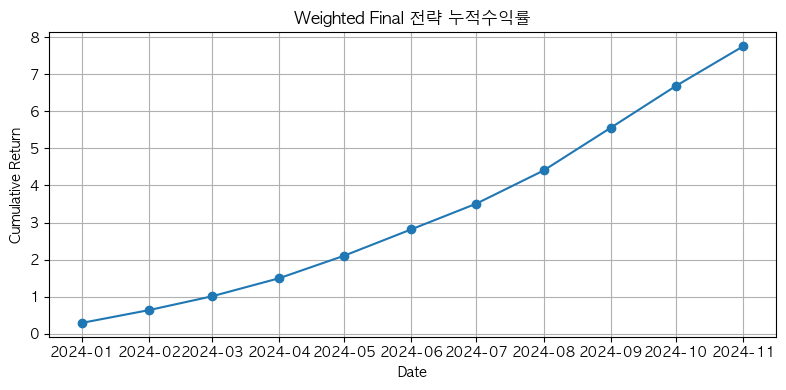

In [194]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt

# ─────────────────────────────────────────────────
# 0. 파일 경로 설정
# ─────────────────────────────────────────────────
factor_train_path = "/Users/gun/Desktop/경종설/국내/train_stock_0.3_ind_neutral.csv"
factor_test_path  = "/Users/gun/Desktop/경종설/국내/test_stock_0.3_ind_neutral.csv"
orig_train_path   = "/Users/gun/Desktop/경종설/국내/train_stock_0.3.csv"
orig_test_path    = "/Users/gun/Desktop/경종설/국내/test_stock_0.3.csv"

# ─────────────────────────────────────────────────
# 1. 데이터 로드 및 next_return 생성
# ─────────────────────────────────────────────────
def add_next_returns(df):
    df = df.sort_values(["회사명","기준월"]).reset_index(drop=True)
    df["next_1M_return"] = df.groupby("회사명")["1개월수익률"].shift(-1)
    df["next_3M_return"] = df.groupby("회사명")["3개월수익률"].shift(-1)
    return df

df_factor_train = pd.read_csv(factor_train_path, parse_dates=["기준월"])
df_factor_test  = pd.read_csv(factor_test_path,  parse_dates=["기준월"])
df_orig_train   = pd.read_csv(orig_train_path,   parse_dates=["기준월"])
df_orig_test    = pd.read_csv(orig_test_path,    parse_dates=["기준월"])

df_orig_train = add_next_returns(df_orig_train)
df_orig_test  = add_next_returns(df_orig_test)

# ─────────────────────────────────────────────────
# 2. 팩터와 타깃 병합
# ─────────────────────────────────────────────────
train = pd.merge(
    df_factor_train,
    df_orig_train[["기준월","회사명","next_1M_return","next_3M_return"]],
    on=["기준월","회사명"], how="inner"
).dropna()
test_merged = pd.merge(
    df_factor_test,
    df_orig_test[["기준월","회사명","next_1M_return","next_3M_return"]],
    on=["기준월","회사명"], how="inner"
).dropna()

# ─────────────────────────────────────────────────
# 3. 로그 변환 + 윈저라이즈
# ─────────────────────────────────────────────────
for df in (train, test_merged):
    for h in ("1M","3M"):
        col    = f"next_{h}_return"
        logcol = f"{h}_log"
        df[logcol] = np.log1p(df[col])
        lo, hi = df[logcol].quantile([0.005,0.995])
        df[logcol] = df[logcol].clip(lo, hi)

# ─────────────────────────────────────────────────
# 4. LightGBM 학습 & 예측
# ─────────────────────────────────────────────────
features = ["value_score","quality_score","momentum_score","size_score","lowvol_score"]
models = {}
for h in ("1M","3M"):
    m = lgb.LGBMRegressor(
        objective="regression", metric="rmse", learning_rate=0.05,
        num_leaves=31, min_data_in_leaf=20,
        feature_fraction=0.8, bagging_fraction=0.8, bagging_freq=1,
        n_estimators=200, random_state=42, n_jobs=-1, verbose=-1
    )
    m.fit(train[features], train[f"{h}_log"])
    models[h] = m
    test_merged[f"pred_{h}_log"]    = m.predict(test_merged[features])
    test_merged[f"pred_{h}_return"] = np.expm1(test_merged[f"pred_{h}_log"])

# ─────────────────────────────────────────────────
# 5. Long-Short 시그널 생성 (오류 수정)
# ─────────────────────────────────────────────────
def gen_ls(df, pred_col, top_pct=0.3):
    df = df.sort_values(pred_col, ascending=False).reset_index(drop=True)
    length = len(df)
    k = int(length * top_pct)
    df["signal"] = 0
    if k > 0:
        df.loc[:k-1, "signal"]   =  1
        df.loc[length-k:, "signal"] = -1
    return df

# ─────────────────────────────────────────────────
# 6. 가중치 백테스트 함수
# ─────────────────────────────────────────────────
def backtest_weighted(top_pct=0.3, tc=0.0005):
    recs = []
    months = sorted(test_merged["기준월"].unique())
    prev_w = None

    for mon in months:
        grp = test_merged[test_merged["기준월"]==mon].copy()
        # 3M LS
        grp = gen_ls(grp, "pred_3M_return", top_pct).rename(columns={"signal":"sig3"})
        # 1M LS 필터
        grp = gen_ls(grp, "pred_1M_return", top_pct).rename(columns={"signal":"sig1"})
        # 필터 적용
        grp["sig"] = np.where(grp["sig1"]!=0, grp["sig3"], 0)
        # 절대 예측치 기반 가중치
        grp["w_raw"] = grp["sig"] * grp["pred_3M_return"].abs()
        s = grp["w_raw"].abs().sum()
        grp["w"] = grp["w_raw"] / s if s>0 else 0.0

        # 거래비용: 포지션 변경분
        if prev_w is None:
            cost = 0.0
        else:
            cost = (grp["w"].subtract(prev_w, fill_value=0).abs().sum()) * tc

        pnl = (grp["w"] * grp["next_3M_return"]).sum() - cost
        recs.append((mon, pnl, grp["w"]))
        prev_w = grp["w"]

    # 성과 집계
    perf = pd.DataFrame(
        [(d,p) for d,p,_ in recs],
        columns=["기준월","pnl"]
    ).set_index("기준월")
    perf["cumret"] = (1+perf["pnl"]).cumprod() - 1

    arr = perf["pnl"].values
    sharpe = arr.mean()/(arr.std()+1e-9)*np.sqrt(12)
    maxdd  = (perf["cumret"]+1).div((perf["cumret"]+1).cummax()).sub(1).min()

    return perf, sharpe, perf["cumret"].iloc[-1], maxdd

# ─────────────────────────────────────────────────
# 7. 실행 & 출력
# ─────────────────────────────────────────────────
perf_w, sharpe_w, cum_w, dd_w = backtest_weighted(top_pct=0.3, tc=0.0005)

print("=== Weighted Final 전략 성과 ===")
print(f"누적수익률: {cum_w:.4f}")
print(f"연환산 샤프비: {sharpe_w:.4f}")
print(f"최대낙폭: {dd_w:.4f}")

# ─────────────────────────────────────────────────
# 8. 누적수익률 시각화
# ─────────────────────────────────────────────────
plt.figure(figsize=(8,4))
plt.plot(perf_w.index, perf_w["cumret"], marker='o')
plt.title("Weighted Final 전략 누적수익률")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.tight_layout()
plt.show()

=== Rolling Backtest 결과 ===
누적수익률: 0.4030, Sharpe: 22.2911, MaxDD: 0.0000


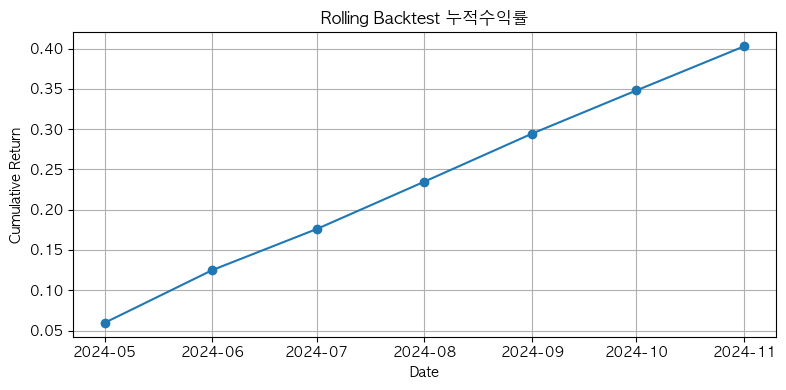

In [213]:
import numpy as np
import pandas as pd
import lightgbm as lgb
import matplotlib.pyplot as plt

def rolling_backtest(df, train_window=12, top_pct=0.3, tc=0.0005):
    months = sorted(df["기준월"].unique())
    results = []

    # 매월 하나씩 롤링
    for i in range(train_window, len(months)):
        train_months = months[i-train_window : i]
        test_month   = months[i]

        train = df[df["기준월"].isin(train_months)]
        test  = df[df["기준월"] == test_month].copy()

        # 3M 모델 훈련/예측
        features = ["value_score","quality_score","momentum_score","size_score","lowvol_score"]
        m3 = lgb.LGBMRegressor(
            objective="regression", metric="rmse", learning_rate=0.05,
            num_leaves=31, min_data_in_leaf=20, feature_fraction=0.8,
            bagging_fraction=0.8, bagging_freq=1, n_estimators=200,
            random_state=42, n_jobs=-1, verbose=-1
        )
        m3.fit(train[features], train["3M_log"])
        test["pred_3M_return"] = np.expm1(m3.predict(test[features]))

        # 1M 모델 훈련/예측 (필터 용)
        m1 = lgb.LGBMRegressor(**m3.get_params())
        m1.set_params(n_estimators=200)
        m1.fit(train[features], train["1M_log"])
        test["pred_1M_return"] = np.expm1(m1.predict(test[features]))

        # 신호 생성 함수
        def gen_ls(arr, top=top_pct):
            n = len(arr)
            k = int(n * top)
            sig = np.zeros(n, dtype=int)
            if k > 0:
                idx = np.argsort(-arr.values)
                sig[idx[:k]]  =  1
                sig[idx[-k:]] = -1
            return sig

        sig3 = gen_ls(test["pred_3M_return"])
        sig1 = gen_ls(test["pred_1M_return"])
        sig_final = np.where(sig1!=0, sig3, 0)

        # 거래비용 반영 PnL
        turnover = np.mean(np.abs(np.diff(np.hstack([[0], sig_final]))))
        pnl = (sig_final * test["next_3M_return"]).mean()
        pnl_net = pnl - turnover * tc

        results.append((test_month, pnl_net))

    # results 체크
    if not results:
        raise ValueError("학습 윈도우(train_window)가 너무 깁니다. 더 짧게 설정해주세요.")

    # 성과 DataFrame
    df_perf = pd.DataFrame(results, columns=["기준월","pnl"]).set_index("기준월")
    df_perf["cumret"] = (1 + df_perf["pnl"]).cumprod() - 1

    arr = df_perf["pnl"].values
    # 표준편차 계산 전 길이 체크
    if arr.size < 2:
        sharpe = 0.0
    else:
        sharpe = arr.mean() / (arr.std() + 1e-9) * np.sqrt(12)

    cum = df_perf["cumret"].iloc[-1]
    dd = df_perf["cumret"] + 1
    maxdd = (dd / dd.cummax() - 1).min()

    return df_perf, sharpe, cum, maxdd

# ─────────────────────────────────────────────────
# 실행 예시
perf_roll, shrp_roll, cum_roll, dd_roll = rolling_backtest(test_merged, train_window=4)
print("=== Rolling Backtest 결과 ===")
print(f"누적수익률: {cum_roll:.4f}, Sharpe: {shrp_roll:.4f}, MaxDD: {dd_roll:.4f}")

# 누적수익률 시각화
plt.figure(figsize=(8,4))
plt.plot(perf_roll.index, perf_roll["cumret"], marker="o")
plt.title("Rolling Backtest 누적수익률")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.tight_layout()
plt.show()

In [221]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from sklearn.metrics import mean_squared_error
from datetime import datetime

# ─────────────────────────────────────────────────
# 0. 데이터 로드 & 전처리 (이전과 동일)
# ─────────────────────────────────────────────────
df_factor_train = pd.read_csv(factor_train_path, parse_dates=["기준월"])
df_factor_test  = pd.read_csv(factor_test_path,  parse_dates=["기준월"])
df_orig_train   = pd.read_csv(orig_train_path,   parse_dates=["기준월"])
df_orig_test    = pd.read_csv(orig_test_path,    parse_dates=["기준월"])

def add_next_returns(df):
    df = df.sort_values(["회사명","기준월"]).reset_index(drop=True)
    df["next_1M_return"] = df.groupby("회사명")["1개월수익률"].shift(-1)
    df["next_3M_return"] = df.groupby("회사명")["3개월수익률"].shift(-1)
    return df

df_orig_train = add_next_returns(df_orig_train)
df_orig_test  = add_next_returns(df_orig_test)

train = pd.merge(df_factor_train,
                 df_orig_train[["기준월","회사명","next_1M_return","next_3M_return"]],
                 on=["기준월","회사명"]).dropna()
test  = pd.merge(df_factor_test,
                 df_orig_test[["기준월","회사명","next_1M_return","next_3M_return"]],
                 on=["기준월","회사명"]).dropna()

# 로그 변환 + 윈저라이즈
for df in (train, test):
    for h in ("1M","3M"):
        c, l = f"next_{h}_return", f"{h}_log"
        df[l] = np.log1p(df[c])
        lo, hi = df[l].quantile(0.005), df[l].quantile(0.995)
        df[l]  = df[l].clip(lo, hi)

features = ["value_score","quality_score","momentum_score","size_score","lowvol_score"]

# 모델 학습
models = {}
for h in ("1M","3M"):
    m = lgb.LGBMRegressor(
        objective="regression", metric="rmse", learning_rate=0.05,
        num_leaves=31, min_data_in_leaf=20,
        feature_fraction=0.8, bagging_fraction=0.8, bagging_freq=1,
        n_estimators=200, random_state=42, n_jobs=-1, verbose=-1
    )
    m.fit(train[features], train[f"{h}_log"])
    models[h] = m
    test[f"pred_{h}_log"]    = m.predict(test[features])
    test[f"pred_{h}_return"] = np.expm1(test[f"pred_{h}_log"])

# 신호 생성 함수
def gen_ls(df, pred_col, top_pct):
    df = df.sort_values(pred_col, ascending=False).reset_index(drop=True)
    n, k = len(df), int(len(df)*top_pct)
    sig = np.zeros(n, dtype=int)
    if k>0:
        sig[:k]   =  1
        sig[-k:]  = -1
    df["signal"] = sig
    return df

# 전략 백테스트 (월별 리밸)
def run_backtest(reb_months, top_pct, tc):
    """
    reb_months: 리밸 주기 (1=월간, 3=분기, ...)
    top_pct   : 톱티어 백분율
    tc        : round-trip 거래비용 (e.g. 0.0005 = 0.05%)
    """
    months = sorted(test["기준월"].unique())
    # 리밸 포인트: 매 reb_months 간격으로 뽑은 month 리스트
    reb_pts = months[::reb_months]
    pnl_list = []
    
    for mon in reb_pts:
        grp = test[test["기준월"] == mon].copy()
        # 1) 3M Long-Short
        grp = gen_ls(grp, "pred_3M_return", top_pct).rename(columns={"signal":"s3"})
        # 2) 1M Long-Short 필터
        grp = gen_ls(grp, "pred_1M_return", top_pct).rename(columns={"signal":"s1"})
        # 3) 필터 적용
        #    s3를, s1 != 0인 종목에만 살리고 나머지 0
        grp["signal_final"] = grp["s3"].where(grp["s1"]!=0, 0)
        
        # 4) transaction cost 적용: round-trip으로 간주해서
        #    (signal 변화가 있는 종목 수) × tc 차감
        trades = (grp["signal_final"] != grp["signal_final"].shift(1)).sum()
        cost   = trades * tc
        
        # 5) 월별 PnL = mean(signal_final * 실제 3M 수익) − cost
        pnl    = grp["signal_final"].dot(grp["next_3M_return"]) / len(grp) - cost
        pnl_list.append((mon, pnl))
    
    df_perf = pd.DataFrame(pnl_list, columns=["기준월","pnl"]).set_index("기준월")
    df_perf["cumret"] = (1 + df_perf["pnl"]).cumprod() - 1
    
    arr = df_perf["pnl"].values
    sharpe = arr.mean() / (arr.std()+1e-9) * np.sqrt(12 / reb_months)
    cum    = df_perf["cumret"].iloc[-1]
    dd     = (df_perf["cumret"]+1) / (df_perf["cumret"]+1).cummax() - 1
    maxdd  = dd.min()
    return sharpe, cum, maxdd

# ─────────────────────────────────────────────────
# 3. 파라미터 그리드 탐색
# ─────────────────────────────────────────────────
grid = []
for reb in [1,2,3,6]:
    for top in [0.1,0.2,0.3,0.4,0.5]:
        for tc in [0.0, 0.0005, 0.001]:  # 0%, 0.05%, 0.1%
            sr, cr, md = run_backtest(reb, top, tc)
            grid.append({
                "rebalance_months": reb,
                "top_pct": top,
                "tc": tc,
                "Sharpe": sr,
                "CumReturn": cr,
                "MaxDD": md
            })

df_grid = pd.DataFrame(grid)
print(df_grid.pivot_table(
    index=["rebalance_months","top_pct"],
    columns="tc",
    values="Sharpe"
).round(2))

# 필요한 경우, `df_grid`를 CSV로 저장해서 엑셀·파워포인트에 목차별로 가져가시면 됩니다.
# df_grid.to_csv("strategy_grid_results.csv", index=False)

tc                         0.0000    0.0005    0.0010
rebalance_months top_pct                             
1                0.1000   19.3300  -18.8000  -21.3500
                 0.2000   30.9700  -16.1400  -18.6200
                 0.3000   30.2100  -22.2600  -25.1100
                 0.4000   31.1000  -27.5200  -29.8500
                 0.5000   28.0700  -24.7400  -27.0200
2                0.1000   12.5600  -10.7200  -12.8200
                 0.2000   19.2600   -9.8000  -11.4500
                 0.3000   18.6300  -14.0500  -15.9800
                 0.4000   24.9900  -14.9800  -16.6000
                 0.5000   25.0800  -13.3600  -14.9800
3                0.1000   13.3100  -17.8500  -18.3700
                 0.2000   26.3700  -12.9400  -14.1400
                 0.3000   19.9000  -14.4700  -15.4400
                 0.4000   19.1300  -36.0600  -35.1200
                 0.5000   14.3900  -41.1500  -36.9600
6                0.1000   19.3500  -16.5700  -28.0200
                 0.2000   28

                         CumReturn MaxDrawdown   Sharpe
tc                          0.0005      0.0005   0.0005
rebalance_months top_pct                               
1                0.1000     0.3207      0.0000  19.3215
                 0.2000     0.5820      0.0000  30.9571
                 0.3000     0.8391      0.0000  30.1663
                 0.4000     1.0647      0.0000  31.0637
                 0.5000     1.2837      0.0000  27.9792
2                0.1000     0.1545      0.0000   2.5774
                 0.2000     0.2734      0.0000   2.6367
                 0.3000     0.3774      0.0000   2.6334
                 0.4000     0.4623      0.0000   2.6553
                 0.5000     0.5402      0.0000   2.6555
3                0.1000     0.1076      0.0000   1.4857
                 0.2000     0.1816      0.0000   1.5050
                 0.3000     0.2451      0.0000   1.4999
                 0.4000     0.2956      0.0000   1.4989
                 0.5000     0.3402      0.0000  

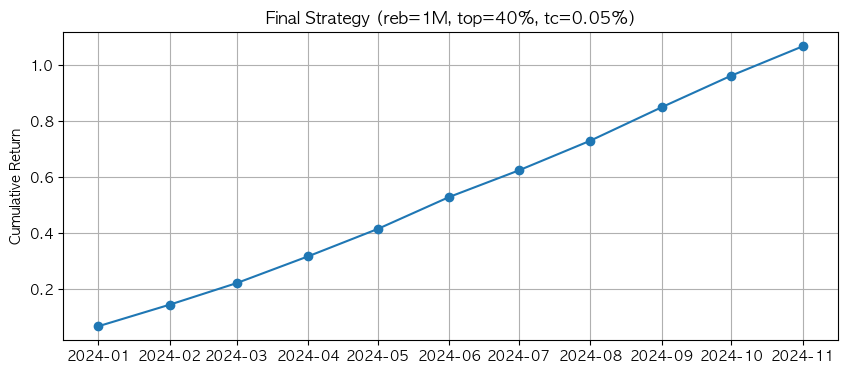

In [222]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import lightgbm as lgb

# ─────────────────────────────────────────────────
# (1) test_merged 준비: pred_3M_return, pred_1M_return, next_3M_return 컬럼 포함
# ─────────────────────────────────────────────────
# 이전에 만드신 test_merged DataFrame을 그대로 사용합니다.

# ─────────────────────────────────────────────────
# (2) Long-Short / Long-Only 시그널 함수
# ─────────────────────────────────────────────────
def gen_ls(df, pred_col, top_pct):
    df = df.sort_values(pred_col, ascending=False).reset_index(drop=True)
    n = len(df); k = int(n * top_pct)
    df['signal'] = 0
    if k>0:
        df.loc[:k-1, 'signal'] =  1
        df.loc[n-k:, 'signal'] = -1
    return df

# ─────────────────────────────────────────────────
# (3) 백테스트 함수 (비용 tc 반영)
# ─────────────────────────────────────────────────
def run_backtest(tc):
    records = []
    for reb_months in [1,2,3,6]:
        for top_pct in [0.1, 0.2, 0.3, 0.4, 0.5]:
            pnl_list = []
            prev_signals = None

            # 리밸 주기 단위로 월별 계산
            unique_months = sorted(test_merged['기준월'].unique())
            for i, mon in enumerate(unique_months):
                # 리밸 주기가 아니면 시그널·비용 유지
                if i % reb_months != 0:
                    # 비용·PnL 0 처리
                    pnl_list.append(0.0)
                    continue

                dfm = test_merged[test_merged['기준월']==mon].copy()
                # 1) 3M Long-Short
                dfm = gen_ls(dfm, 'pred_3M_return', top_pct).rename(columns={'signal':'sig3'})
                # 2) 1M Long-Short 필터
                dfm = gen_ls(dfm, 'pred_1M_return', top_pct).rename(columns={'signal':'sig1'})
                # 3) 최종 신호: 둘 다 non-zero인 경우만 유지
                dfm['signal_final'] = dfm['sig3'].where(dfm['sig1']!=0, 0)

                # 4) 턴오버 계산 (절대 신호 변화량의 합 ÷ 종목수)
                if prev_signals is None:
                    turnover = (dfm['signal_final'] != 0).sum() / len(dfm)
                else:
                    turnover = np.abs(dfm['signal_final'] - prev_signals).sum() / len(dfm)
                prev_signals = dfm['signal_final'].values

                # 5) PnL = 평균(signal_final × 실제 3M 수익) – 비용
                gross_pnl = (dfm['signal_final'] * dfm['next_3M_return']).mean()
                cost = turnover * tc  # 여기에 거래비용 반영
                net_pnl = gross_pnl - cost
                pnl_list.append(net_pnl)

            # 성과 지표 계산
            arr = np.array(pnl_list)
            cumret = np.prod(1 + arr) - 1
            sharpe = arr.mean() / (arr.std()+1e-9) * np.sqrt(12/reb_months)
            # max drawdown
            cum = np.cumprod(1+arr)
            dd = (cum / np.maximum.accumulate(cum) - 1).min()

            records.append({
                'rebalance_months': reb_months,
                'top_pct': top_pct,
                'tc': tc,
                'Sharpe': sharpe,
                'CumReturn': cumret,
                'MaxDrawdown': dd
            })

    return pd.DataFrame(records)

# ─────────────────────────────────────────────────
# (4) 그리드 실행
# ─────────────────────────────────────────────────
df_grid = run_backtest(tc=0.0005)  # 예: tc=0.05%
print(df_grid.pivot_table(
    index=['rebalance_months','top_pct'], 
    columns='tc', 
    values=['Sharpe','CumReturn','MaxDrawdown']
).round(4))

# ─────────────────────────────────────────────────
# (5) 최적 조합 시각화 (예: 리밸=1M, top_pct=0.2)
# ─────────────────────────────────────────────────
best = df_grid.sort_values('Sharpe', ascending=False).iloc[0]
print("Best params:", best[['rebalance_months','top_pct','tc']])

# 월별 전략 누적수익률 그리기
records = []
prev_signals = None
for i, mon in enumerate(sorted(test_merged['기준월'].unique())):
    if i % best.rebalance_months != 0:
        records.append({'기준월':mon,'pnl':0})
        continue
    dfm = test_merged[test_merged['기준월']==mon].copy()
    dfm = gen_ls(dfm, 'pred_3M_return', best.top_pct).rename(columns={'signal':'sig3'})
    dfm = gen_ls(dfm, 'pred_1M_return', best.top_pct).rename(columns={'signal':'sig1'})
    dfm['signal_final'] = dfm['sig3'].where(dfm['sig1']!=0, 0)

    turnover = ((dfm['signal_final'] != prev_signals) if prev_signals is not None 
                else (dfm['signal_final']!=0)).sum() / len(dfm)
    prev_signals = dfm['signal_final'].values

    gross_pnl = (dfm['signal_final'] * dfm['next_3M_return']).mean()
    net_pnl   = gross_pnl - turnover * best.tc
    records.append({'기준월':mon,'pnl':net_pnl})

perf = pd.DataFrame(records).set_index('기준월')
perf['cumret'] = (1+perf['pnl']).cumprod() -1

plt.figure(figsize=(10,4))
plt.plot(perf.index, perf['cumret'], marker='o')
plt.title(f"Final Strategy (reb={int(best.rebalance_months)}M, top={best.top_pct*100:.0f}%, tc={best.tc*100:.2f}%)")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.show()

In [237]:
def backtest_full(
    df,
    rebalance_months: int,
    top_pct: float,
    tc: float
):
    """
    df: test_merged DataFrame (기준월, pred_1M_return, pred_3M_return, next_1M_return, next_3M_return 등 포함)
    rebalance_months: 리밸 주기 (1,2,3,6)
    top_pct: 톱퍼센트 (0.1-0.5)
    tc: 거래비용 (예: 0.0005)
    """
    # 결과 누적 PnL 저장용
    rows = []

    # 각 리밸 시점마다
    months = sorted(df["기준월"].unique())[::rebalance_months]
    for mon in months:
        sub = df[df["기준월"] == mon].copy()

        # 1) 3M Long-Short 시그널
        sub = sub.sort_values("pred_3M_return", ascending=False).reset_index(drop=True)
        n = len(sub); k = int(n * top_pct)
        sub["sig3"] = 0
        if k>0:
            sub.loc[:k-1,"sig3"] =  1
            sub.loc[n-k:,"sig3"] = -1

        # 2) 1M Long-Short 필터
        sub = sub.sort_values("pred_1M_return", ascending=False).reset_index(drop=True)
        n2 = len(sub); k2 = int(n2 * top_pct)
        sub["sig1"] = 0
        if k2>0:
            sub.loc[:k2-1,"sig1"] =  1
            sub.loc[n2-k2:,"sig1"] = -1

        # 3) 필터 적용: sig1 != 0 인 종목만 sig3 유지, 나머지 0
        sub["signal_final"] = sub["sig3"].where(sub["sig1"] != 0, 0)

        # 4) 거래비용 반영: 진입·청산 발생 시 tc만큼 비용 차감
        #    (여기서는 간단히 |signal| × tc 로 월별 비용 처리)
        pnl = (sub["signal_final"] * sub["next_3M_return"]).mean() \
              - (abs(sub["signal_final"]) * tc).mean()

        rows.append((mon, pnl))

    perf = pd.DataFrame(rows, columns=["기준월","monthly_pnl"]).set_index("기준월")
    perf["cum_return"] = (1+perf["monthly_pnl"]).cumprod() - 1

    arr = perf["monthly_pnl"].to_numpy()
    mean = arr.mean(); std = arr.std()
    sharpe = 0.0 if std<1e-8 else mean/std * np.sqrt(12)
    cum    = perf["cum_return"].iloc[-1]
    dd     = (perf["cum_return"]+1).div(perf["cum_return"].cummax()) - 1
    maxdd  = dd.min()

    return perf, sharpe, cum, maxdd

=== Best Params (tc=0.0005) ===
rebalance_months     6.0000
top_pct              0.4000
tc                   0.0005
Sharpe              84.1839
CumReturn            0.1329
MaxDrawdown          7.5228
Name: 55, dtype: float64


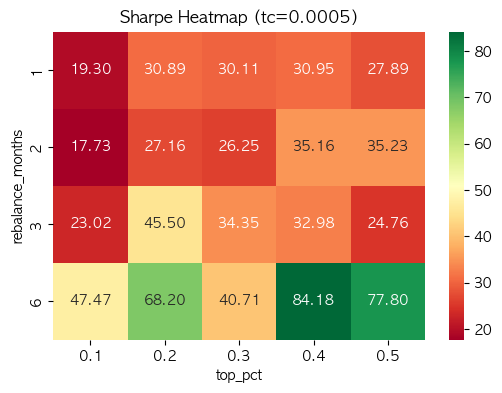

In [286]:
import itertools
import seaborn as sns
import matplotlib.pyplot as plt

# --- 1) Backtest 함수 (tc 포함) --------------------------
def backtest_full(df, rebalance_months, top_pct, tc):
    rows = []
    months = sorted(df["기준월"].unique())[::rebalance_months]
    for mon in months:
        sub = df[df["기준월"] == mon].copy()
        # 3M LS
        sub = sub.sort_values("pred_3M_return", ascending=False).reset_index(drop=True)
        n = len(sub); k = int(n * top_pct)
        sub["sig3"] = 0
        if k>0:
            sub.loc[:k-1,"sig3"] =  1
            sub.loc[n-k:,"sig3"] = -1
        # 1M LS filter
        sub = sub.sort_values("pred_1M_return", ascending=False).reset_index(drop=True)
        n2 = len(sub); k2 = int(n2 * top_pct)
        sub["sig1"] = 0
        if k2>0:
            sub.loc[:k2-1,"sig1"] =  1
            sub.loc[n2-k2:,"sig1"] = -1
        # final signal
        sub["signal_final"] = sub["sig3"].where(sub["sig1"] != 0, 0)
        # PnL with tc
        pnl = (sub["signal_final"] * sub["next_3M_return"]).mean() \
              - (sub["signal_final"].abs() * tc).mean()
        rows.append((mon, pnl))

    perf = pd.DataFrame(rows, columns=["기준월","monthly_pnl"]).set_index("기준월")
    perf["cum_return"] = (1+perf["monthly_pnl"]).cumprod() - 1

    arr = perf["monthly_pnl"].to_numpy()
    mean, std = arr.mean(), arr.std()
    sharpe = 0.0 if std<1e-8 else mean/std * np.sqrt(12)
    cum    = perf["cum_return"].iloc[-1]
    dd     = (perf["cum_return"]+1).div(perf["cum_return"].cummax()) - 1
    maxdd  = dd.min()
    return perf, sharpe, cum, maxdd

# --- 2) 그리드 서치 -------------------------------------
rebalance_months_list = [1,2,3,6]
top_pct_list          = [0.1,0.2,0.3,0.4,0.5]
tc_list               = [0.0,0.0005,0.001]

results = []
for rebalance_months, top_pct, tc in itertools.product(
    rebalance_months_list,
    top_pct_list,
    tc_list
):
    _, sharpe, cumret, maxdd = backtest_full(
        df=test_merged,
        rebalance_months=rebalance_months,
        top_pct=top_pct,
        tc=tc
    )
    results.append({
        "rebalance_months": rebalance_months,
        "top_pct":          top_pct,
        "tc":               tc,
        "Sharpe":           sharpe,
        "CumReturn":        cumret,
        "MaxDrawdown":      maxdd
    })

df_grid = pd.DataFrame(results)

# --- 3) 실전 tc=0.0005 고정 최적화 ----------------------
df_tc = df_grid[df_grid["tc"] == 0.0005]
best  = df_tc.loc[df_tc["Sharpe"].idxmax()]
print("=== Best Params (tc=0.0005) ===")
print(best)

# --- 4) 히트맵 시각화 -------------------------------
pivot = (
    df_tc
      .pivot(index="rebalance_months",
             columns="top_pct",
             values="Sharpe")
)
plt.figure(figsize=(6,4))
sns.heatmap(pivot, annot=True, fmt=".2f", cmap="RdYlGn")
plt.title("Sharpe Heatmap (tc=0.0005)")
plt.show()

1M_log 추가

=== Rolling‐Window Backtest Summary ===
               RMSE      MAE       R2  Rank_IC  Hit_Ratio  Sharpe(3M_LS)
test_month                                                              
2024-09-01   0.1191   0.0788   0.5652   0.7365     0.8627         1.8919
2024-10-01   0.0980   0.0648   0.6397   0.7940     0.8725         2.1039
2024-11-01   0.1072   0.0709   0.6780   0.8335     0.8666         2.1847

▶ 누적수익률    : 0.3192
▶ 연환산샤프비  : 2.0602
▶ 최대 낙폭    : 0.0000


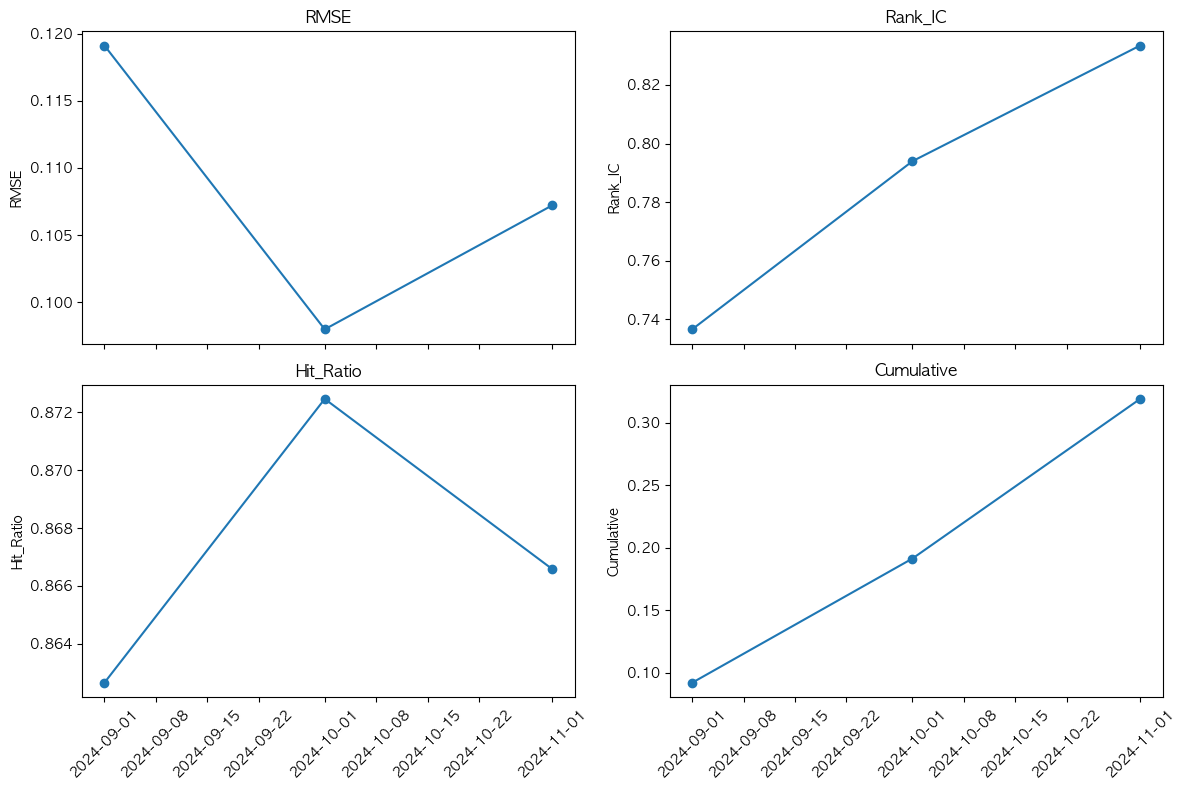

In [318]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from scipy.stats import spearmanr

# ─────────────────────────────────────────────────
# 0. 준비: test_merged 로드 (이미 메모리상에 있다고 가정)
# test_merged = pd.read_csv("test_merged.csv", parse_dates=["기준월"])
# 반드시 test_merged 에는 아래 컬럼들이 있어야 합니다:
#   ['기준월','회사명','value_score','quality_score','momentum_score',
#    'size_score','lowvol_score','1M_log','next_3M_return']
# ─────────────────────────────────────────────────

# ─────────────────────────────────────────────────
# 파라미터
# ─────────────────────────────────────────────────
train_window     = 8    # 학습 윈도우 개월 수
stride           = 1    # 윈도우 이동 폭
top_pct          = 0.4  # 톱티어 비율
rebalance_months = 3    # 전략 리밸 주기(월 단위)

# ─────────────────────────────────────────────────
# 기록용 리스트 초기화
# ─────────────────────────────────────────────────
records = []

months = sorted(test_merged["기준월"].unique())
n_months = len(months)

# ─────────────────────────────────────────────────
# 1. Rolling 재학습 + 지표 계산
# ─────────────────────────────────────────────────
for start in range(0, n_months - train_window - stride + 1, stride):
    # 1-1) train/test 기간 분리
    train_months = months[start : start + train_window]
    test_months  = months[start + train_window : start + train_window + stride]
    test_month   = test_months[-1]
    
    df_train = test_merged[test_merged["기준월"].isin(train_months)]
    df_test  = test_merged[test_merged["기준월"] == test_month].copy()
    
    # 1-2) 3M 모델 재학습 (1M_log 포함)
    features = ["value_score","quality_score","momentum_score","size_score","lowvol_score","1M_log"]
    m3 = lgb.LGBMRegressor(
        objective="regression", metric="rmse",
        learning_rate=0.05, num_leaves=31,
        min_data_in_leaf=20, feature_fraction=0.8,
        bagging_fraction=0.8, bagging_freq=1,
        n_estimators=200, random_state=42, n_jobs=-1, verbose=-1
    )
    m3.fit(df_train[features], df_train["3M_log"])
    pred_log = m3.predict(df_test[features])
    df_test["pred_3M_return"] = np.expm1(pred_log)
    
    # 1-3) 회귀 성능
    y_true = df_test["next_3M_return"].values
    y_pred = df_test["pred_3M_return"].values
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mae  = mean_absolute_error(y_true, y_pred)
    r2   = r2_score(y_true, y_pred)
    
    # 1-4) 순위 성능
    # Rank-IC
    rank_ic, _ = spearmanr(df_test["pred_3M_return"], df_test["next_3M_return"])
    # Hit ratio: 예측 부호 = 실제 부호 비율
    hit = np.mean(np.sign(df_test["pred_3M_return"]) == np.sign(df_test["next_3M_return"]))
    
    # 1-5) 전략 PnL (Long-Short, rebalance_months 주기 고려 안 하고 매월 재정렬)
    tmp = df_test.sort_values("pred_3M_return", ascending=False).reset_index(drop=True)
    n, k = len(tmp), int(np.floor(n * top_pct))
    tmp["signal"] = 0
    if k > 0:
        tmp.loc[:k-1, "signal"]   =  1
        tmp.loc[n-k:, "signal"]    = -1
    pnl_srs = tmp["signal"] * tmp["next_3M_return"]
    mean_pnl = pnl_srs.mean()
    std_pnl  = pnl_srs.std() + 1e-9
    sharpe   = mean_pnl / std_pnl * np.sqrt(12)
    
    # 기록
    records.append({
        "train_end":  train_months[-1],
        "test_month": test_month,
        "RMSE":        rmse,
        "MAE":         mae,
        "R2":          r2,
        "Rank_IC":     rank_ic,
        "Hit_Ratio":   hit,
        "Sharpe(3M_LS)": sharpe,
        "Monthly_PnL": mean_pnl
    })

# ─────────────────────────────────────────────────
# 2. DataFrame 으로 정리
# ─────────────────────────────────────────────────
df_res = pd.DataFrame(records)

# 2-1) 누적수익 / MaxDD 계산
df_res.set_index("test_month", inplace=True)
df_res["Cumulative"] = (1 + df_res["Monthly_PnL"]).cumprod() - 1
dd = df_res["Cumulative"] + 1
dd = dd / dd.cummax() - 1
maxdd = dd.min()

# ─────────────────────────────────────────────────
# 3. 최종 요약 출력
# ─────────────────────────────────────────────────
print("=== Rolling‐Window Backtest Summary ===")
print(df_res[[
    "RMSE","MAE","R2","Rank_IC","Hit_Ratio","Sharpe(3M_LS)"
]])
print(f"\n▶ 누적수익률    : {df_res['Cumulative'].iloc[-1]:.4f}")
print(f"▶ 연환산샤프비  : {df_res['Sharpe(3M_LS)'].mean():.4f}")
print(f"▶ 최대 낙폭    : {maxdd:.4f}")

# ─────────────────────────────────────────────────
# 4. 시각화
# ─────────────────────────────────────────────────
fig, axes = plt.subplots(2,2, figsize=(12,8), sharex=True)
axes = axes.flatten()

for ax, col in zip(axes, ["RMSE","Rank_IC","Hit_Ratio","Cumulative"]):
    if col == "Cumulative":
        ax.plot(df_res.index, df_res[col], marker='o')
        ax.set_ylabel("Cumulative")
    else:
        ax.plot(df_res.index, df_res[col], marker='o')
        ax.set_ylabel(col)
    ax.tick_params(axis='x', rotation=45)
    ax.set_title(col)

plt.tight_layout()
plt.show()

=== Final 성과 ===
누적수익률: 0.5640
연환산 샤프비: 9.6278
최대 낙폭  : 0.0000


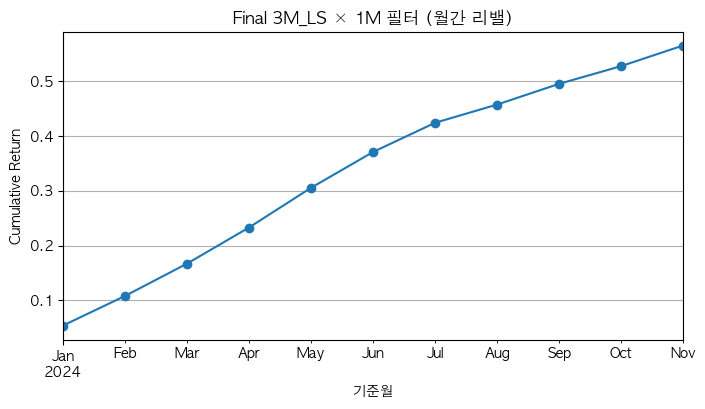

In [330]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt

# 0. 파일 경로 (환경에 맞게 수정)
factor_train_path = "/Users/gun/Desktop/경종설/국내/train_stock_0.3_ind_neutral.csv"
factor_test_path  = "/Users/gun/Desktop/경종설/국내/test_stock_0.3_ind_neutral.csv"
orig_train_path   = "/Users/gun/Desktop/경종설/국내/train_stock_0.3.csv"
orig_test_path    = "/Users/gun/Desktop/경종설/국내/test_stock_0.3.csv"

# 1. 데이터 로드
df_factor_train = pd.read_csv(factor_train_path, parse_dates=["기준월"])
df_factor_test  = pd.read_csv(factor_test_path,  parse_dates=["기준월"])
df_orig_train   = pd.read_csv(orig_train_path,   parse_dates=["기준월"])
df_orig_test    = pd.read_csv(orig_test_path,    parse_dates=["기준월"])

# 2. next returns 생성
def add_next_returns(df):
    df = df.sort_values(["회사명","기준월"]).reset_index(drop=True)
    df["next_1M_return"] = df.groupby("회사명")["1개월수익률"].shift(-1)
    df["next_3M_return"] = df.groupby("회사명")["3개월수익률"].shift(-1)
    return df

df_orig_train = add_next_returns(df_orig_train)
df_orig_test  = add_next_returns(df_orig_test)

# 3. 팩터+타깃+산업군 병합
train = pd.merge(
    df_factor_train,
    df_orig_train[["기준월","회사명","next_1M_return","next_3M_return","산업군"]],
    on=["기준월","회사명"], how="inner"
).dropna(subset=["next_1M_return","next_3M_return"])
test  = pd.merge(
    df_factor_test,
    df_orig_test[["기준월","회사명","next_1M_return","next_3M_return","산업군"]],
    on=["기준월","회사명"], how="inner"
).dropna(subset=["next_1M_return","next_3M_return"])

# 4. 로그 변환 + 윈저라이즈 (0.5%–99.5% 절단)
for df in (train, test):
    for h in ("1M","3M"):
        col = f"next_{h}_return"
        log = f"log{h}"
        df[log] = np.log1p(df[col])
        low, high = df[log].quantile(0.005), df[log].quantile(0.995)
        df[log] = df[log].clip(low, high)

# 5. 산업군 더미 생성 (prefix_sep='' 로 언더스코어 제거)
for df in (train, test):
    dummies = pd.get_dummies(df["산업군_x"], prefix="sect", prefix_sep="")
    df[dummies.columns] = dummies

# 6. 모델 학습 & 예측 준비
feature_cols = [
    "value_score", "quality_score", "momentum_score",
    "size_score",  "lowvol_score", "log1M"
] + [c for c in train.columns if c.startswith("sect")]

model = lgb.LGBMRegressor(
    objective="regression", metric="rmse",
    learning_rate=0.05, num_leaves=31, min_data_in_leaf=20,
    feature_fraction=0.8, bagging_fraction=0.8, bagging_freq=1,
    n_estimators=200, random_state=42, n_jobs=-1, verbose=-1
)

# 학습
model.fit(
    train[feature_cols].values, 
    train["log3M"].values
)

# 예측
test["pred_log3M"]    = model.predict(test[feature_cols].values)
test["pred_3M_return"] = np.expm1(test["pred_log3M"])

# 7. 전략: 3M 롱숏 + 1M 필터, 월간 리밸
def gen_ls(df, pred, top=0.3):
    df = df.sort_values(pred, ascending=False).reset_index(drop=True)
    n, k = len(df), int(len(df) * top)
    df["signal_ls"] = 0
    if k>0:
        df.loc[:k-1,  "signal_ls"] =  1
        df.loc[n-k:, "signal_ls"] = -1
    return df

def gen_filter(df, pred, top=0.3):
    df = df.sort_values(pred, ascending=False).reset_index(drop=True)
    k = int(len(df) * top)
    df["filter_ls"] = 0
    if k>0:
        df.loc[:k-1, "filter_ls"] = 1
    return df

pnl_list = []
for mon, grp in test.groupby("기준월", as_index=False):
    tmp = gen_ls(grp.copy(),     "pred_3M_return", top=0.3)
    tmp = gen_filter(tmp,       "next_1M_return", top=0.3)
    # 1M 필터=1 인 것만 signal 유지
    tmp["signal_final"] = tmp["signal_ls"].where(tmp["filter_ls"]==1, 0)
    pnl = (tmp["signal_final"] * tmp["next_3M_return"]).mean()
    pnl_list.append((mon, pnl))

perf = pd.DataFrame(pnl_list, columns=["기준월","pnl"]).set_index("기준월")
perf["cum_return"] = (1 + perf["pnl"]).cumprod() - 1

# 8. 결과 요약
mean_pnl = perf["pnl"].mean()
std_pnl  = perf["pnl"].std()
sharpe   = mean_pnl / (std_pnl + 1e-9) * np.sqrt(12)
maxdd    = (perf["cum_return"] + 1).div((perf["cum_return"] + 1).cummax()) - 1
print("=== Final 성과 ===")
print(f"누적수익률: {perf['cum_return'].iloc[-1]:.4f}")
print(f"연환산 샤프비: {sharpe:.4f}")
print(f"최대 낙폭  : {maxdd.min():.4f}")

# 9. 누적수익률 플롯
plt.figure(figsize=(8,4))
perf["cum_return"].plot(marker="o")
plt.title("Final 3M_LS × 1M 필터 (월간 리밸)")
plt.ylabel("Cumulative Return")
plt.grid(True)
plt.show()

In [ ]:
import pandas as pd
import numpy as np
from sklearn.model_selection import ParameterGrid, TimeSeriesSplit
from sklearn.metrics import r2_score
import lightgbm as lgb

# 0) test_merged 준비
# test_merged에는 ['기준월','회사명','value_score',…,'1M_log','3M_log','pred_3M_return','next_3M_return'] 가 있어야 합니다.

features = ["value_score","quality_score","momentum_score","size_score","lowvol_score","1M_log"]
X = test_merged[features]
y = test_merged["3M_log"]

# 1) 그리드 설정: num_leaves, max_depth, lambda_l1, lambda_l2
param_grid = {
    "num_leaves":   [15, 31],
    "max_depth":    [3, 5, -1],
    "lambda_l1":    [0.0, 0.1],
    "lambda_l2":    [0.0, 0.1],
    "learning_rate":[0.05],
    "n_estimators": [100]
}

# 2) TimeSeriesSplit
tscv = TimeSeriesSplit(n_splits=5)

records = []
for params in ParameterGrid(param_grid):
    fold_idx = 0
    for train_idx, val_idx in tscv.split(X):
        fold_idx += 1
        X_train, X_val = X.iloc[train_idx], X.iloc[val_idx]
        y_train, y_val = y.iloc[train_idx], y.iloc[val_idx]

        # 모델 학습
        model = lgb.LGBMRegressor(**params, random_state=42, n_jobs=-1)
        model.fit(X_train, y_train)

        # 예측 (로그 스케일)
        y_pred_log = model.predict(X_val)
        # 실수익 스케일로 변환
        y_true_ret = np.expm1(test_merged.iloc[val_idx]["next_3M_return"].values)
        y_pred_ret = np.expm1(y_pred_log)

        # 지표 계산
        r2       = r2_score(np.expm1(y_val), y_pred_ret)
        # Rank_IC
        rank_ic  = np.corrcoef(
            pd.Series(np.expm1(y_val)).rank(), 
            pd.Series(y_pred_ret).rank()
        )[0,1]
        # Hit ratio
        hit_ratio = (np.sign(y_pred_ret) == np.sign(np.expm1(y_val))).mean()
        # Sharpe (3M_LS)
        tmp = pd.DataFrame({
            "pred": y_pred_ret,
            "real": np.expm1(y_val)
        }).sort_values("pred", ascending=False)
        n = len(tmp); k=int(n*0.3)
        tmp["signal"] = 0
        if k>0:
            tmp.iloc[:k, tmp.columns.get_loc("signal")] = 1
            tmp.iloc[-k:, tmp.columns.get_loc("signal")] = -1
        pnl = (tmp["signal"] * tmp["real"])
        sharpe = pnl.mean() / (pnl.std()+1e-9) * np.sqrt(12)

        records.append({
            **params,
            "fold": fold_idx,
            "R2":        r2,
            "Rank_IC":  rank_ic,
            "Hit_Ratio":hit_ratio,
            "Sharpe":   sharpe
        })

# 3) 결과 DataFrame
df_cv = pd.DataFrame(records)

# 4) 요약
print("=== TimeSeriesSplit CV Results ===")
print(df_cv.groupby(list(param_grid.keys()))[["R2","Rank_IC","Hit_Ratio","Sharpe"]]
      .mean()  # fold 평균
      .sort_values("Sharpe", ascending=False)
      .head(10))

=== TimeSeriesSplit CV Results ===
                                                                          R2  Rank_IC  Hit_Ratio   Sharpe
num_leaves max_depth lambda_l1 lambda_l2 learning_rate n_estimators                                      
15          5        0.1000    0.1000    0.0500        100            0.6765   0.7870     0.8258   2.1103
                     0.0000    0.0000    0.0500        100            0.6769   0.7872     0.8242   2.1070
           -1        0.1000    0.1000    0.0500        100            0.6771   0.7866     0.8258   2.1056
                     0.0000    0.0000    0.0500        100            0.6781   0.7864     0.8253   2.1052
31          3        0.0000    0.1000    0.0500        100            0.6687   0.7853     0.8231   2.1050
15          3        0.0000    0.1000    0.0500        100            0.6687   0.7853     0.8231   2.1050
            5        0.0000    0.1000    0.0500        100            0.6779   0.7874     0.8253   2.1049
31         

In [332]:
import pandas as pd
import numpy as np
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV
from sklearn.metrics import make_scorer, r2_score
import lightgbm as lgb

# 0) 데이터 준비
features = ["value_score","quality_score","momentum_score","size_score","lowvol_score","1M_log"]
X = test_merged[features]
y = test_merged["3M_log"]

# 1) 실수익 기반 R² 스코어 정의
def real_r2(y_true_log, y_pred_log):
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)
    return r2_score(y_true, y_pred)
r2_scorer = make_scorer(real_r2, greater_is_better=True)

# 2) 하이퍼파라미터 그리드
param_grid = {
    "num_leaves":   [15, 31],
    "max_depth":    [3, 5, -1],
    "lambda_l1":    [0.0, 0.1],
    "lambda_l2":    [0.0, 0.1],
    "learning_rate":[0.05],
    "n_estimators": [100]
}

# 3) Nested CV 세팅
outer_cv = TimeSeriesSplit(n_splits=5)   # 외부 5겹
inner_cv = TimeSeriesSplit(n_splits=3)   # 내부 3겹

results = []
for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X), 1):
    X_tr, X_te = X.iloc[train_idx], X.iloc[test_idx]
    y_tr, y_te = y.iloc[train_idx], y.iloc[test_idx]

    # 내부 그리드서치
    base = lgb.LGBMRegressor(objective="regression", metric="rmse",
                             random_state=42, n_jobs=-1)
    grid = GridSearchCV(
        estimator=base,
        param_grid=param_grid,
        cv=inner_cv,
        scoring=r2_scorer,
        refit=True,
        verbose=0
    )
    grid.fit(X_tr, y_tr)

    # 테스트 구간에서 평가
    best = grid.best_estimator_
    y_pred_log = best.predict(X_te)
    y_true = np.expm1(y_te)
    y_pred = np.expm1(y_pred_log)
    r2_val = r2_score(y_true, y_pred)

    results.append({
        "fold": fold,
        "best_params": grid.best_params_,
        "R2_real": r2_val
    })

# 4) 요약
df_res = pd.DataFrame(results)
print("=== Nested CV Results ===")
print(df_res)
print("\nAverage real-scale R²:", df_res["R2_real"].mean().round(4))

=== Nested CV Results ===
   fold                                        best_params  R2_real
0     1  {'lambda_l1': 0.1, 'lambda_l2': 0.0, 'learning...   0.6656
1     2  {'lambda_l1': 0.0, 'lambda_l2': 0.0, 'learning...   0.6870
2     3  {'lambda_l1': 0.1, 'lambda_l2': 0.1, 'learning...   0.6559
3     4  {'lambda_l1': 0.1, 'lambda_l2': 0.0, 'learning...   0.6746
4     5  {'lambda_l1': 0.1, 'lambda_l2': 0.1, 'learning...   0.6934

Average real-scale R²: 0.6753


In [6]:
import pandas as pd
import numpy as np
import lightgbm as lgb
import scipy.stats as st
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, make_scorer
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

# 0) 데이터 로드
test_merged = pd.read_csv(
    "/Users/gun/Desktop/경종설/국내/ML_quant/test_merged.csv",
    parse_dates=["기준월"]
)

# 0-1) 1M_log, 3M_log 생성
# next_1M_return, next_3M_return 컬럼명이 실제와 다르면 수정할 것
if "1M_log" not in test_merged.columns:
    test_merged["1M_log"] = np.log1p(test_merged["next_1M_return"])
if "3M_log" not in test_merged.columns:
    test_merged["3M_log"] = np.log1p(test_merged["next_3M_return"])

# 1) 전략 파라미터
top_pct          = 0.4    # 상/하위 40%를 long/short
rebalance_months = 6      # 리밸런싱 주기(개월)
tc               = 0.0005 # 거래비용 비율

FEATURES = [
    "value_score", "quality_score", "momentum_score",
    "size_score", "lowvol_score", "1M_log"
]

train_window = 12        # 초기 학습 창 크기 (개월)
test_window  = rebalance_months
stride       = 1         # 한 달씩 롤링

# 2) 로그→실수익 변환 후 R² 스코어
def real_r2(y_true_log, y_pred_log):
    y_true = np.expm1(y_true_log)
    y_pred = np.expm1(y_pred_log)
    return r2_score(y_true, y_pred)

r2_scorer = make_scorer(real_r2, greater_is_better=True)

# 3) 하이퍼파라미터 그리드
param_grid = {
    "num_leaves":    [15, 31],
    "max_depth":     [3, 5, -1],
    "lambda_l1":     [0.0, 0.1],
    "reg_lambda":     [0.0, 0.1],
    "learning_rate": [0.05],
    "n_estimators":  [100]
}

# 4) 기준월 리스트 생성 및 train_window 자동 조정
months       = sorted(test_merged["기준월"].unique())
total_months = len(months)
if total_months <= test_window:
    raise RuntimeError(
        f"데이터 기간이 너무 짧습니다: "
        f"최소 test_window+1개월 필요, 현재 {total_months}개월"
    )
max_tw = total_months - test_window
if train_window > max_tw:
    train_window = max_tw

# 5) 롤링 백테스트 + Nested CV
records = []
for start in range(0, total_months - train_window - test_window + 1, stride):
    train_m = months[start : start + train_window]
    test_m  = months[start + train_window : start + train_window + test_window]
    df_tr   = test_merged[test_merged["기준월"].isin(train_m)]
    df_te   = test_merged[test_merged["기준월"].isin(test_m)]

    inner_cv = TimeSeriesSplit(n_splits=3)
    base = lgb.LGBMRegressor(
        objective="regression", metric="rmse",
        random_state=42, n_jobs=-1
    )
    grid = GridSearchCV(
        estimator=base,
        param_grid=param_grid,
        cv=inner_cv,
        scoring=r2_scorer,
        n_jobs=-1,
        refit=True
    )
    grid.fit(df_tr[FEATURES], df_tr["3M_log"])
    best_model = grid.best_estimator_

    y_true     = df_te["next_3M_return"].values
    y_pred_log = best_model.predict(df_te[FEATURES])
    y_pred     = np.expm1(y_pred_log)

    rmse      = np.sqrt(mean_squared_error(y_true, y_pred))
    mae       = mean_absolute_error(y_true, y_pred)
    r2        = r2_score(y_true, y_pred)
    rank_ic   = st.pearsonr(df_te["3M_log"], y_pred_log)[0]
    hit_ratio = np.mean(np.sign(y_pred_log) == np.sign(df_te["3M_log"]))

    tmp = df_te.copy()
    tmp["pred"]   = y_pred
    tmp = tmp.sort_values("pred", ascending=False).reset_index(drop=True)
    n = len(tmp)
    k = int(n * top_pct)
    tmp["signal"] = 0
    if k > 0:
        tmp.loc[:k-1, "signal"] =  1
        tmp.loc[n-k:, "signal"] = -1
    turnover = 2 * k / n
    pnl      = tmp["signal"] * tmp["next_3M_return"] - turnover * tc
    sharpe   = pnl.mean() / (pnl.std() + 1e-9) * np.sqrt(12)

    records.append({
        "train_end"   : train_m[-1],
        "test_end"    : test_m[-1],
        "best_params" : grid.best_params_,
        "RMSE"        : rmse,
        "MAE"         : mae,
        "R2"          : r2,
        "Rank_IC"     : rank_ic,
        "Hit_Ratio"   : hit_ratio,
        "Sharpe"      : sharpe
    })

# 6) 결과 DataFrame 생성 및 출력
df_results = pd.DataFrame(records)
print(df_results)

# 7) 요약 통계
print("\n=== Summary ===")
print("평균 RMSE     :", df_results["RMSE"].mean())
print("평균 MAE      :", df_results["MAE"].mean())
print("평균 R²       :", df_results["R2"].mean())
print("평균 Rank_IC :", df_results["Rank_IC"].mean())
print("평균 Hit_Ratio:", df_results["Hit_Ratio"].mean())
print("평균 Sharpe  :", df_results["Sharpe"].mean())
# 전통 팩터 수익률 계산 함수
def evaluate_traditional_factor(test_merged, factor_name, top_pct=0.4, rebalance_months=6):
    months = sorted(test_merged["기준월"].unique())
    factor_returns = []

    for i in range(0, len(months) - rebalance_months):
        period_months = months[i : i + rebalance_months]
        df_period = test_merged[test_merged["기준월"].isin(period_months)]

        if df_period.empty:
            continue

        df_ranked = df_period.copy()
        df_ranked["rank"] = df_ranked.groupby("기준월")[factor_name].rank(method="first", ascending=False)
        df_ranked["percentile"] = df_ranked.groupby("기준월")["rank"].transform(lambda x: x / x.max())
        df_selected = df_ranked[df_ranked["percentile"] <= top_pct]
        avg_return = df_selected.groupby("기준월")["next_3M_return"].mean()
        factor_returns.append(avg_return)

    if not factor_returns:
        return pd.Series(dtype=float)
    return pd.concat(factor_returns).sort_index()

# 머신러닝 예측 결과
ml_returns = df_results.set_index("test_end")["Sharpe"]

# 비교할 전통 팩터 목록
factors_to_compare = ["momentum_score", "value_score", "quality_score"]
factor_comparison = {}
for fac in factors_to_compare:
    fac_ret = evaluate_traditional_factor(test_merged, fac)
    factor_comparison[fac] = fac_ret

# 비교 결과 출력
comparison_df = pd.DataFrame(factor_comparison)
print("\n✅ 전통 팩터 수익률 비교 (기준월별):")
print(comparison_df)

# 샤프 지수 계산 함수
def compute_sharpe(series):
    if series.std() == 0:
        return 0
    return series.mean() / series.std() * np.sqrt(12)

# 평균 Sharpe 지수 비교
print("\n✅ 평균 Sharpe 지수 비교:")
for fac in comparison_df.columns:
    sharpe = compute_sharpe(comparison_df[fac].dropna())
    print(f"  {fac:<15}: {sharpe:.3f}")

print(f"\n✅ 머신러닝 모델 평균 Sharpe: {ml_returns.mean():.3f}")

[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Warning] lambda_l1 is set=0.0, reg_alpha=0.0 will be ignored. Current value: lambda_l1=0.0
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000083 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1530
[LightGBM] [Info] Number of data points in the train set: 1912, number of used features: 6
[LightGBM] [Info] Start training from score 0.017913
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

▶ 2024년 데이터 건수: 18348
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000338 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7145
[LightGBM] [Info] Number of data points in the train set: 18348, number of used features: 29
[LightGBM] [Info] Start training from score -0.011608

=== 캡처 변수 중요도 (2024년) ===
                 feature  importance
0       return_vol_ratio         692
1                 3개월변동성         681
2         momentum_accel         349
3                 1개월수익률         295
4                 6개월수익률         124
5                12개월수익률         117
6          momentum_diff         108
7                   시가총액          51
8                    PBR          51
9                    PSR          49
10  momentum_trend_slope          49
11     monthly_return_cv          36
12         roe_per_ratio          33
13                 거래회전율  

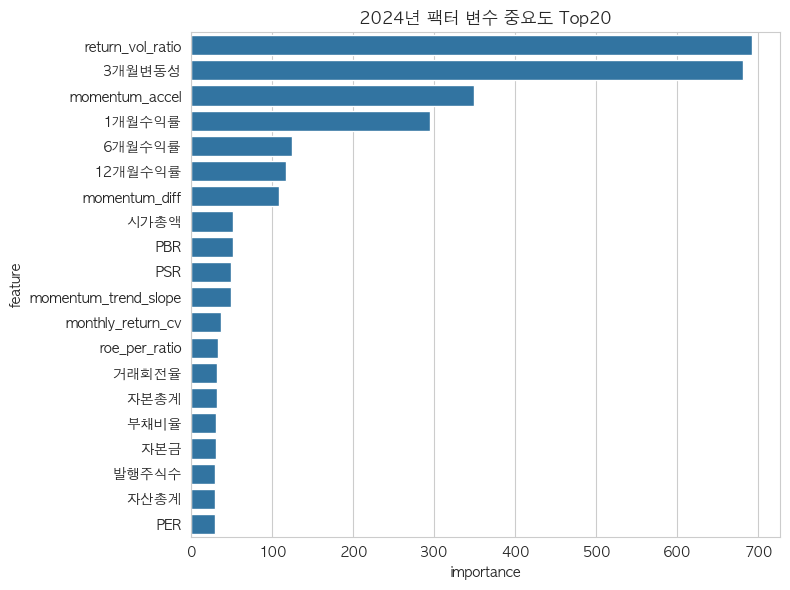

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.000472 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 7655
[LightGBM] [Info] Number of data points in the train set: 18348, number of used features: 31
[LightGBM] [Info] Start training from score -0.011608

=== 전체 변수 중요도 (2024년) ===
                 feature  importance
0       return_vol_ratio         668
1                 3개월변동성         667
2         momentum_accel         316
3                 1개월수익률         300
4                 6개월수익률         135
5                12개월수익률         115
6          momentum_diff          85
7      volatility_spread          48
8                  거래회전율          47
9      monthly_return_cv          44
10                   PSR          41
11                   PBR          40
12  momentum_trend_slope          40
13         roe_per_ratio          40
14         

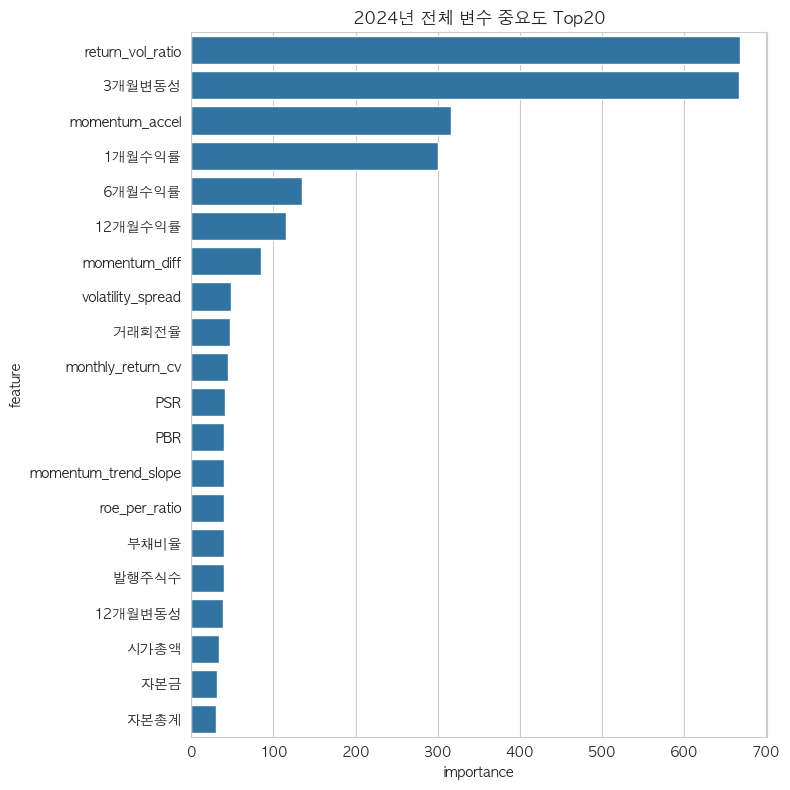

In [4]:
# ------------------------------
# 라이브러리 임포트
# ------------------------------
import pandas as pd
import numpy as np
import lightgbm as lgb
import matplotlib.pyplot as plt
import seaborn as sns
import FinanceDataReader as fdr

# ------------------------------
# 한글 폰트 설정 (macOS 예시)
# ------------------------------
try:
    plt.rc('font', family='AppleGothic')
except Exception as e:
    print(f"폰트 설정 오류: {e}. 기본 폰트로 설정됩니다.")
plt.rcParams['axes.unicode_minus'] = False

# ------------------------------
# 1) 데이터 로드 및 2024년 필터링
# ------------------------------
path = "/Users/gun/Desktop/경종설/퀀트/stock_0.3ver.csv"
df = pd.read_csv(path, parse_dates=['기준월'])
df2024 = df[df['기준월'].dt.year == 2024].copy()
print(f"▶ 2024년 데이터 건수: {len(df2024)}")

# ------------------------------
# 2) 캡처 파일 변수 리스트로 중요도 분석
# ------------------------------
capture_features = [
    # Value
    "PER", "PBR", "PSR", "roe_per_ratio",
    # Quality
    "ROE", "영업이익률", "EPS", "부채비율", "당기순이익", "영업이익", "자본총계",
    # Momentum
    "1개월수익률", "6개월수익률", "12개월수익률",
    "momentum_diff", "momentum_accel", "momentum_trend_slope",
    "trend_positive_count", "평균거래량증가율",
    # Size
    "시가총액", "발행주식수", "자산총계", "자본금", "매출액", "부채총계",
    # Low Volatility
    "3개월변동성", "monthly_return_cv", "return_vol_ratio", "거래회전율"
]

TARGET = "3개월수익률"

# 결측치 있는 행 제거
sub = df2024[capture_features + [TARGET]].dropna()
X_cap = sub[capture_features]
y_cap = sub[TARGET]

# LightGBM 회귀 모델 훈련
model_cap = lgb.LGBMRegressor(
    objective='regression', random_state=42, n_estimators=100
)
model_cap.fit(X_cap, y_cap)

# 중요도 DataFrame 작성
imp_cap = pd.DataFrame({
    'feature': capture_features,
    'importance': model_cap.feature_importances_
}).sort_values('importance', ascending=False).reset_index(drop=True)

print("\n=== 캡처 변수 중요도 (2024년) ===")
print(imp_cap)

# (선택) 시각화
plt.figure(figsize=(8,6))
sns.barplot(data=imp_cap.head(20), x='importance', y='feature')
plt.title("2024년 팩터 변수 중요도 Top20")
plt.tight_layout()
plt.show()


# ------------------------------
# 3) 모든 수치형 컬럼 변수 중요도 분석
# ------------------------------
# 식별자/텍스트 컬럼 제외
drop_cols = ['기준월', '회사명', '종목코드', '산업군']
all_features = [
    c for c in df2024.columns
    if c not in drop_cols + [TARGET]
    and pd.api.types.is_numeric_dtype(df2024[c])
]

sub2 = df2024[all_features + [TARGET]].dropna()
X_all = sub2[all_features]
y_all = sub2[TARGET]

model_all = lgb.LGBMRegressor(
    objective='regression', random_state=42, n_estimators=100
)
model_all.fit(X_all, y_all)

imp_all = pd.DataFrame({
    'feature': all_features,
    'importance': model_all.feature_importances_
}).sort_values('importance', ascending=False).reset_index(drop=True)

print("\n=== 전체 변수 중요도 (2024년) ===")
print(imp_all)

plt.figure(figsize=(8,8))
sns.barplot(data=imp_all.head(20), x='importance', y='feature')
plt.title("2024년 전체 변수 중요도 Top20")
plt.tight_layout()
plt.show()

In [5]:
import pandas as pd

# ✅ 파일 경로 (Colab 기준, 파일 업로드 후 아래 경로 설정)
file_path = "/Users/gun/Desktop/경종설/퀀트/stock_0.3ver.csv"

# ✅ CSV 파일 읽기
df = pd.read_csv(file_path)

# ✅ 종목코드 컬럼이름 확인 (보통 '종목코드', 'code', 'ticker' 등 다양)
print(df.columns)
# 예: 컬럼명이 '종목코드'일 경우
code_list = df["종목코드"].dropna().unique().tolist()

# 종목코드를 6자리 문자열로 변환 (예: 5930 → 005930)
code_list = [str(code).zfill(6) for code in code_list]

# 확인
print(code_list[:10])  # 앞 10개 미리 보기
print(f"총 종목 수: {len(code_list)}")

# 저장 (csv)
pd.DataFrame(code_list, columns=["종목코드"]).to_csv("종목코드_리스트.csv", index=False)


Index(['기준월', '회사명', '자산총계', '자본총계', '부채총계', '자본금', '매출액', '영업이익', '당기순이익',
       '종목코드', '산업군', '1개월수익률', '3개월수익률', '6개월수익률', '12개월수익률', '3개월변동성',
       '12개월변동성', '평균거래량증가율', '거래회전율', '시가총액', '발행주식수', 'PER', 'PBR', 'PSR',
       'ROE', '영업이익률', 'EPS', '부채비율', 'momentum_diff', 'momentum_accel',
       'trend_positive_count', 'return_vol_ratio', 'volatility_spread',
       'roe_per_ratio', 'momentum_trend_slope', 'monthly_return_cv'],
      dtype='object')
['095570', '054620', '265520', '211270', '282330', '126600', '001460', '083790', '035760', '311690']
총 종목 수: 1529


In [6]:
from datetime import datetime
import pandas as pd

# 수집 기간 설정
start = datetime(2021, 1, 1)
end = datetime(2025, 3, 31)

# 월 단위 날짜 리스트 생성
date_range = pd.date_range(start=start, end=end, freq='MS').strftime('%Y%m').tolist()
# 종목코드 리스트 불러오기 (파일에 따라 경로 조정)
df = pd.read_csv("/Users/gun/Desktop/경종설/퀀트/stock_0.3ver.csv")

# 종목코드 추출 및 6자리로 변환
code_list = df["종목코드"].dropna().astype(str).str.zfill(6).unique().tolist()